In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2020/PRUEBA A.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 8 questions
Page 1, Q1 - A: Detected box: x0=82.5, y0=122.9, x1=172.7, y1=135.6
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 481
Page 1, Q1, A: Yellow percentage: 0.0%


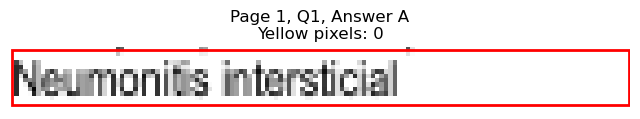

Page 1, Q1 - B: Detected box: x0=82.5, y0=135.5, x1=149.7, y1=148.2
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 345
Page 1, Q1, B: Yellow percentage: 0.0%


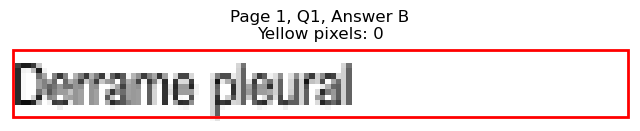

Page 1, Q1 - C: Detected box: x0=82.9, y0=148.2, x1=235.4, y1=160.9
Page 1, Q1, C: Yellow pixels: 1909
Page 1, Q1, C: Total non-white pixels: 2509
Page 1, Q1, C: Yellow percentage: 76.1%


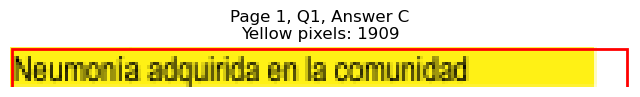

Page 1, Q1 - D: Detected box: x0=334.6, y0=122.9, x1=428.3, y1=135.6
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 480
Page 1, Q1, D: Yellow percentage: 0.0%


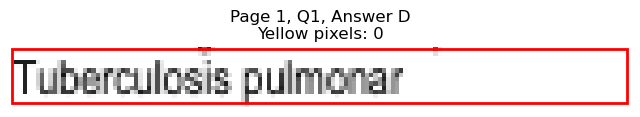

Page 1, Q1 - E: Detected box: x0=334.1, y0=135.5, x1=425.5, y1=148.2
Page 1, Q1, E: Yellow pixels: 0
Page 1, Q1, E: Total non-white pixels: 487
Page 1, Q1, E: Yellow percentage: 0.0%


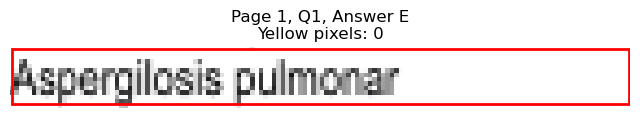


Page 1, Q1 - Selected Answer: C (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=82.5, y0=211.3, x1=148.7, y1=224.0
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 327
Page 1, Q2, A: Yellow percentage: 0.0%


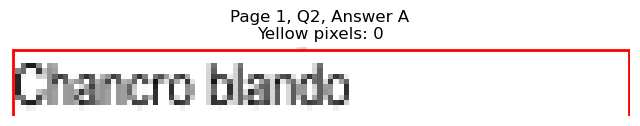

Page 1, Q2 - B: Detected box: x0=82.5, y0=223.9, x1=163.2, y1=236.6
Page 1, Q2, B: Yellow pixels: 0
Page 1, Q2, B: Total non-white pixels: 377
Page 1, Q2, B: Yellow percentage: 0.0%


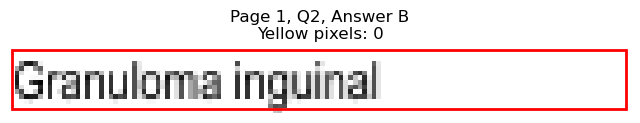

Page 1, Q2 - C: Detected box: x0=82.9, y0=236.5, x1=107.1, y1=249.2
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 145
Page 1, Q2, C: Yellow percentage: 0.0%


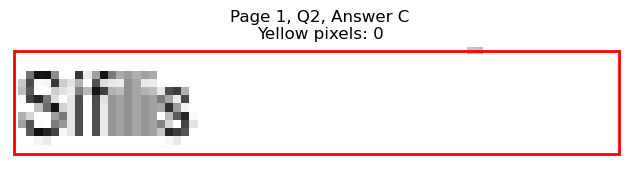

Page 1, Q2 - D: Detected box: x0=334.6, y0=211.3, x1=416.9, y1=224.0
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 554
Page 1, Q2, D: Yellow percentage: 0.0%


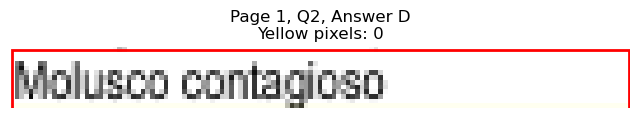

Page 1, Q2 - E: Detected box: x0=334.1, y0=223.9, x1=394.9, y1=236.6
Page 1, Q2, E: Yellow pixels: 1203
Page 1, Q2, E: Total non-white pixels: 1554
Page 1, Q2, E: Yellow percentage: 77.4%


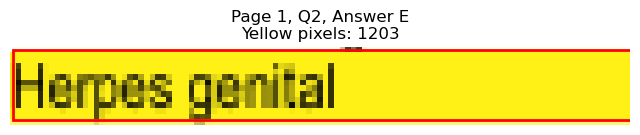


Page 1, Q2 - Selected Answer: E (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=82.5, y0=299.7, x1=156.7, y1=312.3
Page 1, Q3, A: Yellow pixels: 1236
Page 1, Q3, A: Total non-white pixels: 1750
Page 1, Q3, A: Yellow percentage: 70.6%


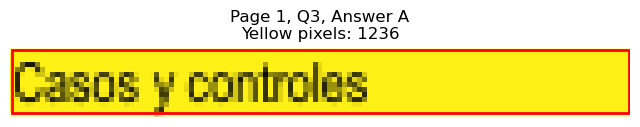

Page 1, Q3 - B: Detected box: x0=82.5, y0=312.3, x1=162.1, y1=324.9
Page 1, Q3, B: Yellow pixels: 1
Page 1, Q3, B: Total non-white pixels: 530
Page 1, Q3, B: Yellow percentage: 0.2%


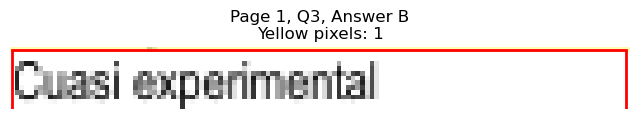

Page 1, Q3 - C: Detected box: x0=82.9, y0=324.9, x1=176.8, y1=337.5
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 455
Page 1, Q3, C: Yellow percentage: 0.0%


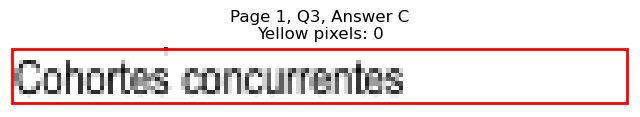

Page 1, Q3 - D: Detected box: x0=334.6, y0=299.7, x1=376.3, y1=312.3
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 223
Page 1, Q3, D: Yellow percentage: 0.0%


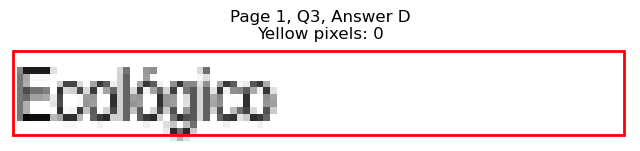

Page 1, Q3 - E: Detected box: x0=334.1, y0=312.3, x1=396.3, y1=324.9
Page 1, Q3, E: Yellow pixels: 0
Page 1, Q3, E: Total non-white pixels: 311
Page 1, Q3, E: Yellow percentage: 0.0%


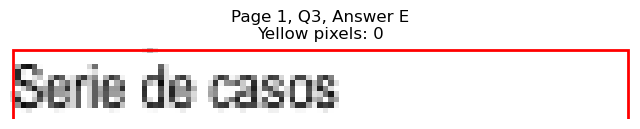


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=82.5, y0=388.0, x1=192.9, y1=400.7
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 564
Page 1, Q4, A: Yellow percentage: 0.0%


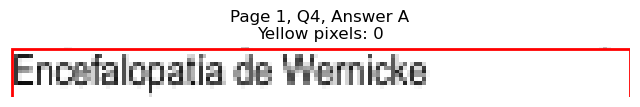

Page 1, Q4 - B: Detected box: x0=82.5, y0=400.6, x1=189.3, y1=413.3
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 541
Page 1, Q4, B: Yellow percentage: 0.0%


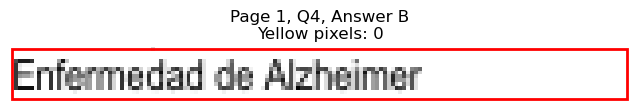

Page 1, Q4 - C: Detected box: x0=82.9, y0=413.3, x1=189.7, y1=426.0
Page 1, Q4, C: Yellow pixels: 1636
Page 1, Q4, C: Total non-white pixels: 2054
Page 1, Q4, C: Yellow percentage: 79.6%


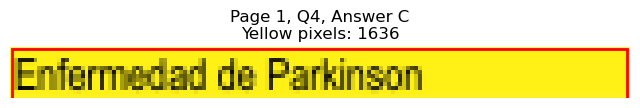

Page 1, Q4 - D: Detected box: x0=334.6, y0=388.0, x1=452.0, y1=400.7
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 613
Page 1, Q4, D: Yellow percentage: 0.0%


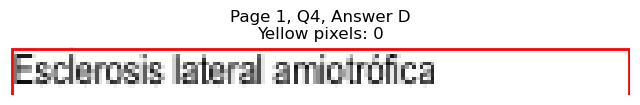

Page 1, Q4 - E: Detected box: x0=334.1, y0=400.6, x1=401.8, y1=413.3
Page 1, Q4, E: Yellow pixels: 0
Page 1, Q4, E: Total non-white pixels: 371
Page 1, Q4, E: Yellow percentage: 0.0%


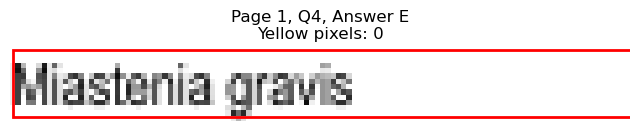


Page 1, Q4 - Selected Answer: C (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=82.5, y0=451.1, x1=122.1, y1=463.8
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 213
Page 1, Q5, A: Yellow percentage: 0.0%


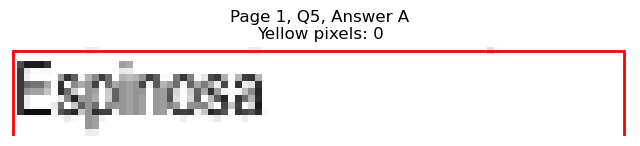

Page 1, Q5 - B: Detected box: x0=82.5, y0=463.7, x1=126.6, y1=476.4
Page 1, Q5, B: Yellow pixels: 95
Page 1, Q5, B: Total non-white pixels: 295
Page 1, Q5, B: Yellow percentage: 32.2%


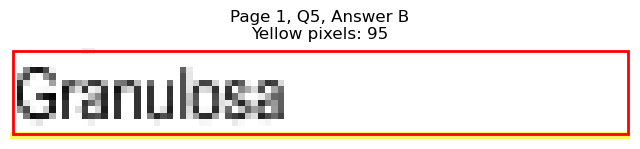

Page 1, Q5 - C: Detected box: x0=82.9, y0=476.3, x1=108.0, y1=489.0
Page 1, Q5, C: Yellow pixels: 895
Page 1, Q5, C: Total non-white pixels: 1078
Page 1, Q5, C: Yellow percentage: 83.0%


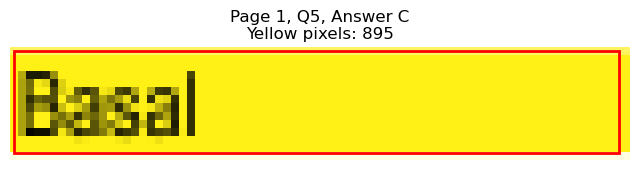

Page 1, Q5 - D: Detected box: x0=334.6, y0=451.1, x1=365.7, y1=463.8
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 157
Page 1, Q5, D: Yellow percentage: 0.0%


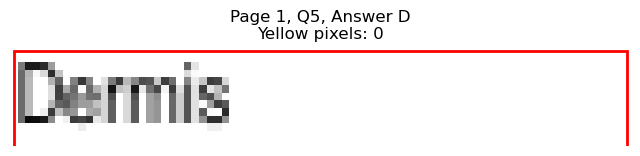

Page 1, Q5 - E: Detected box: x0=334.1, y0=463.7, x1=366.3, y1=476.4
Page 1, Q5, E: Yellow pixels: 0
Page 1, Q5, E: Total non-white pixels: 156
Page 1, Q5, E: Yellow percentage: 0.0%


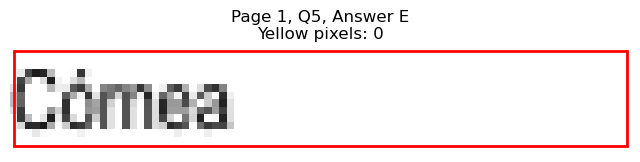


Page 1, Q5 - Selected Answer: C (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=82.5, y0=552.2, x1=188.8, y1=564.8
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 704
Page 1, Q6, A: Yellow percentage: 0.0%


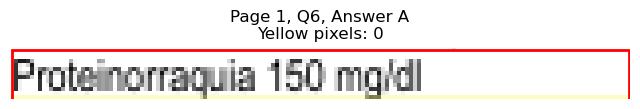

Page 1, Q6 - B: Detected box: x0=82.5, y0=564.8, x1=162.3, y1=577.4
Page 1, Q6, B: Yellow pixels: 1276
Page 1, Q6, B: Total non-white pixels: 1834
Page 1, Q6, B: Yellow percentage: 69.6%


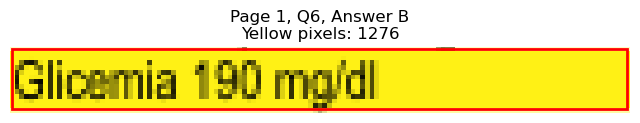

Page 1, Q6 - C: Detected box: x0=82.9, y0=577.4, x1=217.1, y1=590.0
Page 1, Q6, C: Yellow pixels: 2
Page 1, Q6, C: Total non-white pixels: 849
Page 1, Q6, C: Yellow percentage: 0.2%


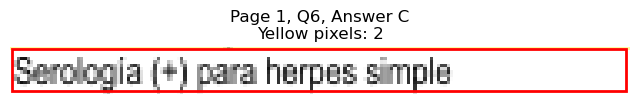

Page 1, Q6 - D: Detected box: x0=334.6, y0=552.2, x1=441.3, y1=564.8
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 522
Page 1, Q6, D: Yellow percentage: 0.0%


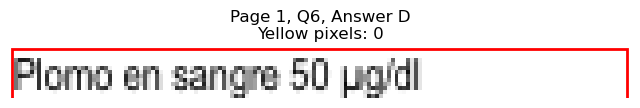

Page 1, Q6 - E: Detected box: x0=334.1, y0=564.8, x1=461.1, y1=577.4
Page 1, Q6, E: Yellow pixels: 0
Page 1, Q6, E: Total non-white pixels: 627
Page 1, Q6, E: Yellow percentage: 0.0%


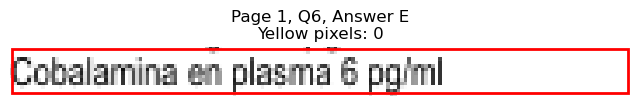


Page 1, Q6 - Selected Answer: B (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=82.5, y0=640.5, x1=219.2, y1=653.2
Page 1, Q7, A: Yellow pixels: 1947
Page 1, Q7, A: Total non-white pixels: 2632
Page 1, Q7, A: Yellow percentage: 74.0%


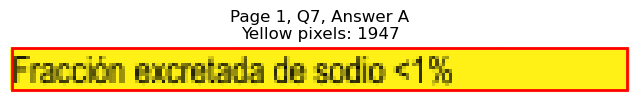

Page 1, Q7 - B: Detected box: x0=82.5, y0=653.1, x1=234.4, y1=665.8
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 762
Page 1, Q7, B: Yellow percentage: 0.0%


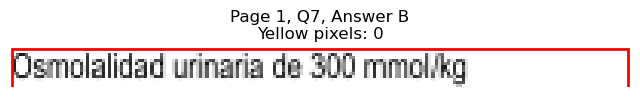

Page 1, Q7 - C: Detected box: x0=82.9, y0=665.7, x1=257.4, y1=678.4
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 863
Page 1, Q7, C: Yellow percentage: 0.0%


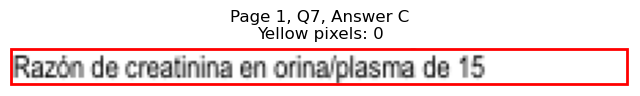

Page 1, Q7 - D: Detected box: x0=334.6, y0=640.5, x1=517.8, y1=653.2
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 868
Page 1, Q7, D: Yellow percentage: 0.0%


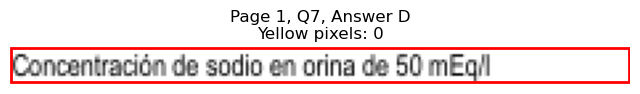

Page 1, Q7 - E: Detected box: x0=334.1, y0=653.1, x1=494.5, y1=665.8
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 750
Page 1, Q7, E: Yellow percentage: 0.0%


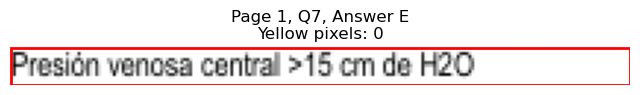


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=82.5, y0=703.7, x1=132.6, y1=716.3
Page 1, Q8, A: Yellow pixels: 994
Page 1, Q8, A: Total non-white pixels: 1414
Page 1, Q8, A: Yellow percentage: 70.3%


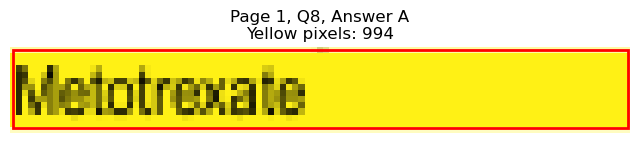

Page 1, Q8 - B: Detected box: x0=82.5, y0=716.3, x1=144.6, y1=728.9
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 429
Page 1, Q8, B: Yellow percentage: 0.0%


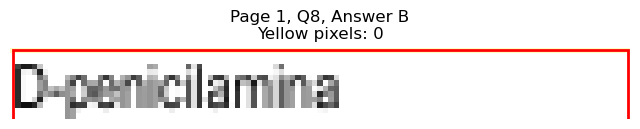

Page 1, Q8 - C: Detected box: x0=82.9, y0=728.9, x1=135.1, y1=741.5
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 251
Page 1, Q8, C: Yellow percentage: 0.0%


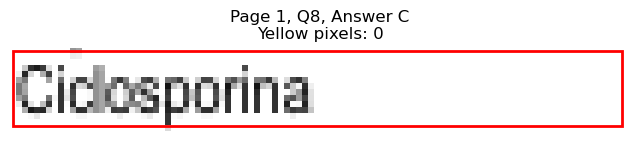

Page 1, Q8 - D: Detected box: x0=334.6, y0=703.7, x1=389.8, y1=716.3
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 283
Page 1, Q8, D: Yellow percentage: 0.0%


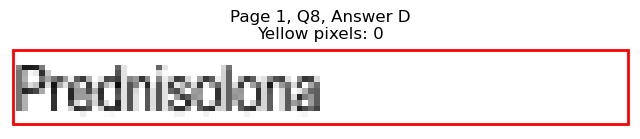

Page 1, Q8 - E: Detected box: x0=334.1, y0=716.3, x1=387.3, y1=728.9
Page 1, Q8, E: Yellow pixels: 0
Page 1, Q8, E: Total non-white pixels: 256
Page 1, Q8, E: Yellow percentage: 0.0%


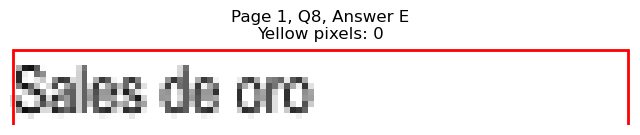


Page 1, Q8 - Selected Answer: A (based on yellow pixel count)





Page 2: Found 8 questions
Page 2, Q1 - A: Detected box: x0=82.5, y0=97.7, x1=133.1, y1=110.4
Page 2, Q1, A: Yellow pixels: 102
Page 2, Q1, A: Total non-white pixels: 363
Page 2, Q1, A: Yellow percentage: 28.1%


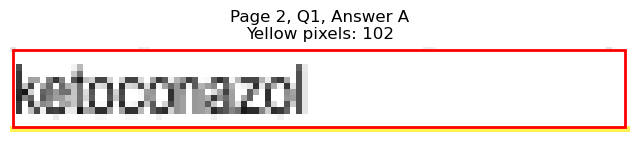

Page 2, Q1 - B: Detected box: x0=82.5, y0=110.3, x1=126.1, y1=123.0
Page 2, Q1, B: Yellow pixels: 1064
Page 2, Q1, B: Total non-white pixels: 1235
Page 2, Q1, B: Yellow percentage: 86.2%


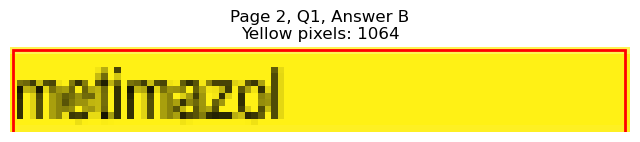

Page 2, Q1 - C: Detected box: x0=82.9, y0=122.9, x1=125.5, y1=135.6
Page 2, Q1, C: Yellow pixels: 94
Page 2, Q1, C: Total non-white pixels: 310
Page 2, Q1, C: Yellow percentage: 30.3%


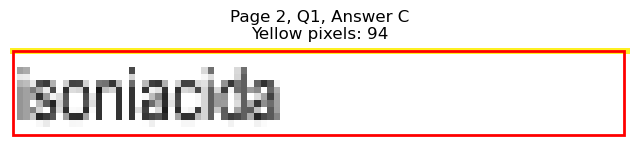

Page 2, Q1 - D: Detected box: x0=334.6, y0=97.7, x1=379.7, y1=110.4
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 240
Page 2, Q1, D: Yellow percentage: 0.0%


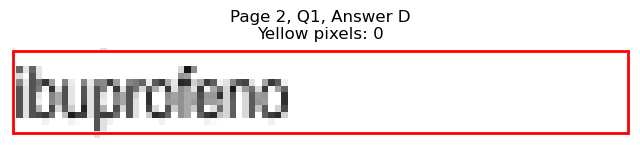

Page 2, Q1 - E: Detected box: x0=334.1, y0=110.3, x1=375.8, y1=123.0
Page 2, Q1, E: Yellow pixels: 0
Page 2, Q1, E: Total non-white pixels: 230
Page 2, Q1, E: Yellow percentage: 0.0%


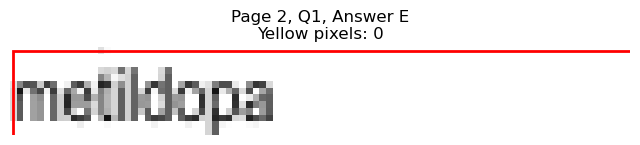


Page 2, Q1 - Selected Answer: B (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=82.5, y0=186.0, x1=135.6, y1=198.7
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 269
Page 2, Q2, A: Yellow percentage: 0.0%


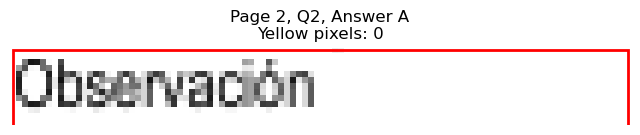

Page 2, Q2 - B: Detected box: x0=82.5, y0=198.6, x1=197.3, y1=211.3
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 569
Page 2, Q2, B: Yellow percentage: 0.0%


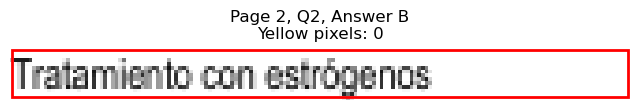

Page 2, Q2 - C: Detected box: x0=82.9, y0=211.3, x1=206.3, y1=224.0
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 593
Page 2, Q2, C: Yellow percentage: 0.0%


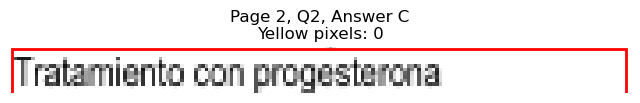

Page 2, Q2 - D: Detected box: x0=334.6, y0=186.0, x1=452.5, y1=198.7
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 745
Page 2, Q2, D: Yellow percentage: 0.0%


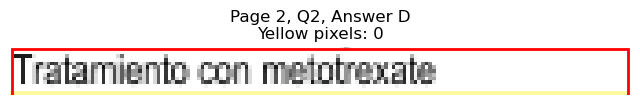

Page 2, Q2 - E: Detected box: x0=334.1, y0=198.6, x1=419.5, y1=211.3
Page 2, Q2, E: Yellow pixels: 1314
Page 2, Q2, E: Total non-white pixels: 1904
Page 2, Q2, E: Yellow percentage: 69.0%


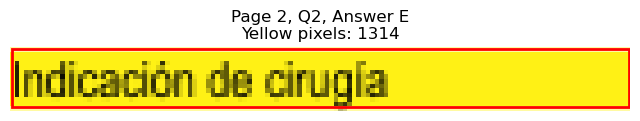


Page 2, Q2 - Selected Answer: E (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=82.5, y0=249.1, x1=115.6, y1=261.8
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 244
Page 2, Q3, A: Yellow percentage: 0.0%


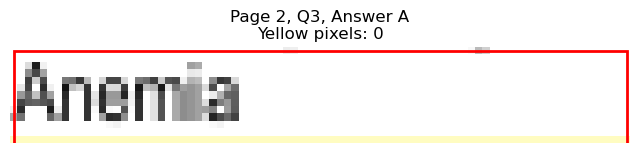

Page 2, Q3 - B: Detected box: x0=82.5, y0=261.7, x1=220.8, y1=274.4
Page 2, Q3, B: Yellow pixels: 1926
Page 2, Q3, B: Total non-white pixels: 2646
Page 2, Q3, B: Yellow percentage: 72.8%


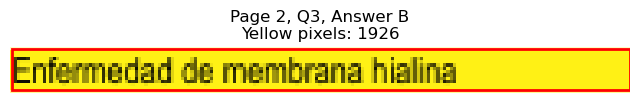

Page 2, Q3 - C: Detected box: x0=82.9, y0=274.5, x1=112.6, y1=287.1
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 155
Page 2, Q3, C: Yellow percentage: 0.0%


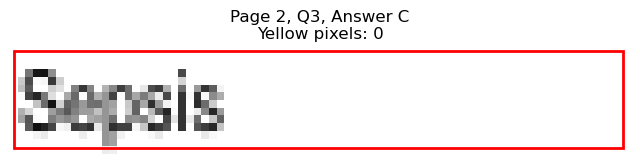

Page 2, Q3 - D: Detected box: x0=334.6, y0=249.1, x1=471.1, y1=261.8
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 672
Page 2, Q3, D: Yellow percentage: 0.0%


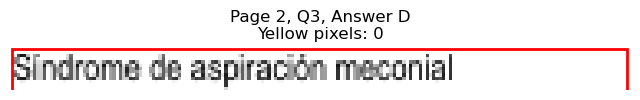

Page 2, Q3 - E: Detected box: x0=334.1, y0=261.7, x1=421.4, y1=274.4
Page 2, Q3, E: Yellow pixels: 0
Page 2, Q3, E: Total non-white pixels: 449
Page 2, Q3, E: Yellow percentage: 0.0%


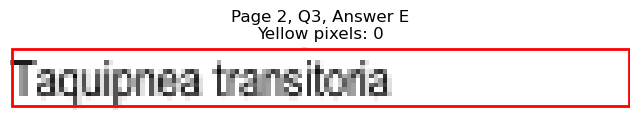


Page 2, Q3 - Selected Answer: B (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=82.5, y0=324.9, x1=172.7, y1=337.5
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 425
Page 2, Q4, A: Yellow percentage: 0.0%


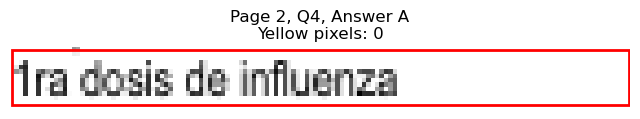

Page 2, Q4 - B: Detected box: x0=82.5, y0=337.5, x1=188.3, y1=350.1
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 511
Page 2, Q4, B: Yellow percentage: 0.0%


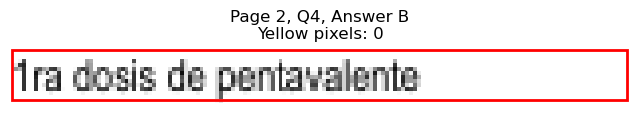

Page 2, Q4 - C: Detected box: x0=82.9, y0=350.2, x1=175.2, y1=362.9
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 469
Page 2, Q4, C: Yellow percentage: 0.0%


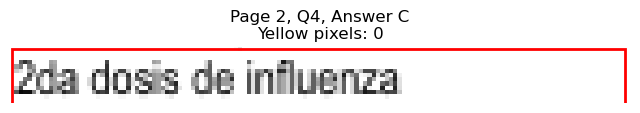

Page 2, Q4 - D: Detected box: x0=334.6, y0=324.9, x1=458.5, y1=337.5
Page 2, Q4, D: Yellow pixels: 1808
Page 2, Q4, D: Total non-white pixels: 2450
Page 2, Q4, D: Yellow percentage: 73.8%


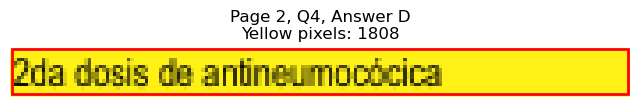

Page 2, Q4 - E: Detected box: x0=334.1, y0=337.5, x1=409.4, y1=350.1
Page 2, Q4, E: Yellow pixels: 126
Page 2, Q4, E: Total non-white pixels: 482
Page 2, Q4, E: Yellow percentage: 26.1%


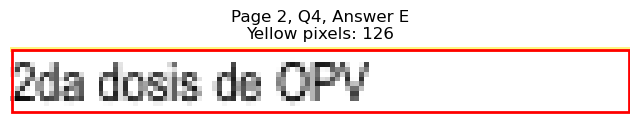


Page 2, Q4 - Selected Answer: D (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=82.5, y0=388.0, x1=189.7, y1=400.7
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 537
Page 2, Q5, A: Yellow percentage: 0.0%


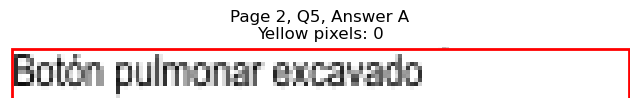

Page 2, Q5 - B: Detected box: x0=82.5, y0=400.6, x1=271.1, y1=413.3
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 916
Page 2, Q5, B: Yellow percentage: 0.0%


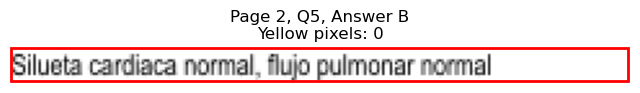

Page 2, Q5 - C: Detected box: x0=82.9, y0=413.3, x1=251.0, y1=426.0
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 845
Page 2, Q5, C: Yellow percentage: 0.0%


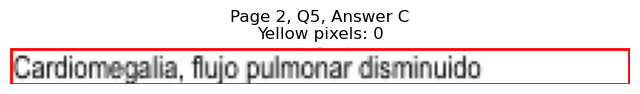

Page 2, Q5 - D: Detected box: x0=486.9, y0=388.0, x1=526.8, y1=400.7
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 189
Page 2, Q5, D: Yellow percentage: 0.0%


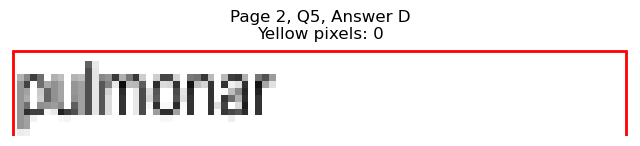

Page 2, Q5 - E: Detected box: x0=334.1, y0=413.3, x1=504.2, y1=426.0
Page 2, Q5, E: Yellow pixels: 1841
Page 2, Q5, E: Total non-white pixels: 2496
Page 2, Q5, E: Yellow percentage: 73.8%


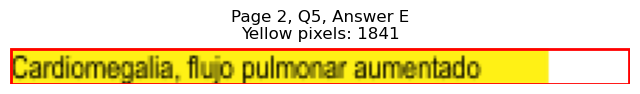


Page 2, Q5 - Selected Answer: E (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=82.5, y0=489.1, x1=144.1, y1=501.7
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 333
Page 2, Q6, A: Yellow percentage: 0.0%


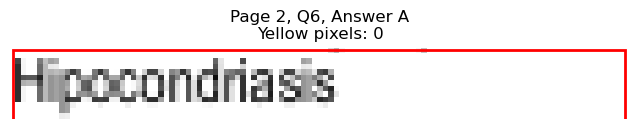

Page 2, Q6 - B: Detected box: x0=82.5, y0=501.7, x1=154.2, y1=514.3
Page 2, Q6, B: Yellow pixels: 123
Page 2, Q6, B: Total non-white pixels: 488
Page 2, Q6, B: Yellow percentage: 25.2%


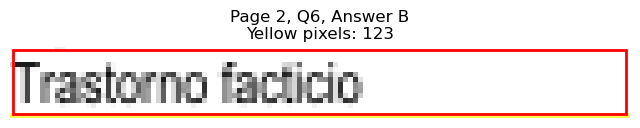

Page 2, Q6 - C: Detected box: x0=82.9, y0=514.3, x1=169.7, y1=526.9
Page 2, Q6, C: Yellow pixels: 1485
Page 2, Q6, C: Total non-white pixels: 1794
Page 2, Q6, C: Yellow percentage: 82.8%


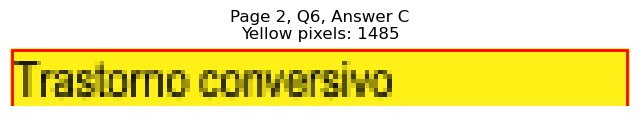

Page 2, Q6 - D: Detected box: x0=334.6, y0=489.1, x1=417.4, y1=501.7
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 410
Page 2, Q6, D: Yellow percentage: 0.0%


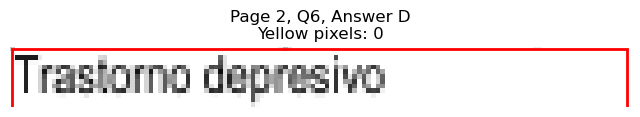

Page 2, Q6 - E: Detected box: x0=334.1, y0=501.7, x1=412.4, y1=514.3
Page 2, Q6, E: Yellow pixels: 0
Page 2, Q6, E: Total non-white pixels: 361
Page 2, Q6, E: Yellow percentage: 0.0%


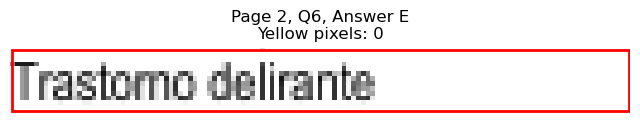


Page 2, Q6 - Selected Answer: C (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=82.5, y0=552.2, x1=219.4, y1=564.8
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 693
Page 2, Q7, A: Yellow percentage: 0.0%


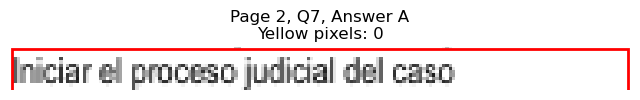

Page 2, Q7 - B: Detected box: x0=82.5, y0=564.8, x1=192.7, y1=577.4
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 578
Page 2, Q7, B: Yellow percentage: 0.0%


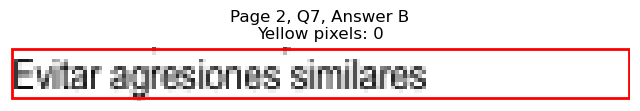

Page 2, Q7 - C: Detected box: x0=82.9, y0=577.4, x1=220.4, y1=590.0
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 728
Page 2, Q7, C: Yellow percentage: 0.0%


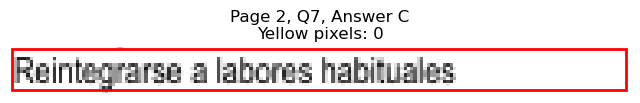

Page 2, Q7 - D: Detected box: x0=334.6, y0=552.2, x1=490.1, y1=564.8
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 979
Page 2, Q7, D: Yellow percentage: 0.0%


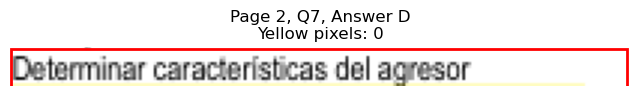

Page 2, Q7 - E: Detected box: x0=334.1, y0=564.8, x1=449.5, y1=577.4
Page 2, Q7, E: Yellow pixels: 1580
Page 2, Q7, E: Total non-white pixels: 2324
Page 2, Q7, E: Yellow percentage: 68.0%


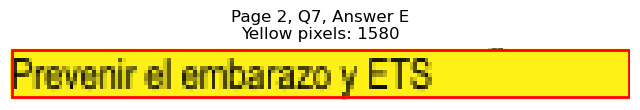


Page 2, Q7 - Selected Answer: E (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=82.5, y0=665.7, x1=119.5, y1=678.4
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 202
Page 2, Q8, A: Yellow percentage: 0.0%


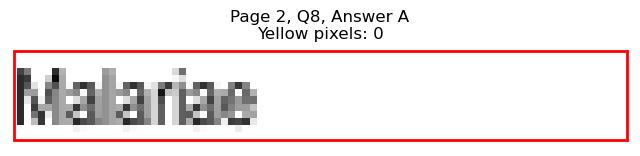

Page 2, Q8 - B: Detected box: x0=82.5, y0=678.3, x1=108.5, y1=691.0
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 124
Page 2, Q8, B: Yellow percentage: 0.0%


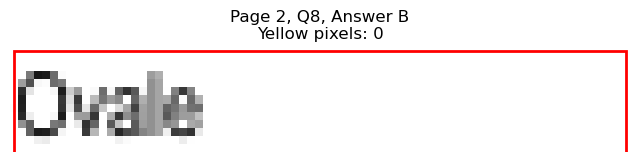

Page 2, Q8 - C: Detected box: x0=82.9, y0=691.1, x1=121.6, y1=703.7
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 198
Page 2, Q8, C: Yellow percentage: 0.0%


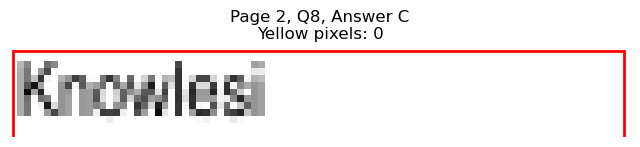

Page 2, Q8 - D: Detected box: x0=334.6, y0=665.7, x1=359.2, y1=678.4
Page 2, Q8, D: Yellow pixels: 76
Page 2, Q8, D: Total non-white pixels: 180
Page 2, Q8, D: Yellow percentage: 42.2%


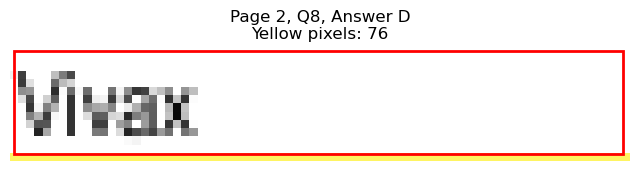

Page 2, Q8 - E: Detected box: x0=334.1, y0=678.3, x1=378.9, y1=691.0
Page 2, Q8, E: Yellow pixels: 1051
Page 2, Q8, E: Total non-white pixels: 1235
Page 2, Q8, E: Yellow percentage: 85.1%


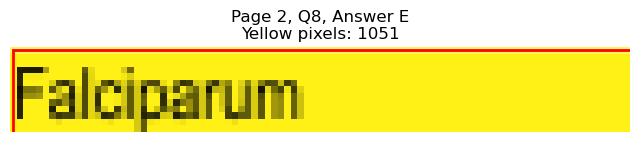


Page 2, Q8 - Selected Answer: E (based on yellow pixel count)





Page 3: Found 8 questions
Page 3, Q1 - A: Detected box: x0=82.5, y0=122.9, x1=202.4, y1=135.6
Page 3, Q1, A: Yellow pixels: 1764
Page 3, Q1, A: Total non-white pixels: 2394
Page 3, Q1, A: Yellow percentage: 73.7%


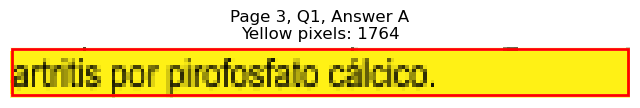

Page 3, Q1 - B: Detected box: x0=82.5, y0=135.5, x1=123.6, y1=148.2
Page 3, Q1, B: Yellow pixels: 92
Page 3, Q1, B: Total non-white pixels: 276
Page 3, Q1, B: Yellow percentage: 33.3%


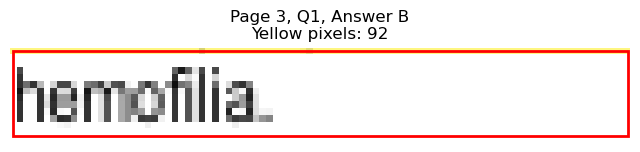

Page 3, Q1 - C: Detected box: x0=82.9, y0=148.2, x1=143.7, y1=160.9
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 309
Page 3, Q1, C: Yellow percentage: 0.0%


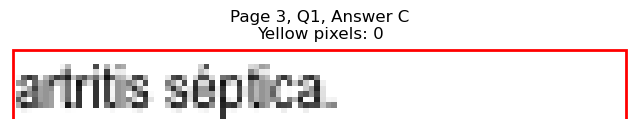

Page 3, Q1 - D: Detected box: x0=334.6, y0=122.9, x1=416.9, y1=135.6
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 437
Page 3, Q1, D: Yellow percentage: 0.0%


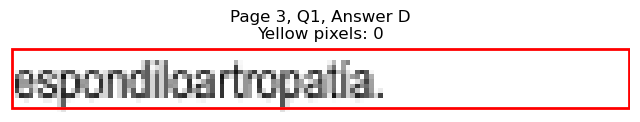

Page 3, Q1 - E: Detected box: x0=334.1, y0=135.5, x1=399.4, y1=148.2
Page 3, Q1, E: Yellow pixels: 0
Page 3, Q1, E: Total non-white pixels: 323
Page 3, Q1, E: Yellow percentage: 0.0%


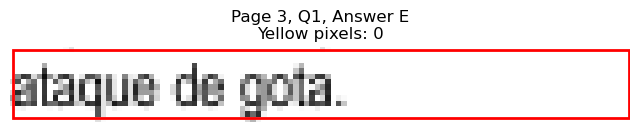


Page 3, Q1 - Selected Answer: A (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=82.5, y0=198.6, x1=122.5, y1=211.3
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 214
Page 3, Q2, A: Yellow percentage: 0.0%


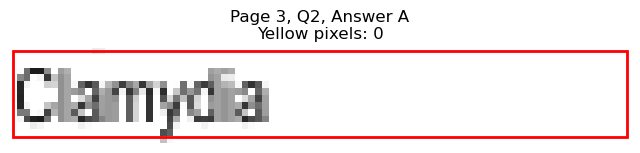

Page 3, Q2 - B: Detected box: x0=82.5, y0=211.3, x1=126.1, y1=224.0
Page 3, Q2, B: Yellow pixels: 1089
Page 3, Q2, B: Total non-white pixels: 1235
Page 3, Q2, B: Yellow percentage: 88.2%


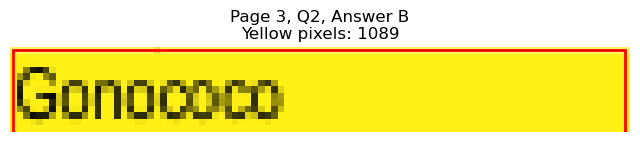

Page 3, Q2 - C: Detected box: x0=82.9, y0=223.9, x1=119.1, y1=236.6
Page 3, Q2, C: Yellow pixels: 88
Page 3, Q2, C: Total non-white pixels: 251
Page 3, Q2, C: Yellow percentage: 35.1%


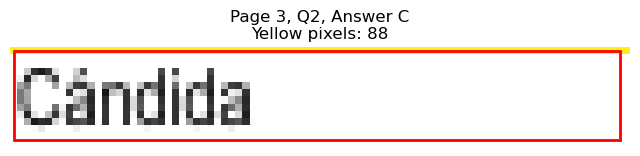

Page 3, Q2 - D: Detected box: x0=334.6, y0=198.6, x1=382.3, y1=211.3
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 235
Page 3, Q2, D: Yellow percentage: 0.0%


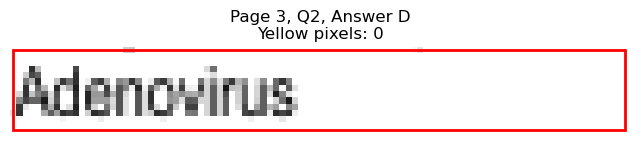

Page 3, Q2 - E: Detected box: x0=334.1, y0=211.3, x1=385.3, y1=224.0
Page 3, Q2, E: Yellow pixels: 0
Page 3, Q2, E: Total non-white pixels: 266
Page 3, Q2, E: Yellow percentage: 0.0%


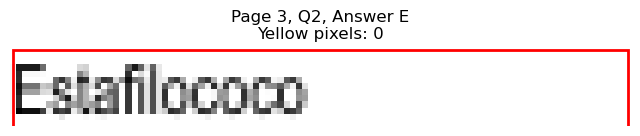


Page 3, Q2 - Selected Answer: B (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=82.5, y0=312.3, x1=216.9, y1=324.9
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 694
Page 3, Q3, A: Yellow percentage: 0.0%


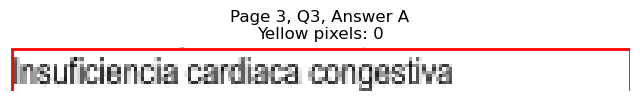

Page 3, Q3 - B: Detected box: x0=82.5, y0=324.9, x1=236.0, y1=337.5
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 793
Page 3, Q3, B: Yellow percentage: 0.0%


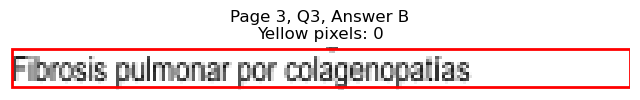

Page 3, Q3 - C: Detected box: x0=82.9, y0=337.5, x1=200.3, y1=350.1
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 619
Page 3, Q3, C: Yellow percentage: 0.0%


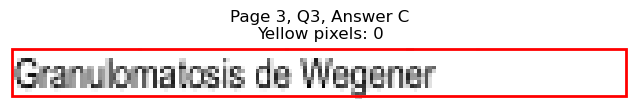

Page 3, Q3 - D: Detected box: x0=334.6, y0=312.3, x1=495.6, y1=324.9
Page 3, Q3, D: Yellow pixels: 1827
Page 3, Q3, D: Total non-white pixels: 2496
Page 3, Q3, D: Yellow percentage: 73.2%


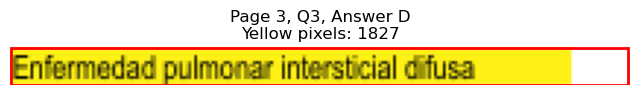

Page 3, Q3 - E: Detected box: x0=334.1, y0=324.9, x1=383.3, y1=337.5
Page 3, Q3, E: Yellow pixels: 98
Page 3, Q3, E: Total non-white pixels: 363
Page 3, Q3, E: Yellow percentage: 27.0%


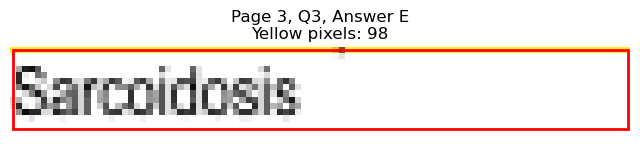


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=70.8, y0=388.0, x1=79.3, y1=400.7
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 132
Page 3, Q4, A: Yellow percentage: 0.0%


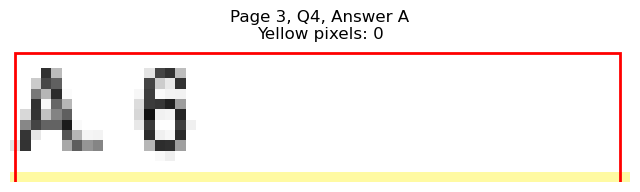

Page 3, Q4 - B: Detected box: x0=70.8, y0=400.6, x1=79.3, y1=413.3
Page 3, Q4, B: Yellow pixels: 664
Page 3, Q4, B: Total non-white pixels: 840
Page 3, Q4, B: Yellow percentage: 79.0%


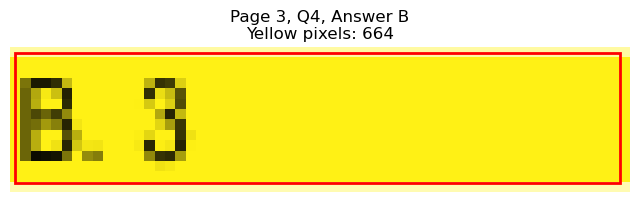

Page 3, Q4 - C: Detected box: x0=70.8, y0=413.3, x1=79.8, y1=426.0
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 115
Page 3, Q4, C: Yellow percentage: 0.0%


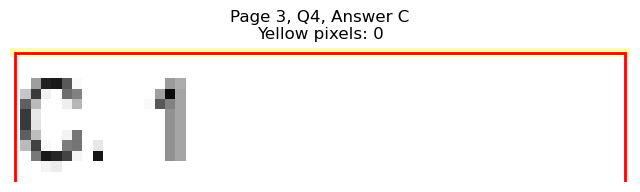

Page 3, Q4 - D: Detected box: x0=322.5, y0=388.0, x1=331.5, y1=400.7
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 69
Page 3, Q4, D: Yellow percentage: 0.0%


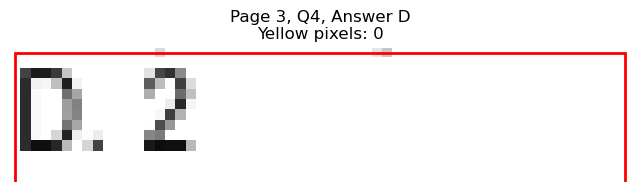

Page 3, Q4 - E: Detected box: x0=322.5, y0=400.6, x1=331.0, y1=413.3
Page 3, Q4, E: Yellow pixels: 0
Page 3, Q4, E: Total non-white pixels: 60
Page 3, Q4, E: Yellow percentage: 0.0%


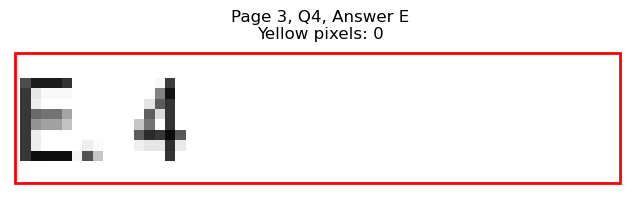


Page 3, Q4 - Selected Answer: B (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=82.5, y0=451.1, x1=151.2, y1=463.8
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 345
Page 3, Q5, A: Yellow percentage: 0.0%


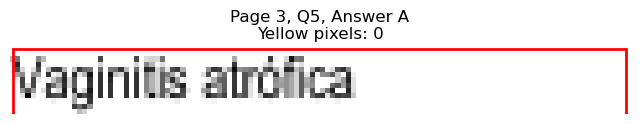

Page 3, Q5 - B: Detected box: x0=82.5, y0=463.7, x1=173.8, y1=476.4
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 460
Page 3, Q5, B: Yellow percentage: 0.0%


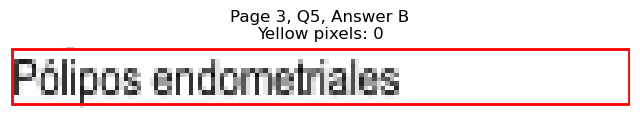

Page 3, Q5 - C: Detected box: x0=82.9, y0=476.3, x1=197.8, y1=489.0
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 548
Page 3, Q5, C: Yellow percentage: 0.0%


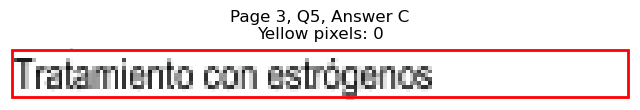

Page 3, Q5 - D: Detected box: x0=334.6, y0=451.1, x1=404.8, y1=463.8
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 458
Page 3, Q5, D: Yellow percentage: 0.0%


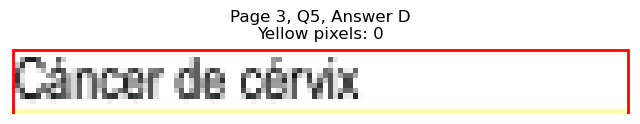

Page 3, Q5 - E: Detected box: x0=334.1, y0=463.7, x1=412.4, y1=476.4
Page 3, Q5, E: Yellow pixels: 1234
Page 3, Q5, E: Total non-white pixels: 1806
Page 3, Q5, E: Yellow percentage: 68.3%


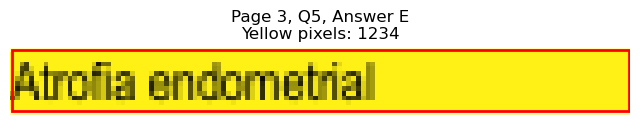


Page 3, Q5 - Selected Answer: E (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=82.5, y0=552.2, x1=164.2, y1=564.8
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 424
Page 3, Q6, A: Yellow percentage: 0.0%


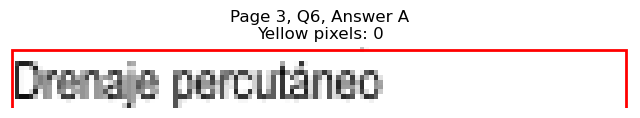

Page 3, Q6 - B: Detected box: x0=82.5, y0=564.8, x1=207.9, y1=577.4
Page 3, Q6, B: Yellow pixels: 176
Page 3, Q6, B: Total non-white pixels: 816
Page 3, Q6, B: Yellow percentage: 21.6%


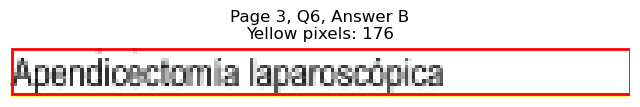

Page 3, Q6 - C: Detected box: x0=82.9, y0=577.4, x1=206.3, y1=590.0
Page 3, Q6, C: Yellow pixels: 1765
Page 3, Q6, C: Total non-white pixels: 2277
Page 3, Q6, C: Yellow percentage: 77.5%


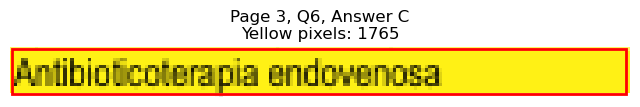

Page 3, Q6 - D: Detected box: x0=334.6, y0=552.2, x1=419.8, y1=564.8
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 443
Page 3, Q6, D: Yellow percentage: 0.0%


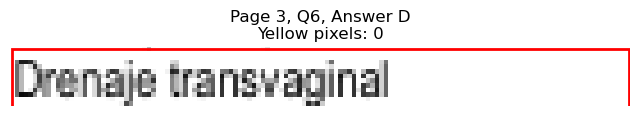

Page 3, Q6 - E: Detected box: x0=334.1, y0=564.8, x1=431.5, y1=577.4
Page 3, Q6, E: Yellow pixels: 0
Page 3, Q6, E: Total non-white pixels: 502
Page 3, Q6, E: Yellow percentage: 0.0%


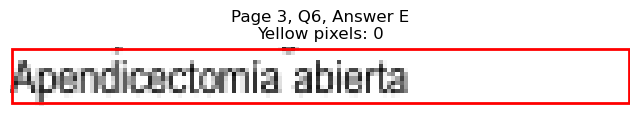


Page 3, Q6 - Selected Answer: C (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=82.5, y0=627.9, x1=275.2, y1=640.6
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 936
Page 3, Q7, A: Yellow percentage: 0.0%


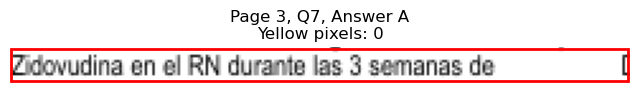

Page 3, Q7 - B: Detected box: x0=82.5, y0=653.1, x1=181.7, y1=665.8
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 474
Page 3, Q7, B: Yellow percentage: 0.0%


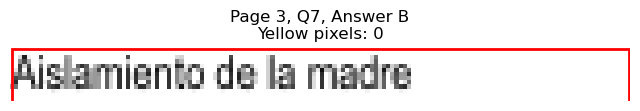

Page 3, Q7 - C: Detected box: x0=82.9, y0=665.7, x1=211.8, y1=678.4
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 617
Page 3, Q7, C: Yellow percentage: 0.0%


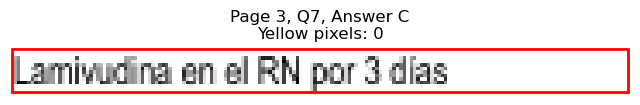

Page 3, Q7 - D: Detected box: x0=334.6, y0=627.9, x1=526.9, y1=640.6
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 894
Page 3, Q7, D: Yellow percentage: 0.0%


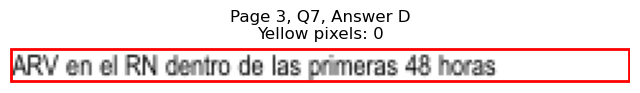

Page 3, Q7 - E: Detected box: x0=334.1, y0=653.1, x1=463.6, y1=665.8
Page 3, Q7, E: Yellow pixels: 1816
Page 3, Q7, E: Total non-white pixels: 2340
Page 3, Q7, E: Yellow percentage: 77.6%


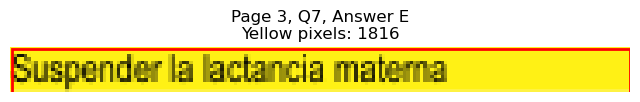


Page 3, Q7 - Selected Answer: E (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=82.5, y0=716.3, x1=124.1, y1=728.9
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 318
Page 3, Q8, A: Yellow percentage: 0.0%


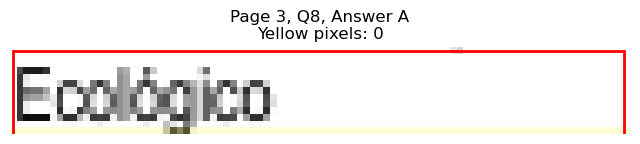

Page 3, Q8 - B: Detected box: x0=82.5, y0=728.9, x1=121.6, y1=741.5
Page 3, Q8, B: Yellow pixels: 1012
Page 3, Q8, B: Total non-white pixels: 1260
Page 3, Q8, B: Yellow percentage: 80.3%


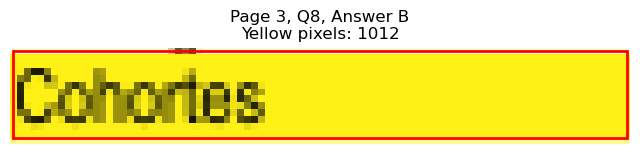

Page 3, Q8 - C: Detected box: x0=82.9, y0=741.4, x1=157.2, y1=754.1
Page 3, Q8, C: Yellow pixels: 126
Page 3, Q8, C: Total non-white pixels: 491
Page 3, Q8, C: Yellow percentage: 25.7%


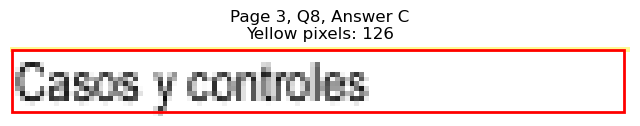

Page 3, Q8 - D: Detected box: x0=334.6, y0=716.3, x1=414.3, y1=728.9
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 414
Page 3, Q8, D: Yellow percentage: 0.0%


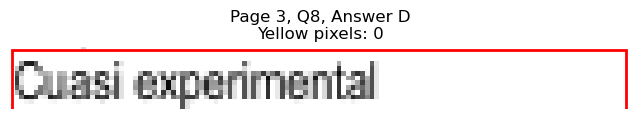

Page 3, Q8 - E: Detected box: x0=334.1, y0=728.9, x1=386.9, y1=741.5
Page 3, Q8, E: Yellow pixels: 0
Page 3, Q8, E: Total non-white pixels: 292
Page 3, Q8, E: Yellow percentage: 0.0%


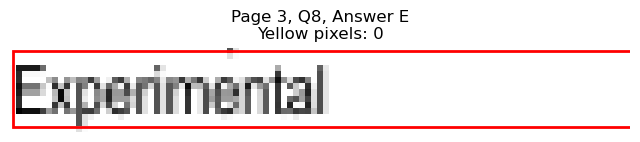


Page 3, Q8 - Selected Answer: B (based on yellow pixel count)





Page 4: Found 9 questions
Page 4, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=235.5, y1=123.0
Page 4, Q1, A: Yellow pixels: 1897
Page 4, Q1, A: Total non-white pixels: 2512
Page 4, Q1, A: Yellow percentage: 75.5%


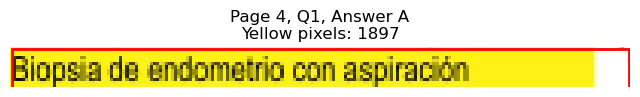

Page 4, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=191.3, y1=135.6
Page 4, Q1, B: Yellow pixels: 157
Page 4, Q1, B: Total non-white pixels: 717
Page 4, Q1, B: Yellow percentage: 21.9%


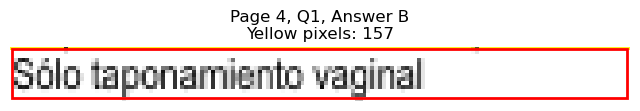

Page 4, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=220.4, y1=148.2
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 686
Page 4, Q1, C: Yellow percentage: 0.0%


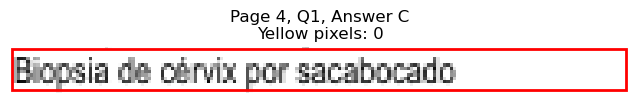

Page 4, Q1 - D: Detected box: x0=334.6, y0=110.3, x1=393.3, y1=123.0
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 264
Page 4, Q1, D: Yellow percentage: 0.0%


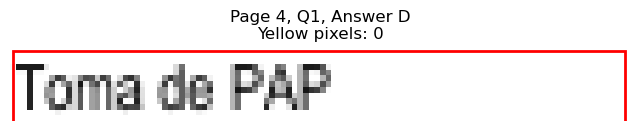

Page 4, Q1 - E: Detected box: x0=334.1, y0=122.9, x1=405.9, y1=135.6
Page 4, Q1, E: Yellow pixels: 0
Page 4, Q1, E: Total non-white pixels: 368
Page 4, Q1, E: Yellow percentage: 0.0%


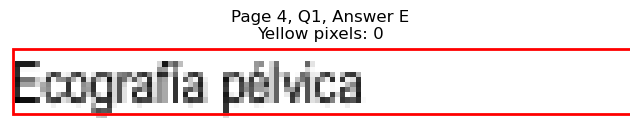


Page 4, Q1 - Selected Answer: A (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=82.5, y0=173.4, x1=147.6, y1=186.1
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 340
Page 4, Q2, A: Yellow percentage: 0.0%


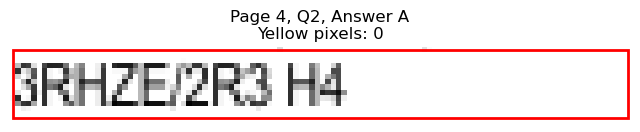

Page 4, Q2 - B: Detected box: x0=82.5, y0=186.0, x1=147.6, y1=198.7
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 456
Page 4, Q2, B: Yellow percentage: 0.0%


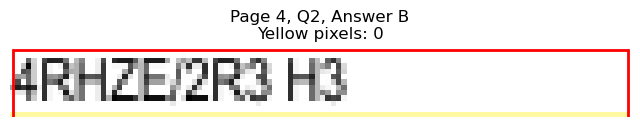

Page 4, Q2 - C: Detected box: x0=82.9, y0=198.6, x1=148.1, y1=211.3
Page 4, Q2, C: Yellow pixels: 1136
Page 4, Q2, C: Total non-white pixels: 1638
Page 4, Q2, C: Yellow percentage: 69.4%


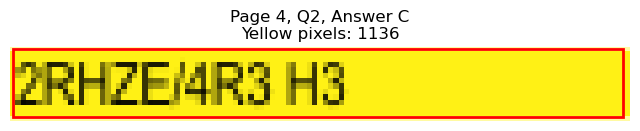

Page 4, Q2 - D: Detected box: x0=334.6, y0=173.4, x1=398.3, y1=186.1
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 322
Page 4, Q2, D: Yellow percentage: 0.0%


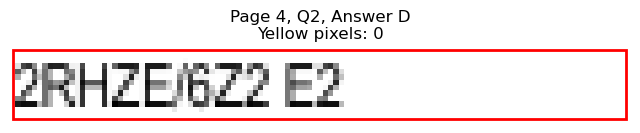

Page 4, Q2 - E: Detected box: x0=334.1, y0=186.0, x1=399.3, y1=198.7
Page 4, Q2, E: Yellow pixels: 0
Page 4, Q2, E: Total non-white pixels: 330
Page 4, Q2, E: Yellow percentage: 0.0%


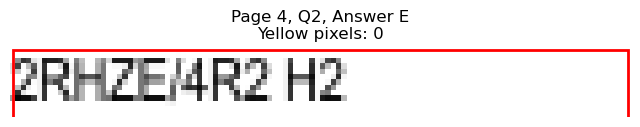


Page 4, Q2 - Selected Answer: C (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=82.5, y0=261.7, x1=157.2, y1=274.4
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 382
Page 4, Q3, A: Yellow percentage: 0.0%


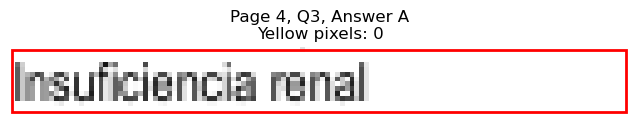

Page 4, Q3 - B: Detected box: x0=82.5, y0=274.5, x1=162.7, y1=287.1
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 405
Page 4, Q3, B: Yellow percentage: 0.0%


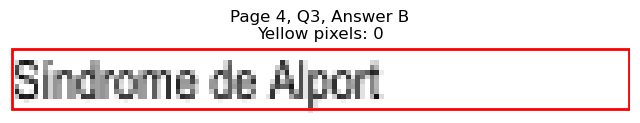

Page 4, Q3 - C: Detected box: x0=82.9, y0=287.1, x1=200.3, y1=299.7
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 615
Page 4, Q3, C: Yellow percentage: 0.0%


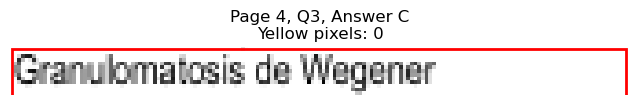

Page 4, Q3 - D: Detected box: x0=334.6, y0=261.7, x1=457.5, y1=274.4
Page 4, Q3, D: Yellow pixels: 1772
Page 4, Q3, D: Total non-white pixels: 2436
Page 4, Q3, D: Yellow percentage: 72.7%


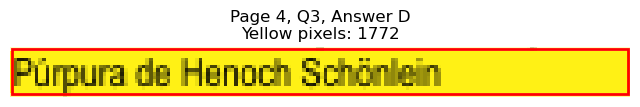

Page 4, Q3 - E: Detected box: x0=334.1, y0=274.5, x1=395.8, y1=287.1
Page 4, Q3, E: Yellow pixels: 0
Page 4, Q3, E: Total non-white pixels: 329
Page 4, Q3, E: Yellow percentage: 0.0%


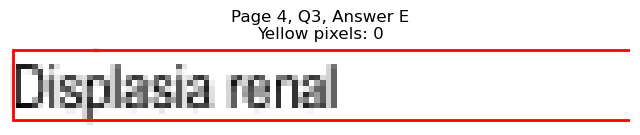


Page 4, Q3 - Selected Answer: D (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=82.5, y0=324.9, x1=245.4, y1=337.5
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 824
Page 4, Q4, A: Yellow percentage: 0.0%


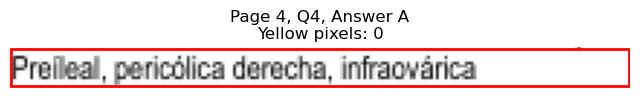

Page 4, Q4 - B: Detected box: x0=82.5, y0=337.5, x1=231.9, y1=350.1
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 760
Page 4, Q4, B: Yellow percentage: 0.0%


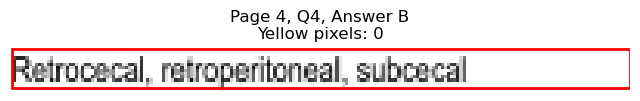

Page 4, Q4 - C: Detected box: x0=82.9, y0=350.2, x1=223.8, y1=362.9
Page 4, Q4, C: Yellow pixels: 1929
Page 4, Q4, C: Total non-white pixels: 2496
Page 4, Q4, C: Yellow percentage: 77.3%


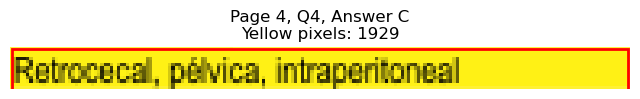

Page 4, Q4 - D: Detected box: x0=334.6, y0=324.9, x1=496.2, y1=337.5
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 822
Page 4, Q4, D: Yellow percentage: 0.0%


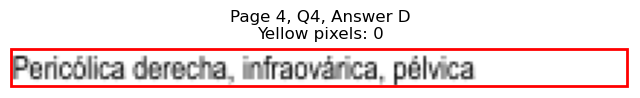

Page 4, Q4 - E: Detected box: x0=334.1, y0=337.5, x1=469.1, y1=350.1
Page 4, Q4, E: Yellow pixels: 0
Page 4, Q4, E: Total non-white pixels: 656
Page 4, Q4, E: Yellow percentage: 0.0%


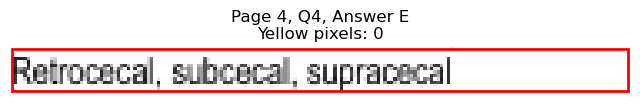


Page 4, Q4 - Selected Answer: C (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=82.5, y0=388.0, x1=151.7, y1=400.7
Page 4, Q5, A: Yellow pixels: 1273
Page 4, Q5, A: Total non-white pixels: 1560
Page 4, Q5, A: Yellow percentage: 81.6%


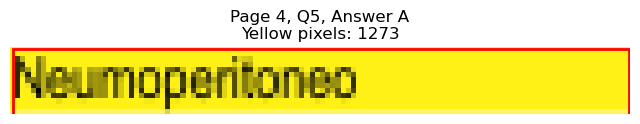

Page 4, Q5 - B: Detected box: x0=82.5, y0=400.6, x1=161.2, y1=413.3
Page 4, Q5, B: Yellow pixels: 130
Page 4, Q5, B: Total non-white pixels: 544
Page 4, Q5, B: Yellow percentage: 23.9%


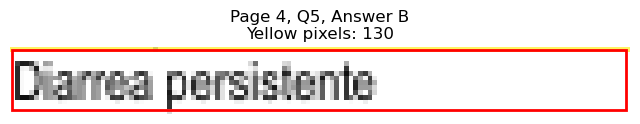

Page 4, Q5 - C: Detected box: x0=82.9, y0=413.3, x1=143.7, y1=426.0
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 317
Page 4, Q5, C: Yellow percentage: 0.0%


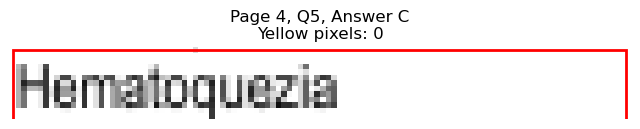

Page 4, Q5 - D: Detected box: x0=334.6, y0=388.0, x1=417.4, y1=400.7
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 419
Page 4, Q5, D: Yellow percentage: 0.0%


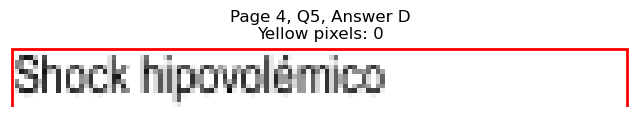

Page 4, Q5 - E: Detected box: x0=334.1, y0=400.6, x1=401.8, y1=413.3
Page 4, Q5, E: Yellow pixels: 0
Page 4, Q5, E: Total non-white pixels: 359
Page 4, Q5, E: Yellow percentage: 0.0%


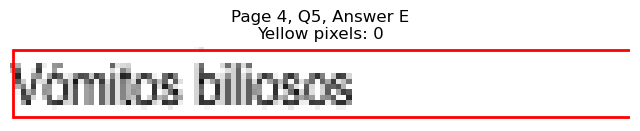


Page 4, Q5 - Selected Answer: A (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=82.5, y0=476.3, x1=128.5, y1=489.0
Page 4, Q6, A: Yellow pixels: 1079
Page 4, Q6, A: Total non-white pixels: 1358
Page 4, Q6, A: Yellow percentage: 79.5%


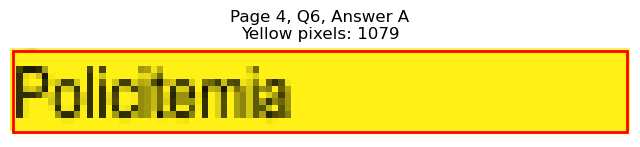

Page 4, Q6 - B: Detected box: x0=82.5, y0=489.1, x1=136.6, y1=501.7
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 415
Page 4, Q6, B: Yellow percentage: 0.0%


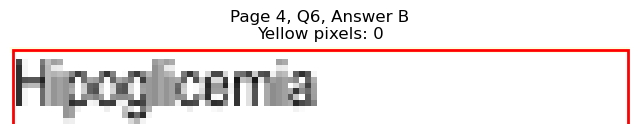

Page 4, Q6 - C: Detected box: x0=82.9, y0=501.7, x1=139.1, y1=514.3
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 276
Page 4, Q6, C: Yellow percentage: 0.0%


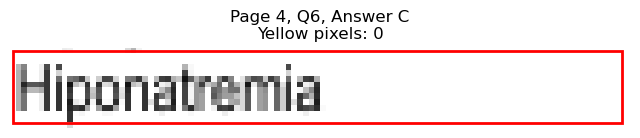

Page 4, Q6 - D: Detected box: x0=334.6, y0=476.3, x1=401.3, y1=489.0
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 348
Page 4, Q6, D: Yellow percentage: 0.0%


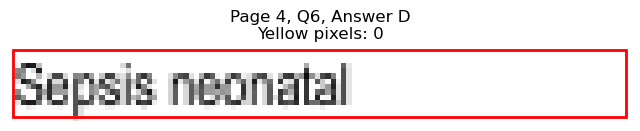

Page 4, Q6 - E: Detected box: x0=334.1, y0=489.1, x1=421.4, y1=501.7
Page 4, Q6, E: Yellow pixels: 0
Page 4, Q6, E: Total non-white pixels: 449
Page 4, Q6, E: Yellow percentage: 0.0%


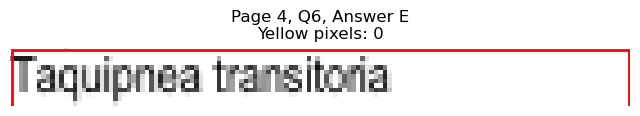


Page 4, Q6 - Selected Answer: A (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=82.5, y0=552.2, x1=145.1, y1=564.8
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 331
Page 4, Q7, A: Yellow percentage: 0.0%


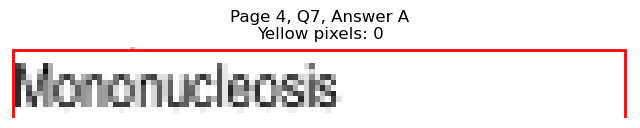

Page 4, Q7 - B: Detected box: x0=82.5, y0=564.8, x1=117.6, y1=577.4
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 168
Page 4, Q7, B: Yellow percentage: 0.0%


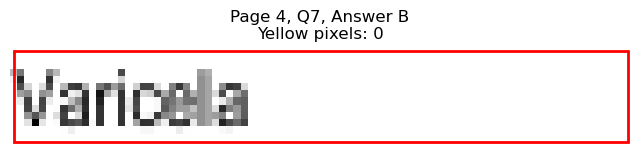

Page 4, Q7 - C: Detected box: x0=82.9, y0=577.4, x1=145.6, y1=590.0
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 327
Page 4, Q7, C: Yellow percentage: 0.0%


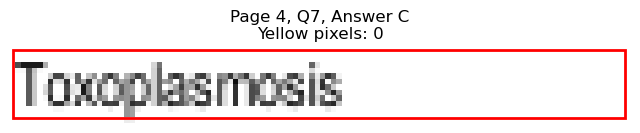

Page 4, Q7 - D: Detected box: x0=334.6, y0=552.2, x1=380.8, y1=564.8
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 332
Page 4, Q7, D: Yellow percentage: 0.0%


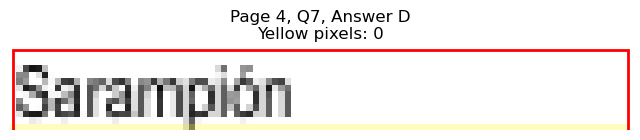

Page 4, Q7 - E: Detected box: x0=334.1, y0=564.8, x1=370.3, y1=577.4
Page 4, Q7, E: Yellow pixels: 908
Page 4, Q7, E: Total non-white pixels: 1218
Page 4, Q7, E: Yellow percentage: 74.5%


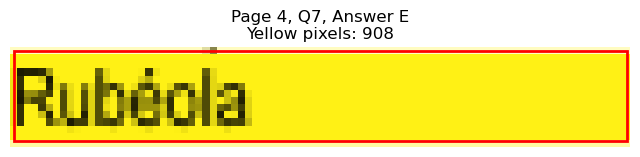


Page 4, Q7 - Selected Answer: E (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=82.5, y0=640.5, x1=176.8, y1=653.2
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 494
Page 4, Q8, A: Yellow percentage: 0.0%


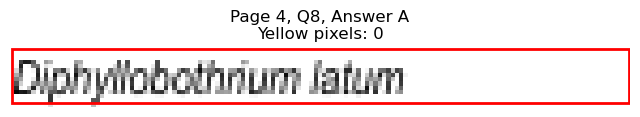

Page 4, Q8 - B: Detected box: x0=82.5, y0=653.1, x1=146.2, y1=665.8
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 300
Page 4, Q8, B: Yellow percentage: 0.0%


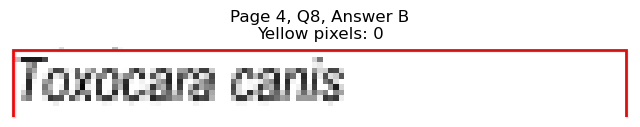

Page 4, Q8 - C: Detected box: x0=82.9, y0=665.7, x1=168.1, y1=678.4
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 424
Page 4, Q8, C: Yellow percentage: 0.0%


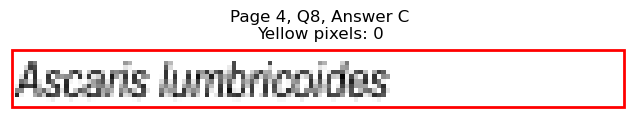

Page 4, Q8 - D: Detected box: x0=334.6, y0=640.5, x1=393.3, y1=653.2
Page 4, Q8, D: Yellow pixels: 110
Page 4, Q8, D: Total non-white pixels: 390
Page 4, Q8, D: Yellow percentage: 28.2%


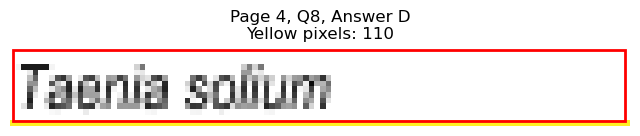

Page 4, Q8 - E: Detected box: x0=334.1, y0=653.1, x1=430.4, y1=665.8
Page 4, Q8, E: Yellow pixels: 1528
Page 4, Q8, E: Total non-white pixels: 1911
Page 4, Q8, E: Yellow percentage: 80.0%


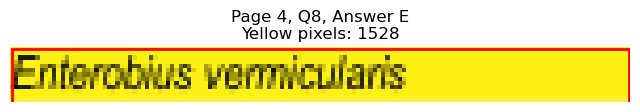


Page 4, Q8 - Selected Answer: E (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=82.5, y0=716.3, x1=149.1, y1=728.9
Page 4, Q9, A: Yellow pixels: 1141
Page 4, Q9, A: Total non-white pixels: 1534
Page 4, Q9, A: Yellow percentage: 74.4%


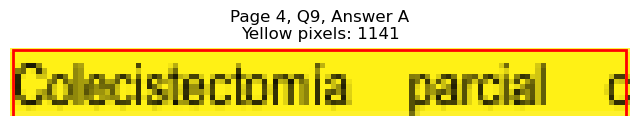

Page 4, Q9 - B: Detected box: x0=82.5, y0=741.4, x1=231.4, y1=754.1
Page 4, Q9, B: Yellow pixels: 192
Page 4, Q9, B: Total non-white pixels: 962
Page 4, Q9, B: Yellow percentage: 20.0%


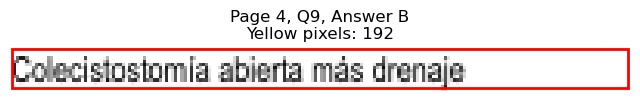

Page 4, Q9 - C: Detected box: x0=82.9, y0=754.0, x1=275.3, y1=766.7
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 1003
Page 4, Q9, C: Yellow percentage: 0.0%


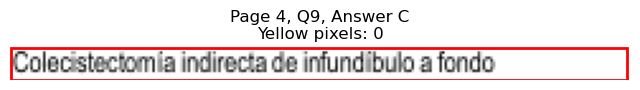

Page 4, Q9 - D: Detected box: x0=334.6, y0=716.3, x1=496.7, y1=728.9
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 826
Page 4, Q9, D: Yellow percentage: 0.0%


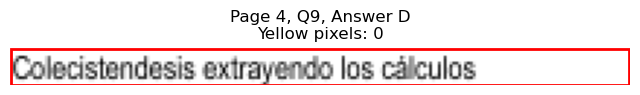

Page 4, Q9 - E: Detected box: x0=334.1, y0=728.9, x1=522.2, y1=741.5
Page 4, Q9, E: Yellow pixels: 0
Page 4, Q9, E: Total non-white pixels: 960
Page 4, Q9, E: Yellow percentage: 0.0%


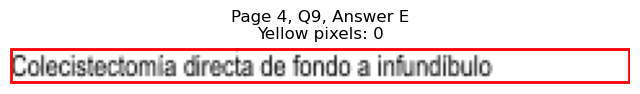


Page 4, Q9 - Selected Answer: A (based on yellow pixel count)





Page 5: Found 8 questions
Page 5, Q1 - A: Detected box: x0=82.5, y0=148.2, x1=91.0, y1=160.9
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 31
Page 5, Q1, A: Yellow percentage: 0.0%


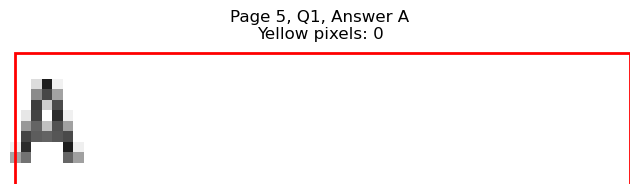

Page 5, Q1 - B: Detected box: x0=82.5, y0=160.8, x1=91.0, y1=173.5
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 37
Page 5, Q1, B: Yellow percentage: 0.0%


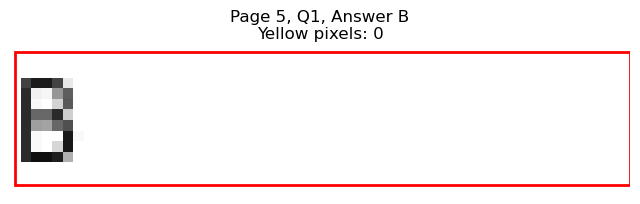

Page 5, Q1 - C: Detected box: x0=82.9, y0=173.4, x1=91.9, y1=186.1
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 33
Page 5, Q1, C: Yellow percentage: 0.0%


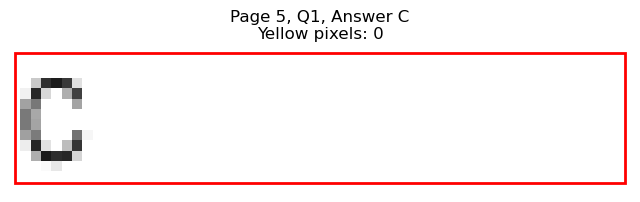

Page 5, Q1 - D: Detected box: x0=322.5, y0=148.2, x1=331.5, y1=160.9
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 133
Page 5, Q1, D: Yellow percentage: 0.0%


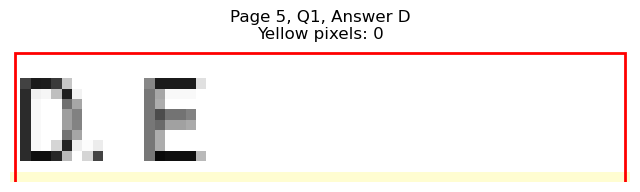

Page 5, Q1 - E: Detected box: x0=334.1, y0=160.8, x1=343.1, y1=173.5
Page 5, Q1, E: Yellow pixels: 756
Page 5, Q1, E: Total non-white pixels: 840
Page 5, Q1, E: Yellow percentage: 90.0%


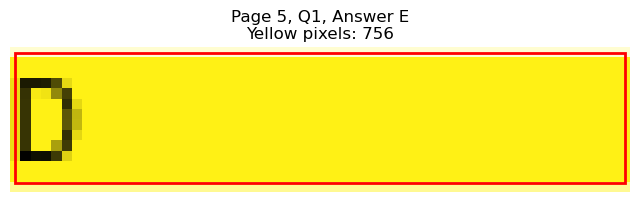


Page 5, Q1 - Selected Answer: E (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=82.5, y0=236.5, x1=159.3, y1=249.2
Page 5, Q2, A: Yellow pixels: 1378
Page 5, Q2, A: Total non-white pixels: 1792
Page 5, Q2, A: Yellow percentage: 76.9%


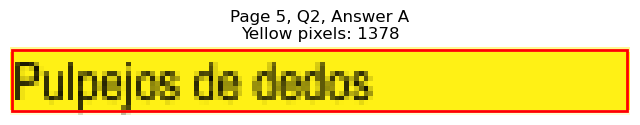

Page 5, Q2 - B: Detected box: x0=82.5, y0=249.1, x1=117.6, y1=261.8
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 280
Page 5, Q2, B: Yellow percentage: 0.0%


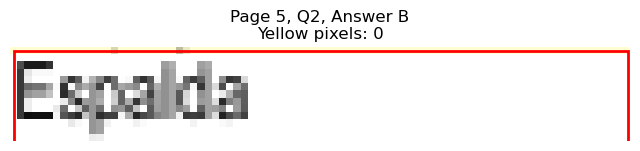

Page 5, Q2 - C: Detected box: x0=82.9, y0=261.7, x1=151.1, y1=274.4
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 330
Page 5, Q2, C: Yellow percentage: 0.0%


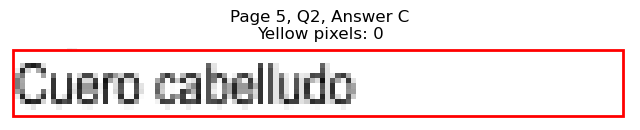

Page 5, Q2 - D: Detected box: x0=334.6, y0=236.5, x1=375.8, y1=249.2
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 199
Page 5, Q2, D: Yellow percentage: 0.0%


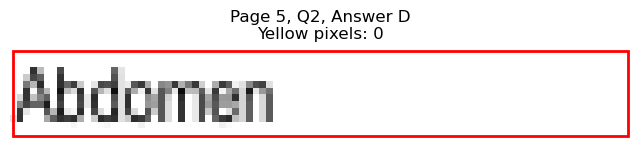

Page 5, Q2 - E: Detected box: x0=334.1, y0=249.1, x1=359.2, y1=261.8
Page 5, Q2, E: Yellow pixels: 0
Page 5, Q2, E: Total non-white pixels: 125
Page 5, Q2, E: Yellow percentage: 0.0%


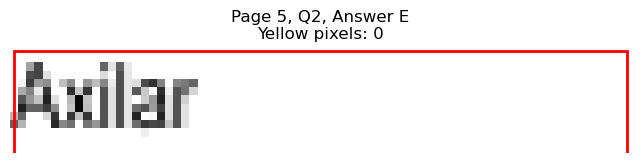


Page 5, Q2 - Selected Answer: A (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=82.5, y0=312.3, x1=184.8, y1=324.9
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 539
Page 5, Q3, A: Yellow percentage: 0.0%


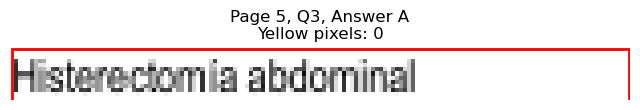

Page 5, Q3 - B: Detected box: x0=82.5, y0=324.9, x1=171.3, y1=337.5
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 431
Page 5, Q3, B: Yellow percentage: 0.0%


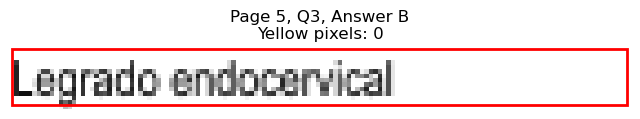

Page 5, Q3 - C: Detected box: x0=82.9, y0=337.5, x1=136.6, y1=350.1
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 293
Page 5, Q3, C: Yellow percentage: 0.0%


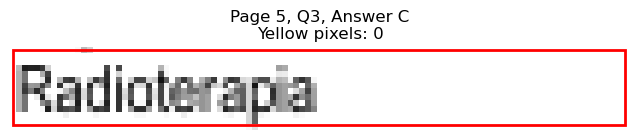

Page 5, Q3 - D: Detected box: x0=334.6, y0=312.3, x1=414.9, y1=324.9
Page 5, Q3, D: Yellow pixels: 1397
Page 5, Q3, D: Total non-white pixels: 1703
Page 5, Q3, D: Yellow percentage: 82.0%


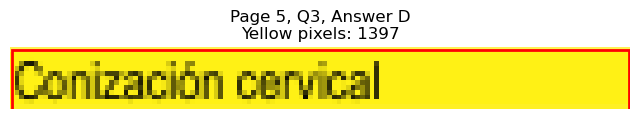

Page 5, Q3 - E: Detected box: x0=334.1, y0=324.9, x1=421.4, y1=337.5
Page 5, Q3, E: Yellow pixels: 138
Page 5, Q3, E: Total non-white pixels: 570
Page 5, Q3, E: Yellow percentage: 24.2%


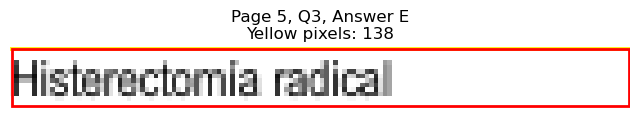


Page 5, Q3 - Selected Answer: D (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=82.5, y0=388.0, x1=138.1, y1=400.7
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 295
Page 5, Q4, A: Yellow percentage: 0.0%


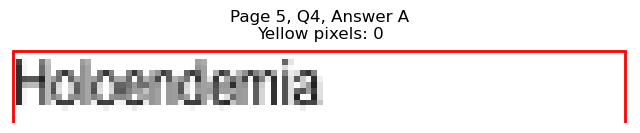

Page 5, Q4 - B: Detected box: x0=82.5, y0=400.6, x1=120.6, y1=413.3
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 181
Page 5, Q4, B: Yellow percentage: 0.0%


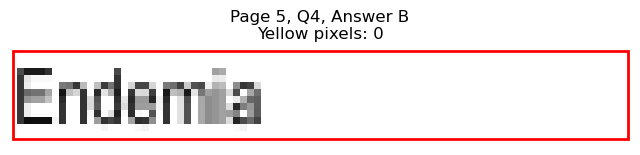

Page 5, Q4 - C: Detected box: x0=82.9, y0=413.3, x1=126.0, y1=426.0
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 220
Page 5, Q4, C: Yellow percentage: 0.0%


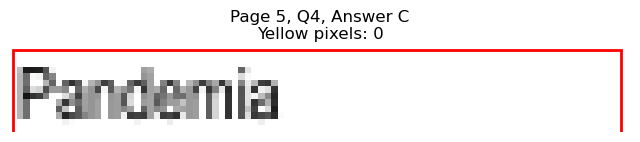

Page 5, Q4 - D: Detected box: x0=334.6, y0=388.0, x1=393.3, y1=400.7
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 433
Page 5, Q4, D: Yellow percentage: 0.0%


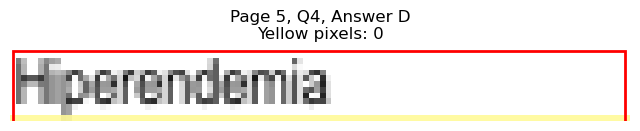

Page 5, Q4 - E: Detected box: x0=334.1, y0=400.6, x1=374.2, y1=413.3
Page 5, Q4, E: Yellow pixels: 927
Page 5, Q4, E: Total non-white pixels: 1274
Page 5, Q4, E: Yellow percentage: 72.8%


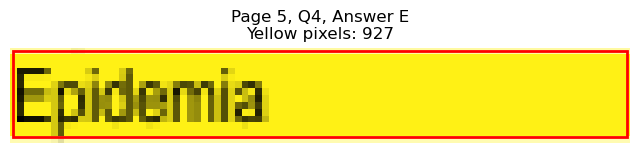


Page 5, Q4 - Selected Answer: E (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=70.8, y0=476.3, x1=79.3, y1=489.0
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 70
Page 5, Q5, A: Yellow percentage: 0.0%


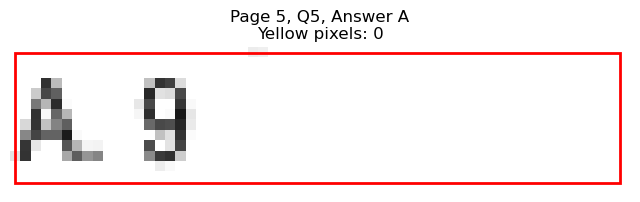

Page 5, Q5 - B: Detected box: x0=82.5, y0=489.1, x1=95.1, y1=501.7
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 48
Page 5, Q5, B: Yellow percentage: 0.0%


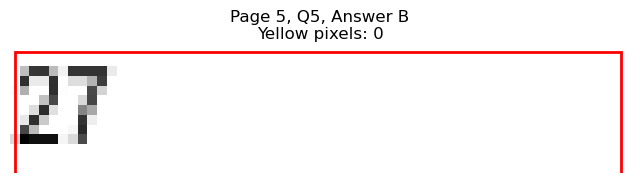

Page 5, Q5 - C: Detected box: x0=82.9, y0=501.7, x1=95.5, y1=514.3
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 65
Page 5, Q5, C: Yellow percentage: 0.0%


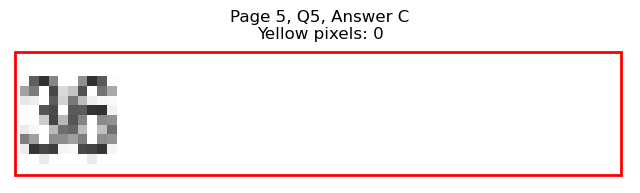

Page 5, Q5 - D: Detected box: x0=334.6, y0=476.3, x1=347.2, y1=489.0
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 56
Page 5, Q5, D: Yellow percentage: 0.0%


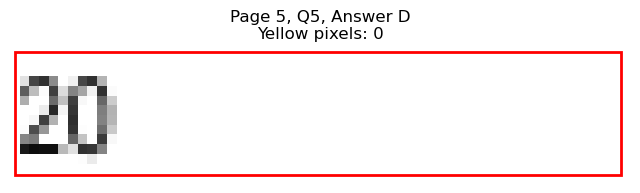

Page 5, Q5 - E: Detected box: x0=334.1, y0=489.1, x1=346.7, y1=501.7
Page 5, Q5, E: Yellow pixels: 775
Page 5, Q5, E: Total non-white pixels: 819
Page 5, Q5, E: Yellow percentage: 94.6%


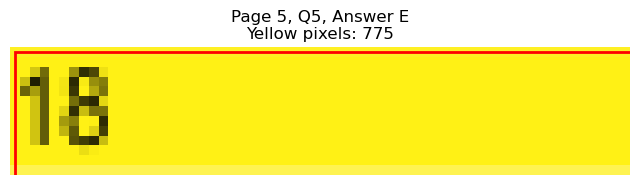


Page 5, Q5 - Selected Answer: E (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=82.5, y0=564.8, x1=196.8, y1=577.4
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 539
Page 5, Q6, A: Yellow percentage: 0.0%


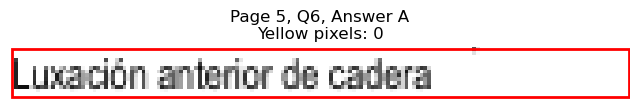

Page 5, Q6 - B: Detected box: x0=82.5, y0=577.4, x1=156.6, y1=590.0
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 356
Page 5, Q6, B: Yellow percentage: 0.0%


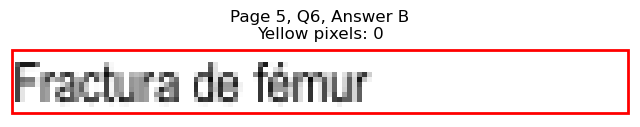

Page 5, Q6 - C: Detected box: x0=82.9, y0=590.0, x1=160.7, y1=602.6
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 390
Page 5, Q6, C: Yellow percentage: 0.0%


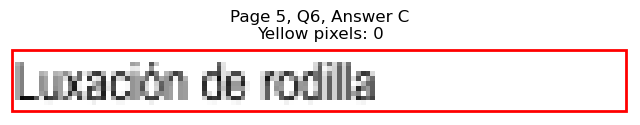

Page 5, Q6 - D: Detected box: x0=334.6, y0=564.8, x1=401.3, y1=577.4
Page 5, Q6, D: Yellow pixels: 118
Page 5, Q6, D: Total non-white pixels: 470
Page 5, Q6, D: Yellow percentage: 25.1%


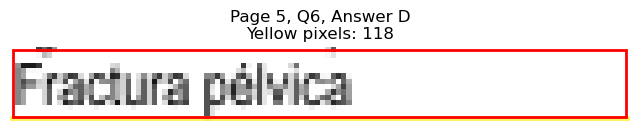

Page 5, Q6 - E: Detected box: x0=334.1, y0=577.4, x1=453.1, y1=590.0
Page 5, Q6, E: Yellow pixels: 1774
Page 5, Q6, E: Total non-white pixels: 2212
Page 5, Q6, E: Yellow percentage: 80.2%


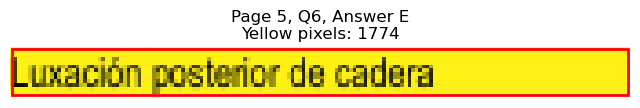


Page 5, Q6 - Selected Answer: E (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=82.5, y0=640.5, x1=124.7, y1=653.2
Page 5, Q7, A: Yellow pixels: 1053
Page 5, Q7, A: Total non-white pixels: 1302
Page 5, Q7, A: Yellow percentage: 80.9%


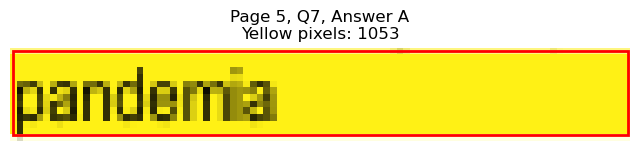

Page 5, Q7 - B: Detected box: x0=82.5, y0=653.1, x1=121.6, y1=665.8
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 198
Page 5, Q7, B: Yellow percentage: 0.0%


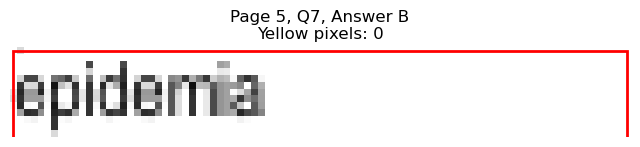

Page 5, Q7 - C: Detected box: x0=82.9, y0=665.7, x1=106.1, y1=678.4
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 121
Page 5, Q7, C: Yellow percentage: 0.0%


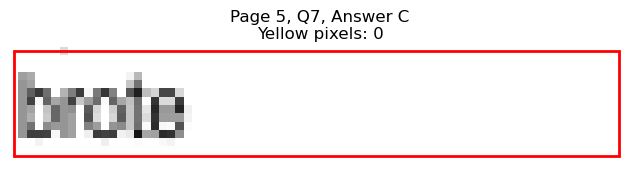

Page 5, Q7 - D: Detected box: x0=334.6, y0=640.5, x1=371.8, y1=653.2
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 189
Page 5, Q7, D: Yellow percentage: 0.0%


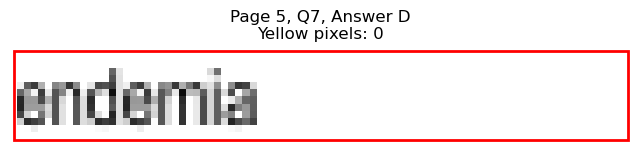

Page 5, Q7 - E: Detected box: x0=334.1, y0=653.1, x1=396.4, y1=665.8
Page 5, Q7, E: Yellow pixels: 0
Page 5, Q7, E: Total non-white pixels: 348
Page 5, Q7, E: Yellow percentage: 0.0%


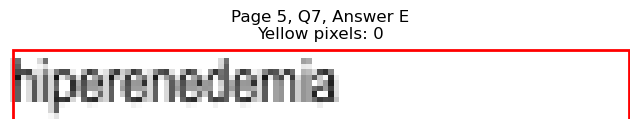


Page 5, Q7 - Selected Answer: A (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=82.5, y0=741.4, x1=146.2, y1=754.1
Page 5, Q8, A: Yellow pixels: 115
Page 5, Q8, A: Total non-white pixels: 424
Page 5, Q8, A: Yellow percentage: 27.1%


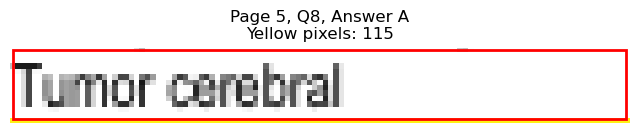

Page 5, Q8 - B: Detected box: x0=82.5, y0=754.0, x1=154.7, y1=766.7
Page 5, Q8, B: Yellow pixels: 1315
Page 5, Q8, B: Total non-white pixels: 1599
Page 5, Q8, B: Yellow percentage: 82.2%


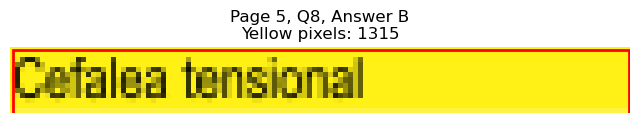

Page 5, Q8 - C: Detected box: x0=82.9, y0=766.8, x1=163.2, y1=779.4
Page 5, Q8, C: Yellow pixels: 132
Page 5, Q8, C: Total non-white pixels: 529
Page 5, Q8, C: Yellow percentage: 25.0%


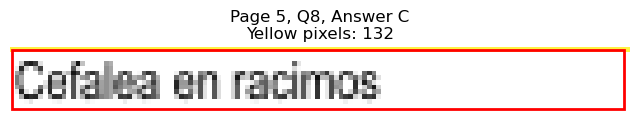

Page 5, Q8 - D: Detected box: x0=334.6, y0=741.4, x1=369.8, y1=754.1
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 206
Page 5, Q8, D: Yellow percentage: 0.0%


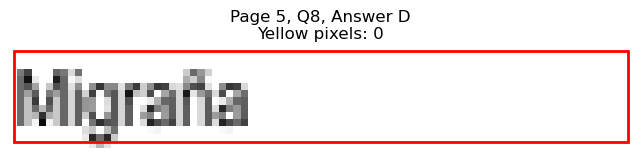

Page 5, Q8 - E: Detected box: x0=334.1, y0=754.0, x1=456.6, y1=766.7
Page 5, Q8, E: Yellow pixels: 0
Page 5, Q8, E: Total non-white pixels: 614
Page 5, Q8, E: Yellow percentage: 0.0%


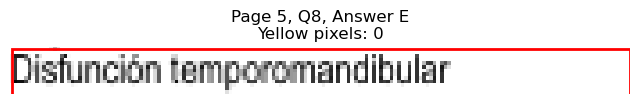


Page 5, Q8 - Selected Answer: B (based on yellow pixel count)





Page 6: Found 7 questions
Page 6, Q1 - A: Detected box: x0=82.5, y0=135.5, x1=275.3, y1=148.2
Page 6, Q1, A: Yellow pixels: 53
Page 6, Q1, A: Total non-white pixels: 1083
Page 6, Q1, A: Yellow percentage: 4.9%


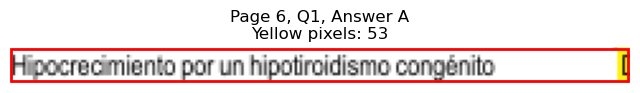

Page 6, Q1 - B: Detected box: x0=82.5, y0=148.2, x1=259.5, y1=160.9
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 861
Page 6, Q1, B: Yellow percentage: 0.0%


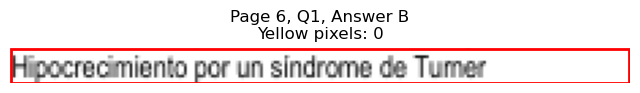

Page 6, Q1 - C: Detected box: x0=82.9, y0=160.8, x1=275.2, y1=173.5
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 928
Page 6, Q1, C: Yellow percentage: 0.0%


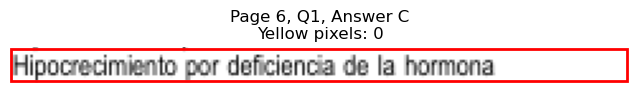

Page 6, Q1 - D: Detected box: x0=334.6, y0=135.5, x1=415.4, y1=148.2
Page 6, Q1, D: Yellow pixels: 1408
Page 6, Q1, D: Total non-white pixels: 1848
Page 6, Q1, D: Yellow percentage: 76.2%


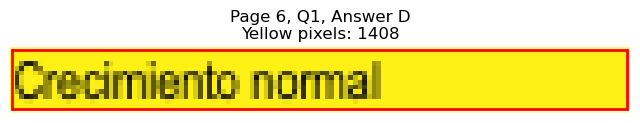

Page 6, Q1 - E: Detected box: x0=334.1, y0=148.2, x1=515.7, y1=160.9
Page 6, Q1, E: Yellow pixels: 0
Page 6, Q1, E: Total non-white pixels: 1084
Page 6, Q1, E: Yellow percentage: 0.0%


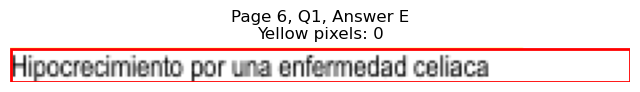


Page 6, Q1 - Selected Answer: D (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=82.5, y0=236.5, x1=130.1, y1=249.2
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 230
Page 6, Q2, A: Yellow percentage: 0.0%


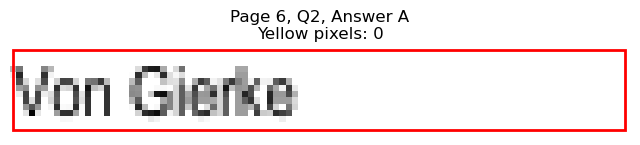

Page 6, Q2 - B: Detected box: x0=82.5, y0=249.1, x1=177.7, y1=261.8
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 469
Page 6, Q2, B: Yellow percentage: 0.0%


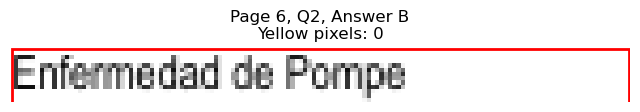

Page 6, Q2 - C: Detected box: x0=82.9, y0=261.7, x1=142.1, y1=274.4
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 289
Page 6, Q2, C: Yellow percentage: 0.0%


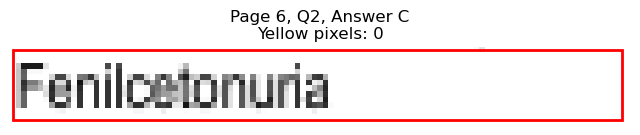

Page 6, Q2 - D: Detected box: x0=334.6, y0=236.5, x1=392.3, y1=249.2
Page 6, Q2, D: Yellow pixels: 1194
Page 6, Q2, D: Total non-white pixels: 1526
Page 6, Q2, D: Yellow percentage: 78.2%


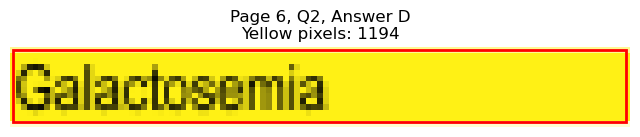

Page 6, Q2 - E: Detected box: x0=334.1, y0=249.1, x1=400.9, y1=261.8
Page 6, Q2, E: Yellow pixels: 0
Page 6, Q2, E: Total non-white pixels: 459
Page 6, Q2, E: Yellow percentage: 0.0%


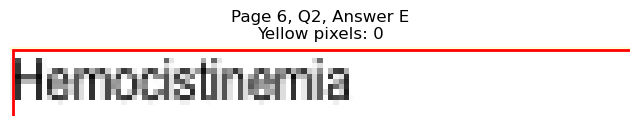


Page 6, Q2 - Selected Answer: D (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=82.5, y0=299.7, x1=116.5, y1=312.3
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 168
Page 6, Q3, A: Yellow percentage: 0.0%


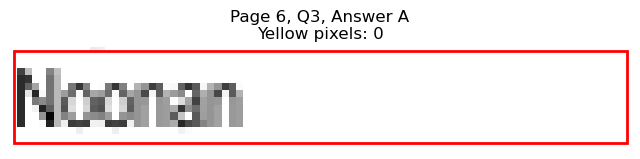

Page 6, Q3 - B: Detected box: x0=82.5, y0=312.3, x1=116.1, y1=324.9
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 167
Page 6, Q3, B: Yellow percentage: 0.0%


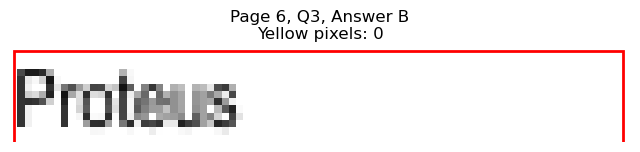

Page 6, Q3 - C: Detected box: x0=82.9, y0=324.9, x1=113.5, y1=337.5
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 152
Page 6, Q3, C: Yellow percentage: 0.0%


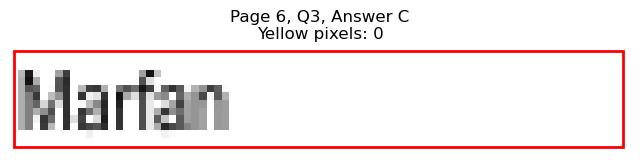

Page 6, Q3 - D: Detected box: x0=334.6, y0=299.7, x1=370.7, y1=312.3
Page 6, Q3, D: Yellow pixels: 87
Page 6, Q3, D: Total non-white pixels: 290
Page 6, Q3, D: Yellow percentage: 30.0%


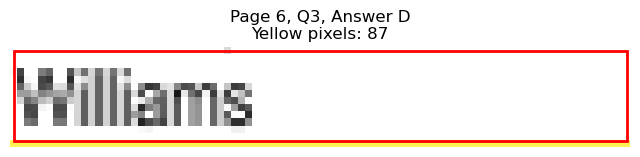

Page 6, Q3 - E: Detected box: x0=334.1, y0=312.3, x1=363.2, y1=324.9
Page 6, Q3, E: Yellow pixels: 945
Page 6, Q3, E: Total non-white pixels: 1040
Page 6, Q3, E: Yellow percentage: 90.9%


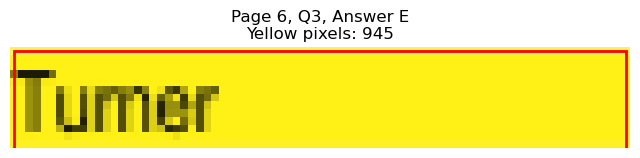


Page 6, Q3 - Selected Answer: E (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=82.5, y0=388.0, x1=142.1, y1=400.7
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 315
Page 6, Q4, A: Yellow percentage: 0.0%


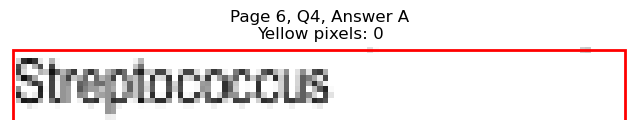

Page 6, Q4 - B: Detected box: x0=82.5, y0=400.6, x1=137.7, y1=413.3
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 275
Page 6, Q4, B: Yellow percentage: 0.0%


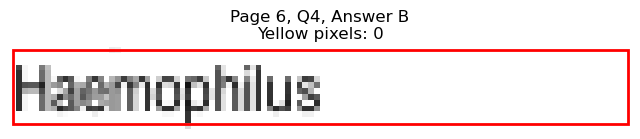

Page 6, Q4 - C: Detected box: x0=82.9, y0=413.3, x1=143.2, y1=426.0
Page 6, Q4, C: Yellow pixels: 1228
Page 6, Q4, C: Total non-white pixels: 1456
Page 6, Q4, C: Yellow percentage: 84.3%


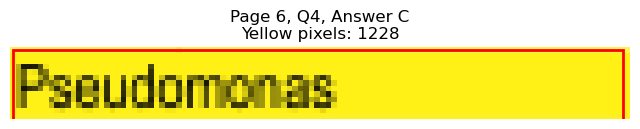

Page 6, Q4 - D: Detected box: x0=334.6, y0=388.0, x1=385.3, y1=400.7
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 246
Page 6, Q4, D: Yellow percentage: 0.0%


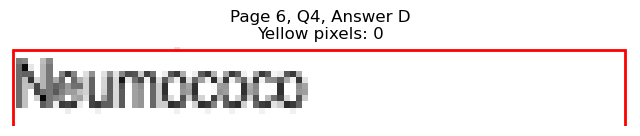

Page 6, Q4 - E: Detected box: x0=334.1, y0=400.6, x1=395.3, y1=413.3
Page 6, Q4, E: Yellow pixels: 0
Page 6, Q4, E: Total non-white pixels: 330
Page 6, Q4, E: Yellow percentage: 0.0%


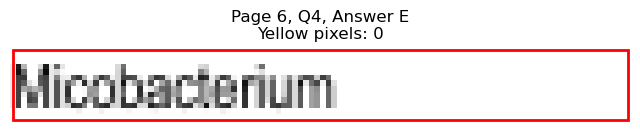


Page 6, Q4 - Selected Answer: C (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=82.5, y0=476.3, x1=125.5, y1=489.0
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 237
Page 6, Q5, A: Yellow percentage: 0.0%


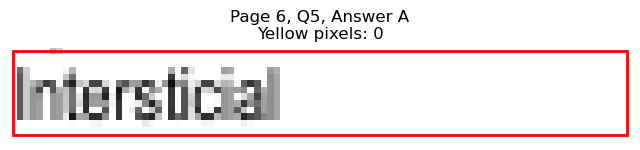

Page 6, Q5 - B: Detected box: x0=82.5, y0=489.1, x1=128.1, y1=501.7
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 318
Page 6, Q5, B: Yellow percentage: 0.0%


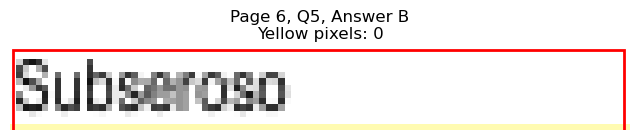

Page 6, Q5 - C: Detected box: x0=82.9, y0=501.7, x1=133.1, y1=514.3
Page 6, Q5, C: Yellow pixels: 1026
Page 6, Q5, C: Total non-white pixels: 1428
Page 6, Q5, C: Yellow percentage: 71.8%


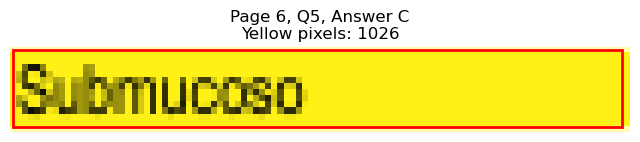

Page 6, Q5 - D: Detected box: x0=334.6, y0=476.3, x1=365.7, y1=489.0
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 150
Page 6, Q5, D: Yellow percentage: 0.0%


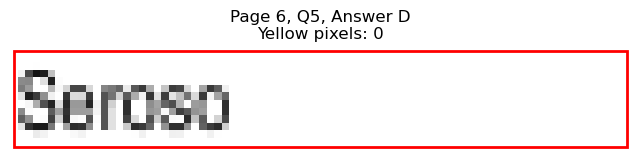

Page 6, Q5 - E: Detected box: x0=334.1, y0=489.1, x1=377.2, y1=501.7
Page 6, Q5, E: Yellow pixels: 0
Page 6, Q5, E: Total non-white pixels: 217
Page 6, Q5, E: Yellow percentage: 0.0%


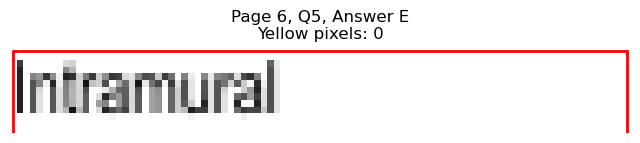


Page 6, Q5 - Selected Answer: C (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=82.5, y0=590.0, x1=147.1, y1=602.6
Page 6, Q6, A: Yellow pixels: 1247
Page 6, Q6, A: Total non-white pixels: 1624
Page 6, Q6, A: Yellow percentage: 76.8%


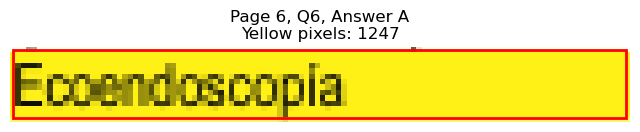

Page 6, Q6 - B: Detected box: x0=82.5, y0=602.6, x1=167.8, y1=615.2
Page 6, Q6, B: Yellow pixels: 136
Page 6, Q6, B: Total non-white pixels: 593
Page 6, Q6, B: Yellow percentage: 22.9%


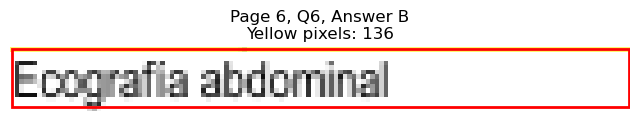

Page 6, Q6 - C: Detected box: x0=82.9, y0=615.2, x1=152.7, y1=627.8
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 357
Page 6, Q6, C: Yellow percentage: 0.0%


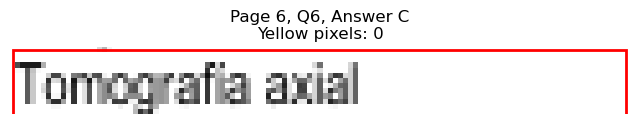

Page 6, Q6 - D: Detected box: x0=334.6, y0=590.0, x1=386.8, y1=602.6
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 264
Page 6, Q6, D: Yellow percentage: 0.0%


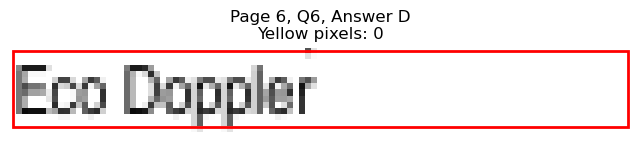

Page 6, Q6 - E: Detected box: x0=334.1, y0=602.6, x1=428.5, y1=615.2
Page 6, Q6, E: Yellow pixels: 0
Page 6, Q6, E: Total non-white pixels: 495
Page 6, Q6, E: Yellow percentage: 0.0%


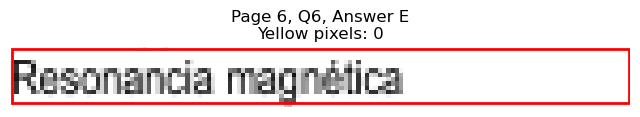


Page 6, Q6 - Selected Answer: A (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=82.5, y0=691.1, x1=226.0, y1=703.7
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 740
Page 6, Q7, A: Yellow percentage: 0.0%


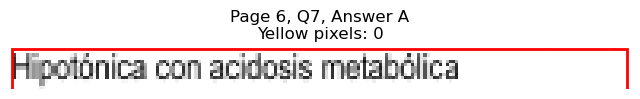

Page 6, Q7 - B: Detected box: x0=82.5, y0=703.7, x1=226.0, y1=716.3
Page 6, Q7, B: Yellow pixels: 192
Page 6, Q7, B: Total non-white pixels: 928
Page 6, Q7, B: Yellow percentage: 20.7%


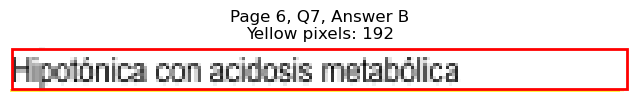

Page 6, Q7 - C: Detected box: x0=82.9, y0=716.3, x1=219.9, y1=728.9
Page 6, Q7, C: Yellow pixels: 1936
Page 6, Q7, C: Total non-white pixels: 2444
Page 6, Q7, C: Yellow percentage: 79.2%


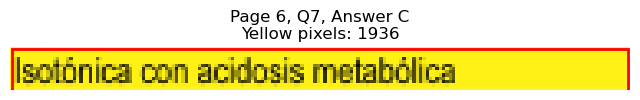

Page 6, Q7 - D: Detected box: x0=334.6, y0=691.1, x1=473.0, y1=703.7
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 702
Page 6, Q7, D: Yellow percentage: 0.0%


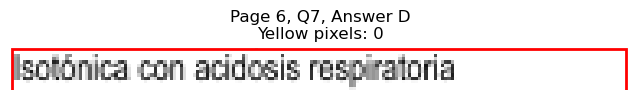

Page 6, Q7 - E: Detected box: x0=334.1, y0=703.7, x1=449.0, y1=716.3
Page 6, Q7, E: Yellow pixels: 0
Page 6, Q7, E: Total non-white pixels: 541
Page 6, Q7, E: Yellow percentage: 0.0%


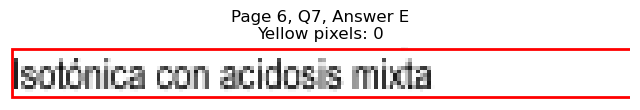


Page 6, Q7 - Selected Answer: C (based on yellow pixel count)





Page 7: Found 7 questions
Page 7, Q1 - A: Detected box: x0=82.5, y0=122.9, x1=275.2, y1=135.6
Page 7, Q1, A: Yellow pixels: 53
Page 7, Q1, A: Total non-white pixels: 1034
Page 7, Q1, A: Yellow percentage: 5.1%


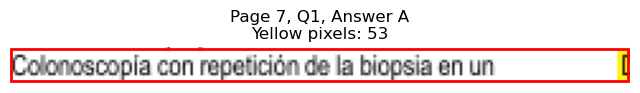

Page 7, Q1 - B: Detected box: x0=82.5, y0=148.2, x1=191.8, y1=160.9
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 531
Page 7, Q1, B: Yellow percentage: 0.0%


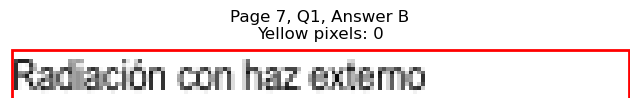

Page 7, Q1 - C: Detected box: x0=82.9, y0=160.8, x1=275.3, y1=173.5
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 958
Page 7, Q1, C: Yellow percentage: 0.0%


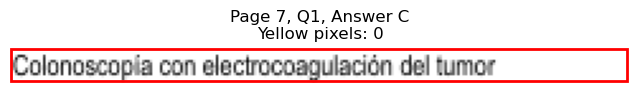

Page 7, Q1 - D: Detected box: x0=334.6, y0=122.9, x1=437.0, y1=135.6
Page 7, Q1, D: Yellow pixels: 1572
Page 7, Q1, D: Total non-white pixels: 2142
Page 7, Q1, D: Yellow percentage: 73.4%


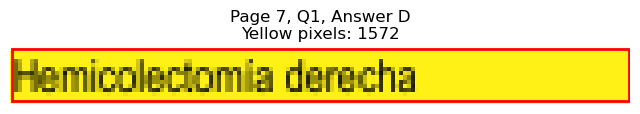

Page 7, Q1 - E: Detected box: x0=334.1, y0=135.5, x1=526.9, y1=148.2
Page 7, Q1, E: Yellow pixels: 192
Page 7, Q1, E: Total non-white pixels: 1143
Page 7, Q1, E: Yellow percentage: 16.8%


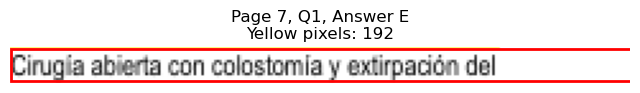


Page 7, Q1 - Selected Answer: D (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=82.5, y0=236.5, x1=266.6, y1=249.2
Page 7, Q2, A: Yellow pixels: 1780
Page 7, Q2, A: Total non-white pixels: 2702
Page 7, Q2, A: Yellow percentage: 65.9%


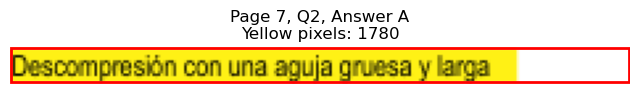

Page 7, Q2 - B: Detected box: x0=82.5, y0=249.1, x1=237.4, y1=261.8
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 960
Page 7, Q2, B: Yellow percentage: 0.0%


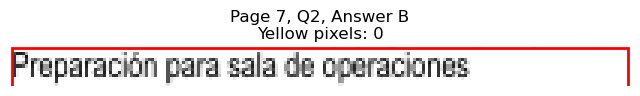

Page 7, Q2 - C: Detected box: x0=82.9, y0=261.7, x1=146.7, y1=274.4
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 323
Page 7, Q2, C: Yellow percentage: 0.0%


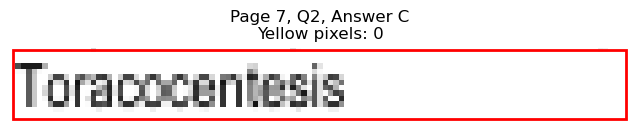

Page 7, Q2 - D: Detected box: x0=334.6, y0=236.5, x1=481.1, y1=249.2
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 741
Page 7, Q2, D: Yellow percentage: 0.0%


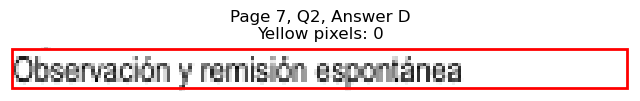

Page 7, Q2 - E: Detected box: x0=334.1, y0=249.1, x1=462.5, y1=261.8
Page 7, Q2, E: Yellow pixels: 0
Page 7, Q2, E: Total non-white pixels: 630
Page 7, Q2, E: Yellow percentage: 0.0%


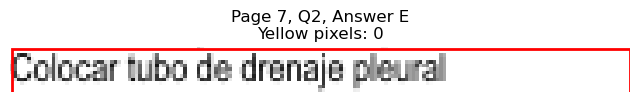


Page 7, Q2 - Selected Answer: A (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=82.5, y0=350.2, x1=149.7, y1=362.9
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 347
Page 7, Q3, A: Yellow percentage: 0.0%


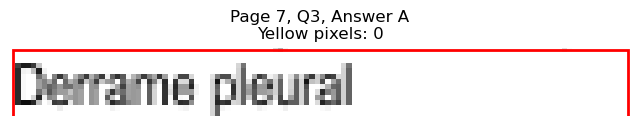

Page 7, Q3 - B: Detected box: x0=82.5, y0=362.8, x1=187.8, y1=375.5
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 524
Page 7, Q3, B: Yellow percentage: 0.0%


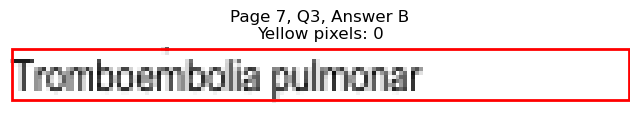

Page 7, Q3 - C: Detected box: x0=82.9, y0=375.4, x1=185.8, y1=388.1
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 538
Page 7, Q3, C: Yellow percentage: 0.0%


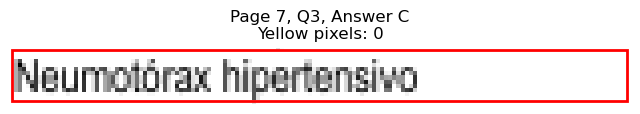

Page 7, Q3 - D: Detected box: x0=334.6, y0=350.2, x1=435.9, y1=362.9
Page 7, Q3, D: Yellow pixels: 1554
Page 7, Q3, D: Total non-white pixels: 1976
Page 7, Q3, D: Yellow percentage: 78.6%


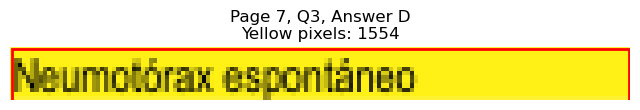

Page 7, Q3 - E: Detected box: x0=334.1, y0=362.8, x1=380.8, y1=375.5
Page 7, Q3, E: Yellow pixels: 95
Page 7, Q3, E: Total non-white pixels: 326
Page 7, Q3, E: Yellow percentage: 29.1%


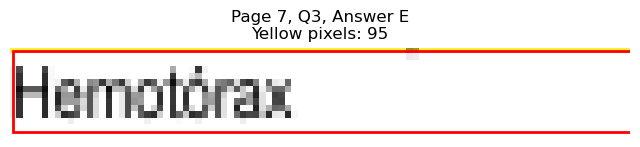


Page 7, Q3 - Selected Answer: D (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=82.5, y0=438.5, x1=169.7, y1=451.2
Page 7, Q4, A: Yellow pixels: 138
Page 7, Q4, A: Total non-white pixels: 592
Page 7, Q4, A: Yellow percentage: 23.3%


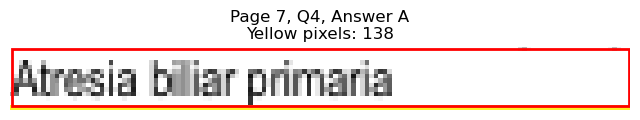

Page 7, Q4 - B: Detected box: x0=82.5, y0=451.1, x1=267.0, y1=463.8
Page 7, Q4, B: Yellow pixels: 1730
Page 7, Q4, B: Total non-white pixels: 2509
Page 7, Q4, B: Yellow percentage: 69.0%


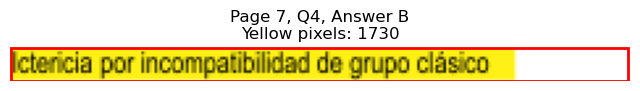

Page 7, Q4 - C: Detected box: x0=82.9, y0=463.7, x1=142.6, y1=476.4
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 322
Page 7, Q4, C: Yellow percentage: 0.0%


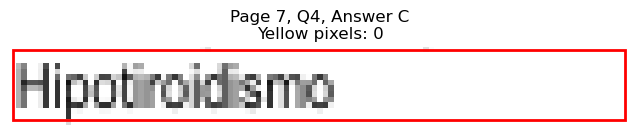

Page 7, Q4 - D: Detected box: x0=334.6, y0=438.5, x1=410.3, y1=451.2
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 420
Page 7, Q4, D: Yellow percentage: 0.0%


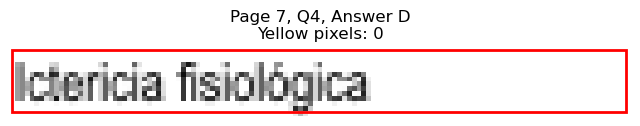

Page 7, Q4 - E: Detected box: x0=334.1, y0=451.1, x1=464.5, y1=463.8
Page 7, Q4, E: Yellow pixels: 0
Page 7, Q4, E: Total non-white pixels: 686
Page 7, Q4, E: Yellow percentage: 0.0%


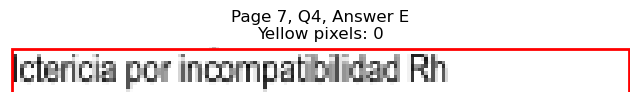


Page 7, Q4 - Selected Answer: B (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=82.5, y0=514.3, x1=115.1, y1=526.9
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 163
Page 7, Q5, A: Yellow percentage: 0.0%


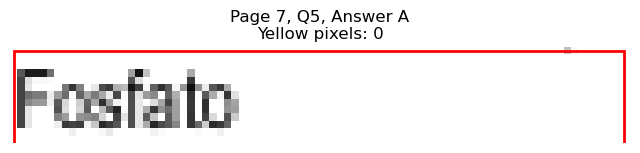

Page 7, Q5 - B: Detected box: x0=82.5, y0=526.9, x1=116.1, y1=539.5
Page 7, Q5, B: Yellow pixels: 85
Page 7, Q5, B: Total non-white pixels: 259
Page 7, Q5, B: Yellow percentage: 32.8%


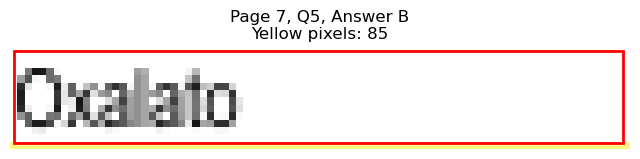

Page 7, Q5 - C: Detected box: x0=82.9, y0=539.5, x1=126.0, y1=552.1
Page 7, Q5, C: Yellow pixels: 1074
Page 7, Q5, C: Total non-white pixels: 1330
Page 7, Q5, C: Yellow percentage: 80.8%


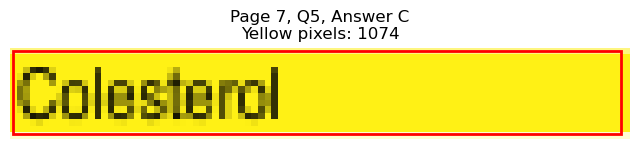

Page 7, Q5 - D: Detected box: x0=334.6, y0=514.3, x1=362.2, y1=526.9
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 144
Page 7, Q5, D: Yellow percentage: 0.0%


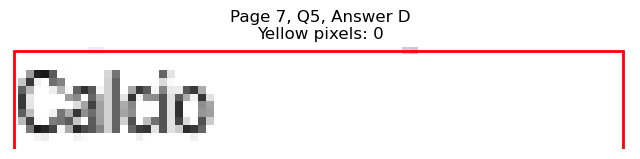

Page 7, Q5 - E: Detected box: x0=334.1, y0=526.9, x1=369.8, y1=539.5
Page 7, Q5, E: Yellow pixels: 0
Page 7, Q5, E: Total non-white pixels: 180
Page 7, Q5, E: Yellow percentage: 0.0%


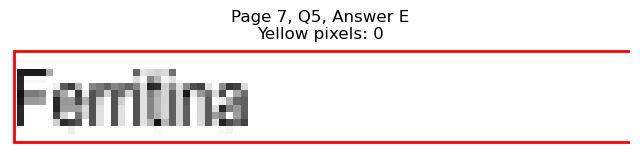


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=82.5, y0=615.2, x1=106.6, y1=627.8
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 119
Page 7, Q6, A: Yellow percentage: 0.0%


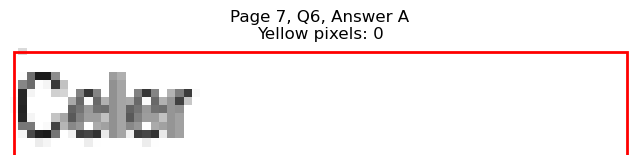

Page 7, Q6 - B: Detected box: x0=82.5, y0=627.9, x1=113.1, y1=640.6
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 150
Page 7, Q6, B: Yellow percentage: 0.0%


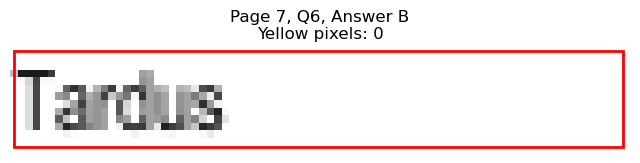

Page 7, Q6 - C: Detected box: x0=82.9, y0=640.5, x1=114.5, y1=653.2
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 156
Page 7, Q6, C: Yellow percentage: 0.0%


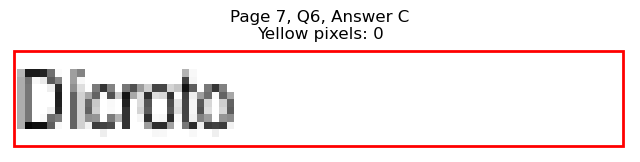

Page 7, Q6 - D: Detected box: x0=334.6, y0=615.2, x1=365.2, y1=627.8
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 142
Page 7, Q6, D: Yellow percentage: 0.0%


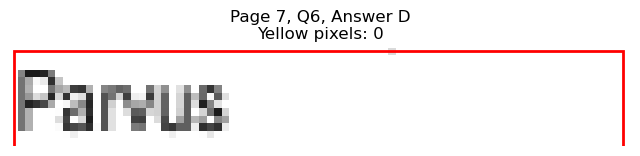

Page 7, Q6 - E: Detected box: x0=334.1, y0=627.9, x1=379.3, y1=640.6
Page 7, Q6, E: Yellow pixels: 1058
Page 7, Q6, E: Total non-white pixels: 1344
Page 7, Q6, E: Yellow percentage: 78.7%


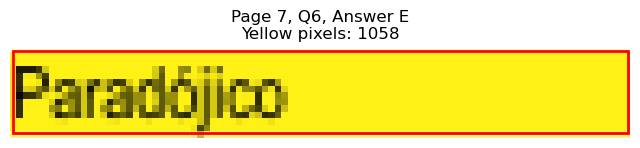


Page 7, Q6 - Selected Answer: E (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=82.5, y0=678.3, x1=112.1, y1=691.0
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 140
Page 7, Q7, A: Yellow percentage: 0.0%


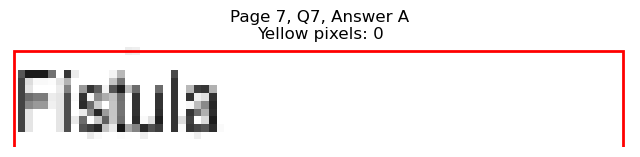

Page 7, Q7 - B: Detected box: x0=82.5, y0=691.1, x1=176.8, y1=703.7
Page 7, Q7, B: Yellow pixels: 1535
Page 7, Q7, B: Total non-white pixels: 1885
Page 7, Q7, B: Yellow percentage: 81.4%


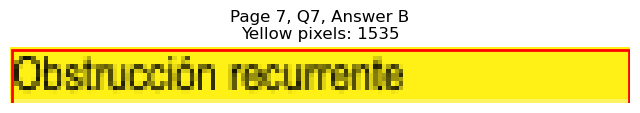

Page 7, Q7 - C: Detected box: x0=82.9, y0=703.7, x1=120.0, y1=716.3
Page 7, Q7, C: Yellow pixels: 89
Page 7, Q7, C: Total non-white pixels: 278
Page 7, Q7, C: Yellow percentage: 32.0%


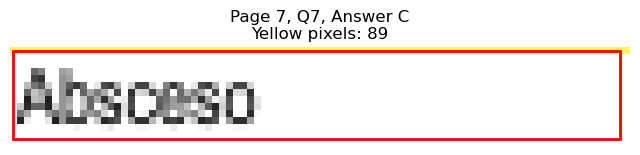

Page 7, Q7 - D: Detected box: x0=334.6, y0=678.3, x1=380.7, y1=691.0
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 226
Page 7, Q7, D: Yellow percentage: 0.0%


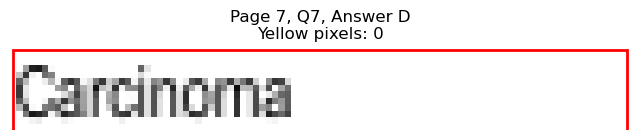

Page 7, Q7 - E: Detected box: x0=334.1, y0=691.1, x1=383.8, y1=703.7
Page 7, Q7, E: Yellow pixels: 0
Page 7, Q7, E: Total non-white pixels: 260
Page 7, Q7, E: Yellow percentage: 0.0%


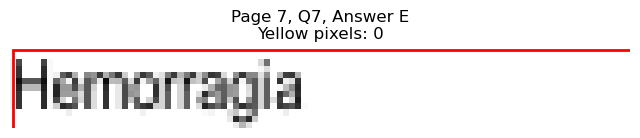


Page 7, Q7 - Selected Answer: B (based on yellow pixel count)





Page 8: Found 8 questions
Page 8, Q1 - A: Detected box: x0=82.5, y0=122.9, x1=208.4, y1=135.6
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 675
Page 8, Q1, A: Yellow percentage: 0.0%


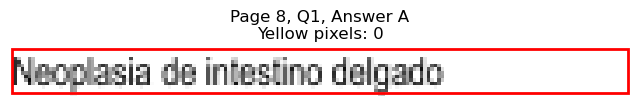

Page 8, Q1 - B: Detected box: x0=82.5, y0=135.5, x1=173.8, y1=148.2
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 466
Page 8, Q1, B: Yellow percentage: 0.0%


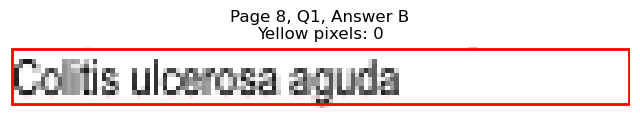

Page 8, Q1 - C: Detected box: x0=82.9, y0=148.2, x1=216.9, y1=160.9
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 703
Page 8, Q1, C: Yellow percentage: 0.0%


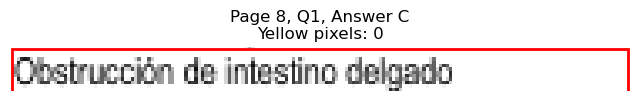

Page 8, Q1 - D: Detected box: x0=334.6, y0=122.9, x1=452.9, y1=135.6
Page 8, Q1, D: Yellow pixels: 1741
Page 8, Q1, D: Total non-white pixels: 2366
Page 8, Q1, D: Yellow percentage: 73.6%


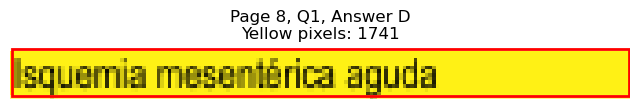

Page 8, Q1 - E: Detected box: x0=334.1, y0=135.5, x1=474.6, y1=148.2
Page 8, Q1, E: Yellow pixels: 189
Page 8, Q1, E: Total non-white pixels: 887
Page 8, Q1, E: Yellow percentage: 21.3%


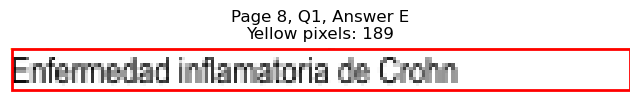


Page 8, Q1 - Selected Answer: D (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=82.5, y0=211.3, x1=193.8, y1=224.0
Page 8, Q2, A: Yellow pixels: 1671
Page 8, Q2, A: Total non-white pixels: 2106
Page 8, Q2, A: Yellow percentage: 79.3%


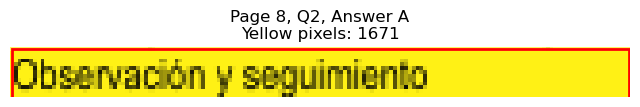

Page 8, Q2 - B: Detected box: x0=82.5, y0=223.9, x1=193.3, y1=236.6
Page 8, Q2, B: Yellow pixels: 156
Page 8, Q2, B: Total non-white pixels: 725
Page 8, Q2, B: Yellow percentage: 21.5%


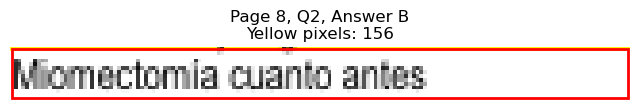

Page 8, Q2 - C: Detected box: x0=82.9, y0=236.5, x1=186.7, y1=249.2
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 515
Page 8, Q2, C: Yellow percentage: 0.0%


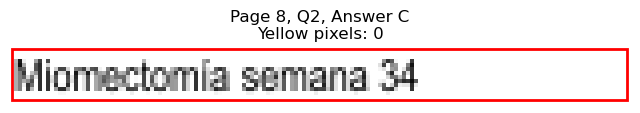

Page 8, Q2 - D: Detected box: x0=334.6, y0=211.3, x1=418.4, y1=224.0
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 412
Page 8, Q2, D: Yellow percentage: 0.0%


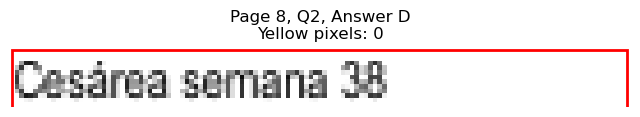

Page 8, Q2 - E: Detected box: x0=334.1, y0=223.9, x1=483.1, y1=236.6
Page 8, Q2, E: Yellow pixels: 0
Page 8, Q2, E: Total non-white pixels: 740
Page 8, Q2, E: Yellow percentage: 0.0%


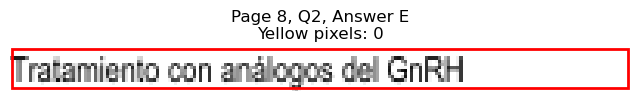


Page 8, Q2 - Selected Answer: A (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=82.5, y0=299.7, x1=165.7, y1=312.3
Page 8, Q3, A: Yellow pixels: 1292
Page 8, Q3, A: Total non-white pixels: 1876
Page 8, Q3, A: Yellow percentage: 68.9%


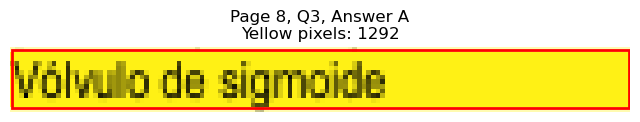

Page 8, Q3 - B: Detected box: x0=82.5, y0=312.3, x1=169.7, y1=324.9
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 580
Page 8, Q3, B: Yellow percentage: 0.0%


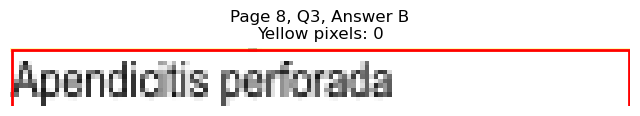

Page 8, Q3 - C: Detected box: x0=82.9, y0=324.9, x1=169.2, y1=337.5
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 456
Page 8, Q3, C: Yellow percentage: 0.0%


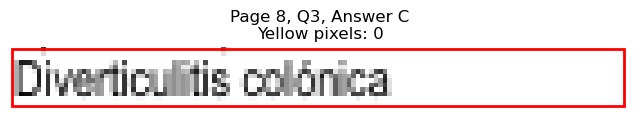

Page 8, Q3 - D: Detected box: x0=334.6, y0=299.7, x1=418.9, y1=312.3
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 404
Page 8, Q3, D: Yellow percentage: 0.0%


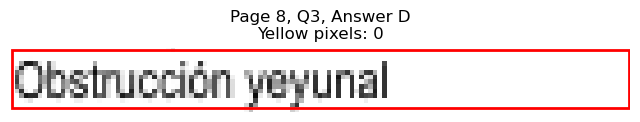

Page 8, Q3 - E: Detected box: x0=334.1, y0=312.3, x1=415.4, y1=324.9
Page 8, Q3, E: Yellow pixels: 0
Page 8, Q3, E: Total non-white pixels: 419
Page 8, Q3, E: Yellow percentage: 0.0%


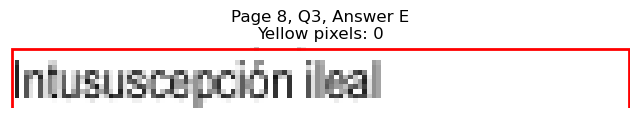


Page 8, Q3 - Selected Answer: A (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=82.5, y0=375.4, x1=125.1, y1=388.1
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 220
Page 8, Q4, A: Yellow percentage: 0.0%


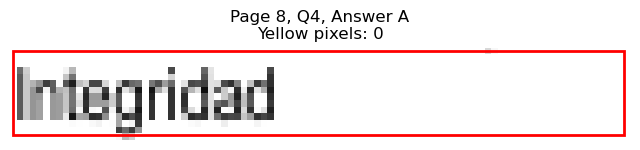

Page 8, Q4 - B: Detected box: x0=82.5, y0=388.0, x1=130.1, y1=400.7
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 231
Page 8, Q4, B: Yellow percentage: 0.0%


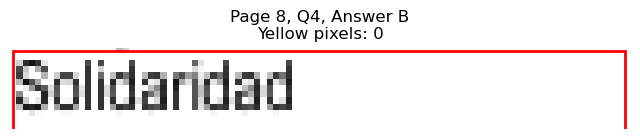

Page 8, Q4 - C: Detected box: x0=82.9, y0=400.6, x1=123.0, y1=413.3
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 202
Page 8, Q4, C: Yellow percentage: 0.0%


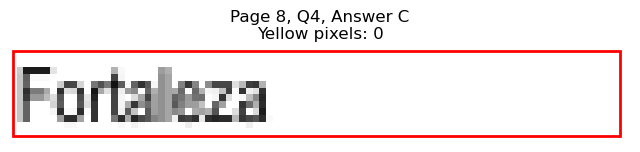

Page 8, Q4 - D: Detected box: x0=334.6, y0=375.4, x1=371.7, y1=388.1
Page 8, Q4, D: Yellow pixels: 999
Page 8, Q4, D: Total non-white pixels: 1232
Page 8, Q4, D: Yellow percentage: 81.1%


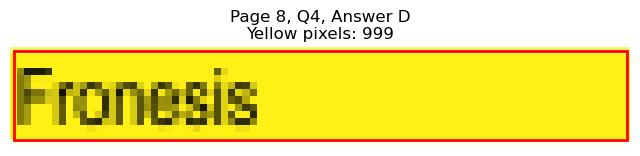

Page 8, Q4 - E: Detected box: x0=334.1, y0=388.0, x1=381.3, y1=400.7
Page 8, Q4, E: Yellow pixels: 0
Page 8, Q4, E: Total non-white pixels: 334
Page 8, Q4, E: Yellow percentage: 0.0%


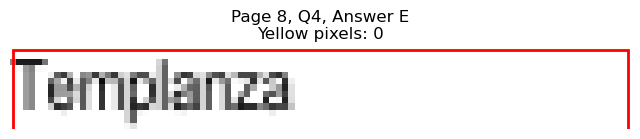


Page 8, Q4 - Selected Answer: D (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=82.5, y0=463.7, x1=175.2, y1=476.4
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 477
Page 8, Q5, A: Yellow percentage: 0.0%


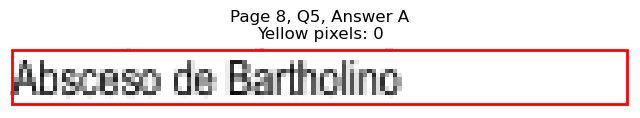

Page 8, Q5 - B: Detected box: x0=82.5, y0=476.3, x1=131.1, y1=489.0
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 244
Page 8, Q5, B: Yellow percentage: 0.0%


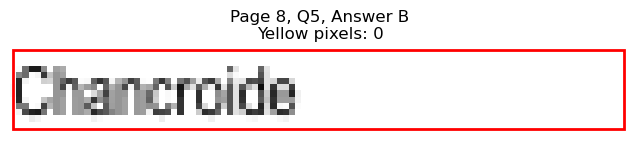

Page 8, Q5 - C: Detected box: x0=82.9, y0=489.1, x1=182.8, y1=501.7
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 489
Page 8, Q5, C: Yellow percentage: 0.0%


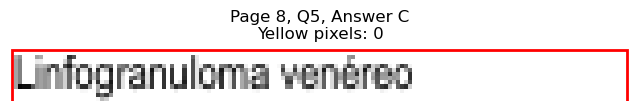

Page 8, Q5 - D: Detected box: x0=334.6, y0=463.7, x1=395.3, y1=476.4
Page 8, Q5, D: Yellow pixels: 112
Page 8, Q5, D: Total non-white pixels: 435
Page 8, Q5, D: Yellow percentage: 25.7%


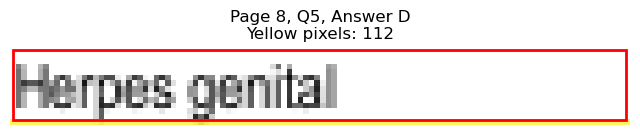

Page 8, Q5 - E: Detected box: x0=334.1, y0=476.3, x1=358.3, y1=489.0
Page 8, Q5, E: Yellow pixels: 865
Page 8, Q5, E: Total non-white pixels: 1050
Page 8, Q5, E: Yellow percentage: 82.4%


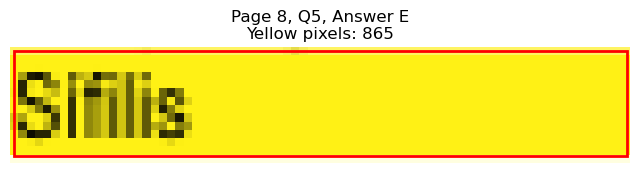


Page 8, Q5 - Selected Answer: E (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=82.5, y0=526.9, x1=175.7, y1=539.5
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 477
Page 8, Q6, A: Yellow percentage: 0.0%


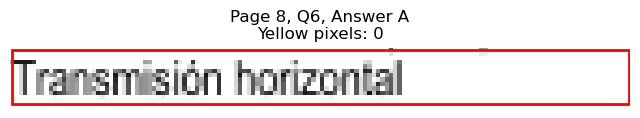

Page 8, Q6 - B: Detected box: x0=82.5, y0=539.5, x1=176.8, y1=552.1
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 491
Page 8, Q6, B: Yellow percentage: 0.0%


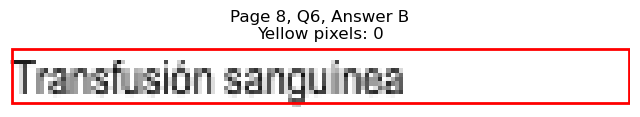

Page 8, Q6 - C: Detected box: x0=82.9, y0=552.2, x1=159.7, y1=564.8
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 375
Page 8, Q6, C: Yellow percentage: 0.0%


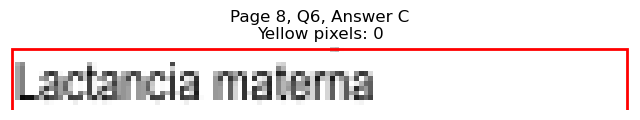

Page 8, Q6 - D: Detected box: x0=334.6, y0=526.9, x1=393.8, y1=539.5
Page 8, Q6, D: Yellow pixels: 110
Page 8, Q6, D: Total non-white pixels: 407
Page 8, Q6, D: Yellow percentage: 27.0%


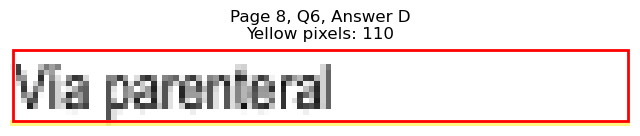

Page 8, Q6 - E: Detected box: x0=334.1, y0=539.5, x1=366.8, y1=552.1
Page 8, Q6, E: Yellow pixels: 951
Page 8, Q6, E: Total non-white pixels: 1162
Page 8, Q6, E: Yellow percentage: 81.8%


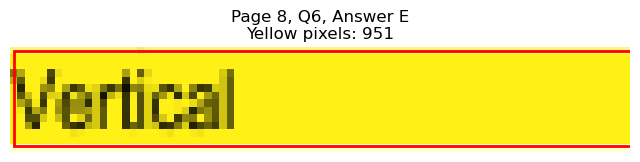


Page 8, Q6 - Selected Answer: E (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=82.5, y0=627.9, x1=152.2, y1=640.6
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 377
Page 8, Q7, A: Yellow percentage: 0.0%


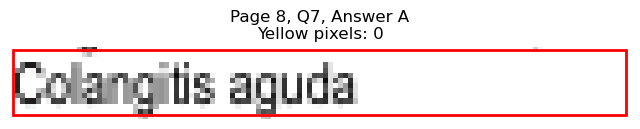

Page 8, Q7 - B: Detected box: x0=82.5, y0=640.5, x1=147.6, y1=653.2
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 355
Page 8, Q7, B: Yellow percentage: 0.0%


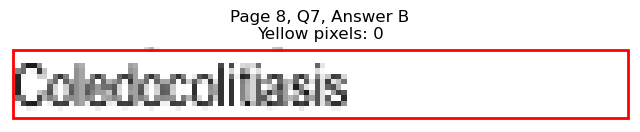

Page 8, Q7 - C: Detected box: x0=82.9, y0=653.1, x1=212.3, y1=665.8
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 694
Page 8, Q7, C: Yellow percentage: 0.0%


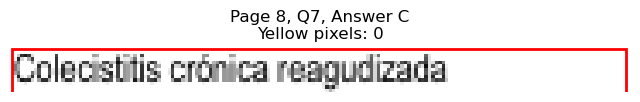

Page 8, Q7 - D: Detected box: x0=334.6, y0=627.9, x1=397.9, y1=640.6
Page 8, Q7, D: Yellow pixels: 114
Page 8, Q7, D: Total non-white pixels: 455
Page 8, Q7, D: Yellow percentage: 25.1%


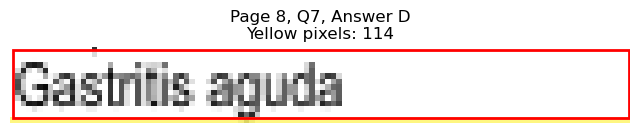

Page 8, Q7 - E: Detected box: x0=334.1, y0=640.5, x1=407.3, y1=653.2
Page 8, Q7, E: Yellow pixels: 1325
Page 8, Q7, E: Total non-white pixels: 1736
Page 8, Q7, E: Yellow percentage: 76.3%


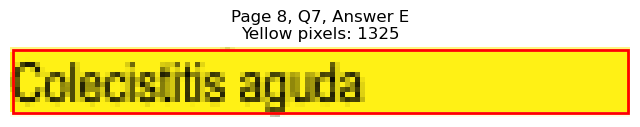


Page 8, Q7 - Selected Answer: E (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=82.5, y0=703.7, x1=157.7, y1=716.3
Page 8, Q8, A: Yellow pixels: 126
Page 8, Q8, A: Total non-white pixels: 521
Page 8, Q8, A: Yellow percentage: 24.2%


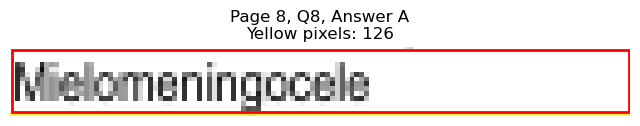

Page 8, Q8 - B: Detected box: x0=82.5, y0=716.3, x1=167.8, y1=728.9
Page 8, Q8, B: Yellow pixels: 1444
Page 8, Q8, B: Total non-white pixels: 1768
Page 8, Q8, B: Yellow percentage: 81.7%


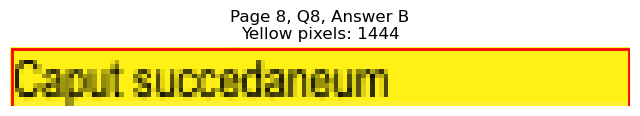

Page 8, Q8 - C: Detected box: x0=82.9, y0=728.9, x1=269.4, y1=741.5
Page 8, Q8, C: Yellow pixels: 190
Page 8, Q8, C: Total non-white pixels: 1160
Page 8, Q8, C: Yellow percentage: 16.4%


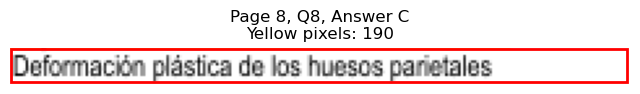

Page 8, Q8 - D: Detected box: x0=334.6, y0=703.7, x1=414.9, y1=716.3
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 438
Page 8, Q8, D: Yellow percentage: 0.0%


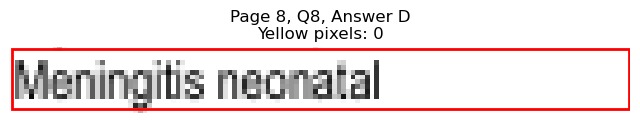

Page 8, Q8 - E: Detected box: x0=334.1, y0=716.3, x1=405.3, y1=728.9
Page 8, Q8, E: Yellow pixels: 0
Page 8, Q8, E: Total non-white pixels: 383
Page 8, Q8, E: Yellow percentage: 0.0%


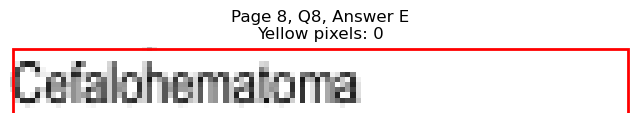


Page 8, Q8 - Selected Answer: B (based on yellow pixel count)





Page 9: Found 10 questions
Page 9, Q1 - A: Detected box: x0=82.5, y0=97.7, x1=128.7, y1=110.4
Page 9, Q1, A: Yellow pixels: 986
Page 9, Q1, A: Total non-white pixels: 1358
Page 9, Q1, A: Yellow percentage: 72.6%


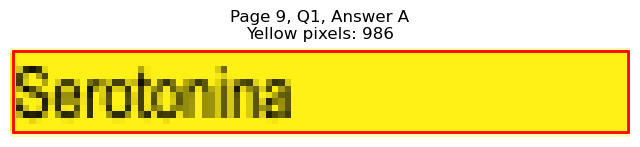

Page 9, Q1 - B: Detected box: x0=82.5, y0=110.3, x1=112.6, y1=123.0
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 225
Page 9, Q1, B: Yellow percentage: 0.0%


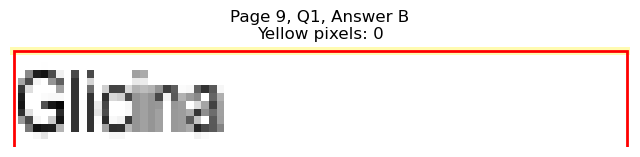

Page 9, Q1 - C: Detected box: x0=82.9, y0=122.9, x1=126.6, y1=135.6
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 219
Page 9, Q1, C: Yellow percentage: 0.0%


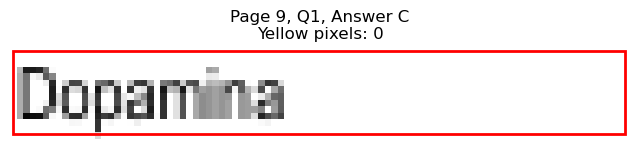

Page 9, Q1 - D: Detected box: x0=334.6, y0=97.7, x1=378.8, y1=110.4
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 240
Page 9, Q1, D: Yellow percentage: 0.0%


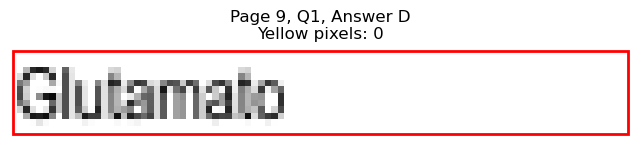

Page 9, Q1 - E: Detected box: x0=334.1, y0=110.3, x1=382.3, y1=123.0
Page 9, Q1, E: Yellow pixels: 0
Page 9, Q1, E: Total non-white pixels: 263
Page 9, Q1, E: Yellow percentage: 0.0%


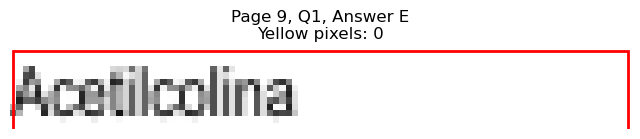


Page 9, Q1 - Selected Answer: A (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=82.5, y0=186.0, x1=168.7, y1=198.7
Page 9, Q2, A: Yellow pixels: 2
Page 9, Q2, A: Total non-white pixels: 546
Page 9, Q2, A: Yellow percentage: 0.4%


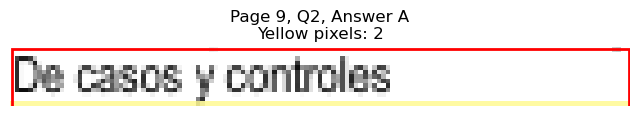

Page 9, Q2 - B: Detected box: x0=82.5, y0=198.6, x1=133.6, y1=211.3
Page 9, Q2, B: Yellow pixels: 1028
Page 9, Q2, B: Total non-white pixels: 1428
Page 9, Q2, B: Yellow percentage: 72.0%


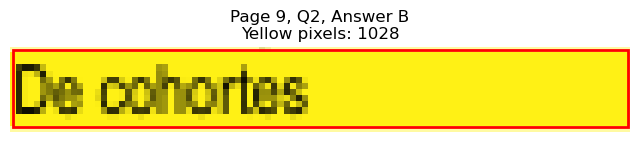

Page 9, Q2 - C: Detected box: x0=82.9, y0=211.3, x1=162.6, y1=224.0
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 540
Page 9, Q2, C: Yellow percentage: 0.0%


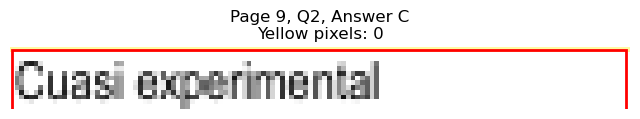

Page 9, Q2 - D: Detected box: x0=334.6, y0=186.0, x1=381.9, y1=198.7
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 243
Page 9, Q2, D: Yellow percentage: 0.0%


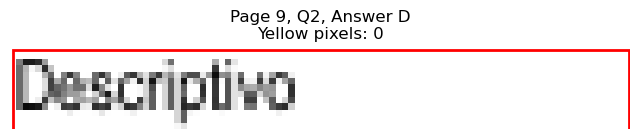

Page 9, Q2 - E: Detected box: x0=334.1, y0=198.6, x1=383.8, y1=211.3
Page 9, Q2, E: Yellow pixels: 0
Page 9, Q2, E: Total non-white pixels: 245
Page 9, Q2, E: Yellow percentage: 0.0%


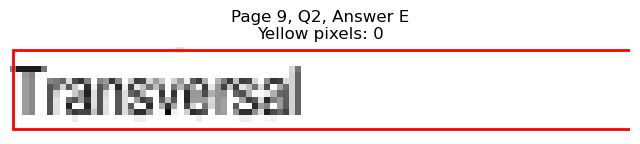


Page 9, Q2 - Selected Answer: B (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=82.5, y0=274.5, x1=126.6, y1=287.1
Page 9, Q3, A: Yellow pixels: 1057
Page 9, Q3, A: Total non-white pixels: 1330
Page 9, Q3, A: Yellow percentage: 79.5%


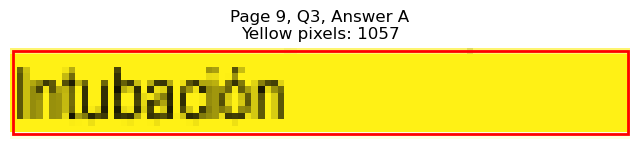

Page 9, Q3 - B: Detected box: x0=82.5, y0=287.1, x1=140.2, y1=299.7
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 394
Page 9, Q3, B: Yellow percentage: 0.0%


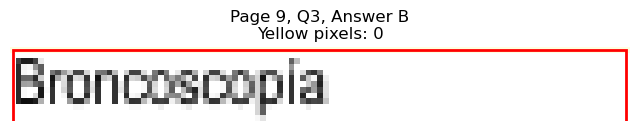

Page 9, Q3 - C: Detected box: x0=82.9, y0=299.7, x1=142.6, y1=312.3
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 307
Page 9, Q3, C: Yellow percentage: 0.0%


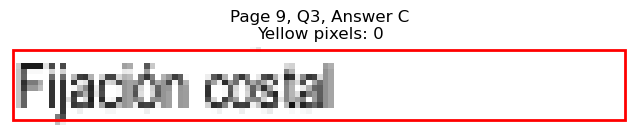

Page 9, Q3 - D: Detected box: x0=334.6, y0=274.5, x1=392.3, y1=287.1
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 264
Page 9, Q3, D: Yellow percentage: 0.0%


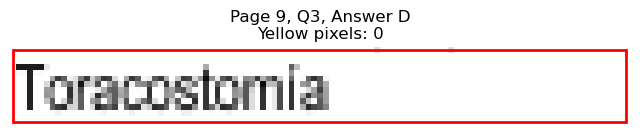

Page 9, Q3 - E: Detected box: x0=334.1, y0=287.1, x1=404.8, y1=299.7
Page 9, Q3, E: Yellow pixels: 0
Page 9, Q3, E: Total non-white pixels: 370
Page 9, Q3, E: Yellow percentage: 0.0%


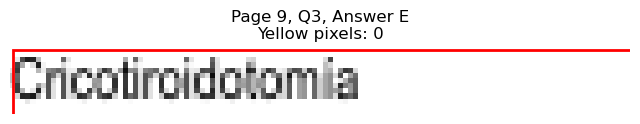


Page 9, Q3 - Selected Answer: A (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=82.5, y0=337.5, x1=193.8, y1=350.1
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 568
Page 9, Q4, A: Yellow percentage: 0.0%


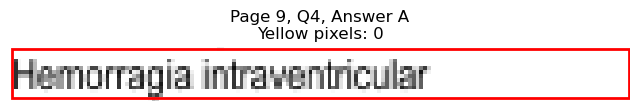

Page 9, Q4 - B: Detected box: x0=82.5, y0=350.2, x1=207.9, y1=362.9
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 666
Page 9, Q4, B: Yellow percentage: 0.0%


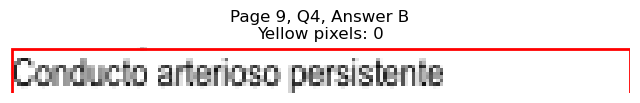

Page 9, Q4 - C: Detected box: x0=82.9, y0=362.8, x1=186.3, y1=375.5
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 530
Page 9, Q4, C: Yellow percentage: 0.0%


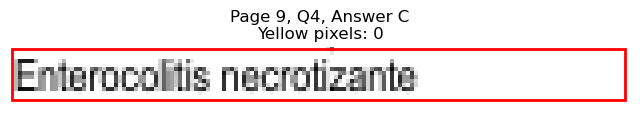

Page 9, Q4 - D: Detected box: x0=334.6, y0=337.5, x1=441.4, y1=350.1
Page 9, Q4, D: Yellow pixels: 1624
Page 9, Q4, D: Total non-white pixels: 2212
Page 9, Q4, D: Yellow percentage: 73.4%


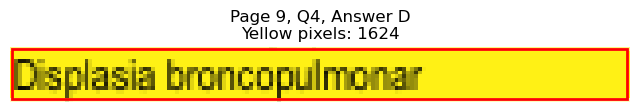

Page 9, Q4 - E: Detected box: x0=334.1, y0=350.2, x1=384.8, y1=362.9
Page 9, Q4, E: Yellow pixels: 0
Page 9, Q4, E: Total non-white pixels: 387
Page 9, Q4, E: Yellow percentage: 0.0%


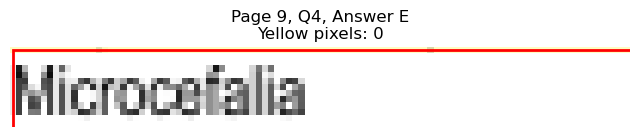


Page 9, Q4 - Selected Answer: D (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=82.5, y0=413.3, x1=198.4, y1=426.0
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 596
Page 9, Q5, A: Yellow percentage: 0.0%


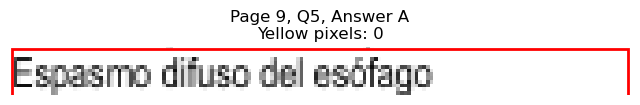

Page 9, Q5 - B: Detected box: x0=82.5, y0=425.9, x1=155.2, y1=438.6
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 390
Page 9, Q5, B: Yellow percentage: 0.0%


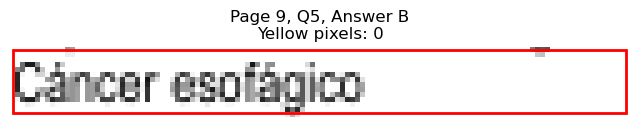

Page 9, Q5 - C: Detected box: x0=82.9, y0=438.5, x1=193.7, y1=451.2
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 524
Page 9, Q5, C: Yellow percentage: 0.0%


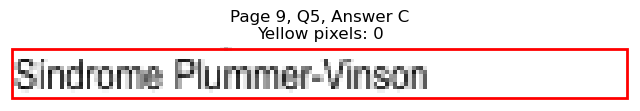

Page 9, Q5 - D: Detected box: x0=334.6, y0=413.3, x1=371.2, y1=426.0
Page 9, Q5, D: Yellow pixels: 1001
Page 9, Q5, D: Total non-white pixels: 1144
Page 9, Q5, D: Yellow percentage: 87.5%


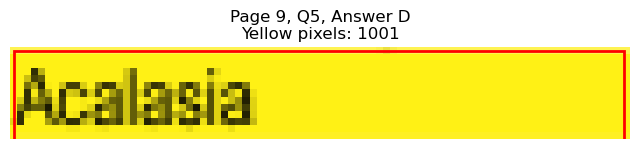

Page 9, Q5 - E: Detected box: x0=334.1, y0=425.9, x1=409.4, y1=438.6
Page 9, Q5, E: Yellow pixels: 126
Page 9, Q5, E: Total non-white pixels: 516
Page 9, Q5, E: Yellow percentage: 24.4%


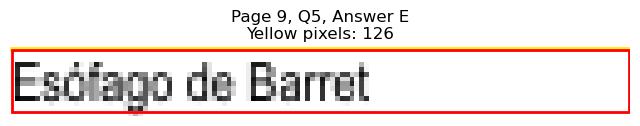


Page 9, Q5 - Selected Answer: D (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=82.5, y0=476.3, x1=147.1, y1=489.0
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 324
Page 9, Q6, A: Yellow percentage: 0.0%


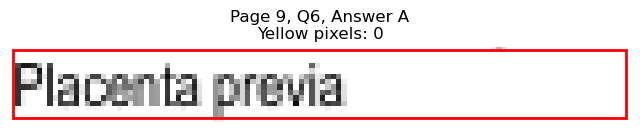

Page 9, Q6 - B: Detected box: x0=82.5, y0=489.1, x1=138.6, y1=501.7
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 291
Page 9, Q6, B: Yellow percentage: 0.0%


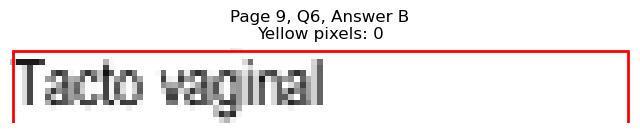

Page 9, Q6 - C: Detected box: x0=82.9, y0=501.7, x1=161.7, y1=514.3
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 387
Page 9, Q6, C: Yellow percentage: 0.0%


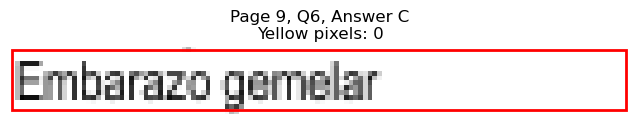

Page 9, Q6 - D: Detected box: x0=334.6, y0=476.3, x1=451.0, y1=489.0
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 565
Page 9, Q6, D: Yellow percentage: 0.0%


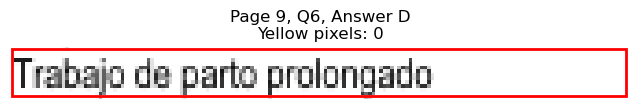

Page 9, Q6 - E: Detected box: x0=334.1, y0=489.1, x1=408.4, y1=501.7
Page 9, Q6, E: Yellow pixels: 1339
Page 9, Q6, E: Total non-white pixels: 1625
Page 9, Q6, E: Yellow percentage: 82.4%


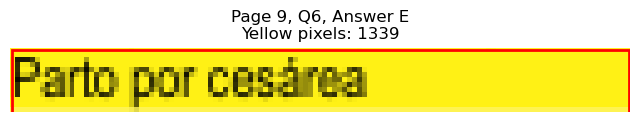


Page 9, Q6 - Selected Answer: E (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=82.5, y0=539.5, x1=185.3, y1=552.1
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 529
Page 9, Q7, A: Yellow percentage: 0.0%


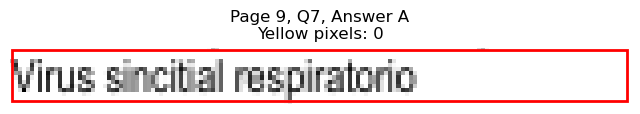

Page 9, Q7 - B: Detected box: x0=82.5, y0=552.2, x1=190.8, y1=564.8
Page 9, Q7, B: Yellow pixels: 1642
Page 9, Q7, B: Total non-white pixels: 2067
Page 9, Q7, B: Yellow percentage: 79.4%


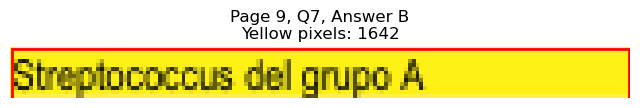

Page 9, Q7 - C: Detected box: x0=82.9, y0=564.8, x1=147.6, y1=577.4
Page 9, Q7, C: Yellow pixels: 109
Page 9, Q7, C: Total non-white pixels: 441
Page 9, Q7, C: Yellow percentage: 24.7%


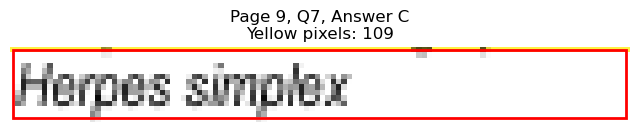

Page 9, Q7 - D: Detected box: x0=334.6, y0=539.5, x1=399.8, y1=552.1
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 332
Page 9, Q7, D: Yellow percentage: 0.0%


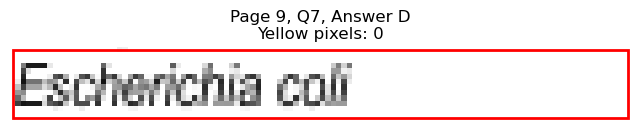

Page 9, Q7 - E: Detected box: x0=334.1, y0=552.2, x1=428.5, y1=564.8
Page 9, Q7, E: Yellow pixels: 0
Page 9, Q7, E: Total non-white pixels: 487
Page 9, Q7, E: Yellow percentage: 0.0%


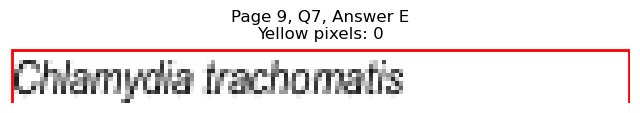


Page 9, Q7 - Selected Answer: B (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=82.5, y0=602.6, x1=189.3, y1=615.2
Page 9, Q8, A: Yellow pixels: 1630
Page 9, Q8, A: Total non-white pixels: 2212
Page 9, Q8, A: Yellow percentage: 73.7%


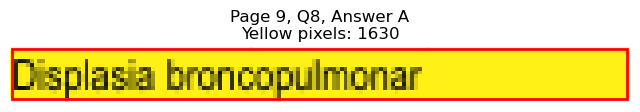

Page 9, Q8 - B: Detected box: x0=82.5, y0=615.2, x1=148.7, y1=627.8
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 451
Page 9, Q8, B: Yellow percentage: 0.0%


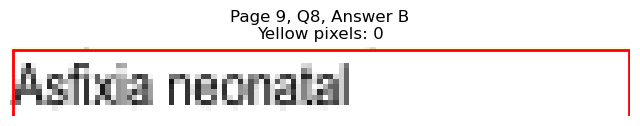

Page 9, Q8 - C: Detected box: x0=82.9, y0=627.9, x1=182.2, y1=640.6
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 511
Page 9, Q8, C: Yellow percentage: 0.0%


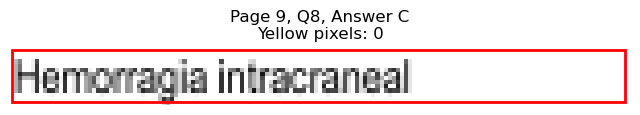

Page 9, Q8 - D: Detected box: x0=334.6, y0=602.6, x1=421.9, y1=615.2
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 450
Page 9, Q8, D: Yellow percentage: 0.0%


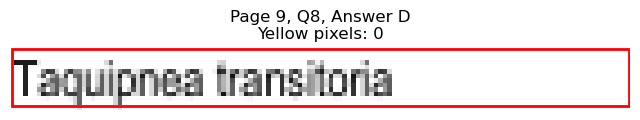

Page 9, Q8 - E: Detected box: x0=334.1, y0=615.2, x1=437.5, y1=627.8
Page 9, Q8, E: Yellow pixels: 0
Page 9, Q8, E: Total non-white pixels: 516
Page 9, Q8, E: Yellow percentage: 0.0%


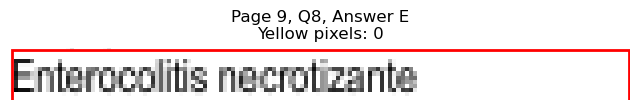


Page 9, Q8 - Selected Answer: A (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=82.5, y0=665.7, x1=197.9, y1=678.4
Page 9, Q9, A: Yellow pixels: 1466
Page 9, Q9, A: Total non-white pixels: 2324
Page 9, Q9, A: Yellow percentage: 63.1%


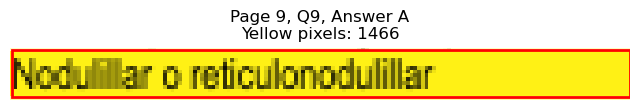

Page 9, Q9 - B: Detected box: x0=82.5, y0=678.3, x1=118.6, y1=691.0
Page 9, Q9, B: Yellow pixels: 0
Page 9, Q9, B: Total non-white pixels: 248
Page 9, Q9, B: Yellow percentage: 0.0%


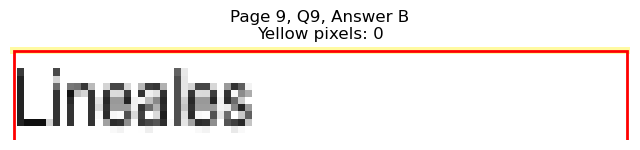

Page 9, Q9 - C: Detected box: x0=82.9, y0=691.1, x1=155.2, y1=703.7
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 368
Page 9, Q9, C: Yellow percentage: 0.0%


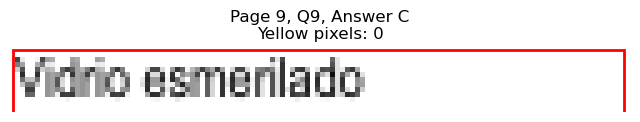

Page 9, Q9 - D: Detected box: x0=334.6, y0=665.7, x1=375.3, y1=678.4
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 212
Page 9, Q9, D: Yellow percentage: 0.0%


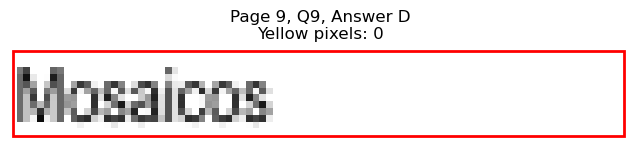

Page 9, Q9 - E: Detected box: x0=334.1, y0=678.3, x1=423.9, y1=691.0
Page 9, Q9, E: Yellow pixels: 0
Page 9, Q9, E: Total non-white pixels: 472
Page 9, Q9, E: Yellow percentage: 0.0%


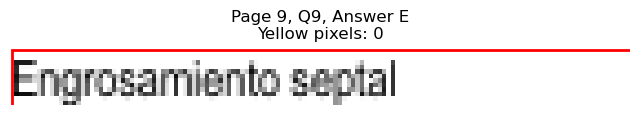


Page 9, Q9 - Selected Answer: A (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=82.5, y0=728.9, x1=158.2, y1=741.5
Page 9, Q10, A: Yellow pixels: 1368
Page 9, Q10, A: Total non-white pixels: 1778
Page 9, Q10, A: Yellow percentage: 76.9%


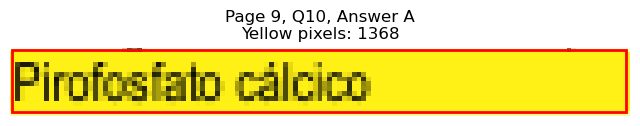

Page 9, Q10 - B: Detected box: x0=82.5, y0=741.4, x1=170.2, y1=754.1
Page 9, Q10, B: Yellow pixels: 139
Page 9, Q10, B: Total non-white pixels: 608
Page 9, Q10, B: Yellow percentage: 22.9%


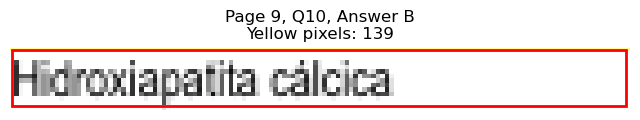

Page 9, Q10 - C: Detected box: x0=82.9, y0=754.0, x1=126.0, y1=766.7
Page 9, Q10, C: Yellow pixels: 0
Page 9, Q10, C: Total non-white pixels: 219
Page 9, Q10, C: Yellow percentage: 0.0%


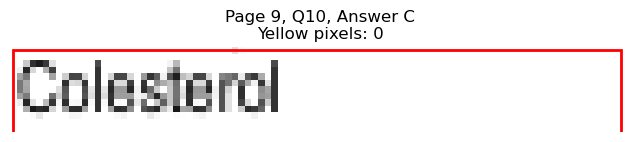

Page 9, Q10 - D: Detected box: x0=334.6, y0=728.9, x1=398.3, y1=741.5
Page 9, Q10, D: Yellow pixels: 0
Page 9, Q10, D: Total non-white pixels: 323
Page 9, Q10, D: Yellow percentage: 0.0%


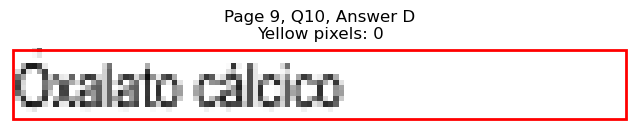

Page 9, Q10 - E: Detected box: x0=334.1, y0=741.4, x1=425.5, y1=754.1
Page 9, Q10, E: Yellow pixels: 0
Page 9, Q10, E: Total non-white pixels: 483
Page 9, Q10, E: Yellow percentage: 0.0%


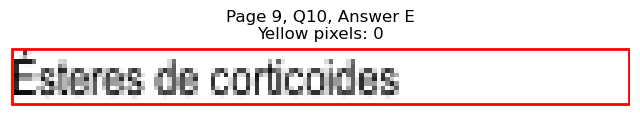


Page 9, Q10 - Selected Answer: A (based on yellow pixel count)





Page 10: Found 7 questions
Page 10, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=121.6, y1=123.0
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 187
Page 10, Q1, A: Yellow percentage: 0.0%


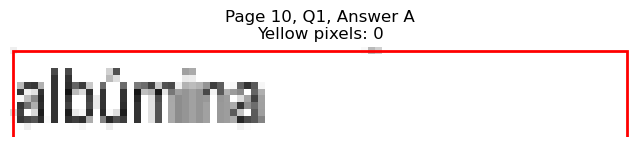

Page 10, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=144.9, y1=135.6
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 324
Page 10, Q1, B: Yellow percentage: 0.0%


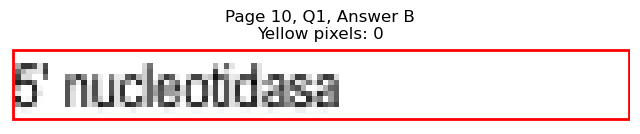

Page 10, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=155.2, y1=148.2
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 392
Page 10, Q1, C: Yellow percentage: 0.0%


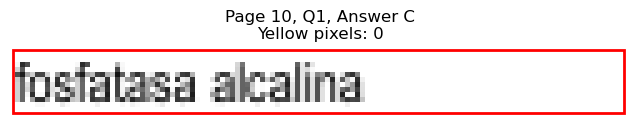

Page 10, Q1 - D: Detected box: x0=334.6, y0=110.3, x1=438.4, y1=123.0
Page 10, Q1, D: Yellow pixels: 1632
Page 10, Q1, D: Total non-white pixels: 2015
Page 10, Q1, D: Yellow percentage: 81.0%


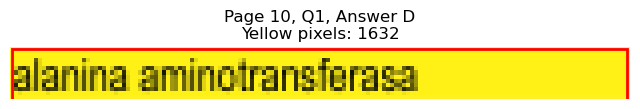

Page 10, Q1 - E: Detected box: x0=334.1, y0=122.9, x1=462.1, y1=135.6
Page 10, Q1, E: Yellow pixels: 179
Page 10, Q1, E: Total non-white pixels: 866
Page 10, Q1, E: Yellow percentage: 20.7%


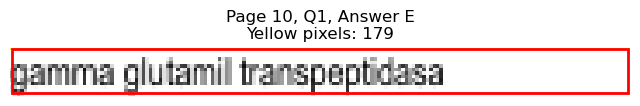


Page 10, Q1 - Selected Answer: D (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=82.5, y0=198.6, x1=133.1, y1=211.3
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 264
Page 10, Q2, A: Yellow percentage: 0.0%


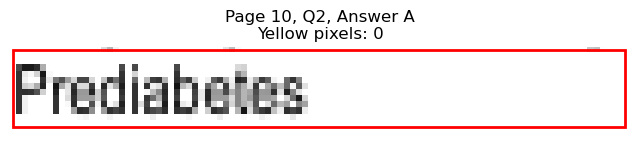

Page 10, Q2 - B: Detected box: x0=82.5, y0=211.3, x1=142.7, y1=224.0
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 424
Page 10, Q2, B: Yellow percentage: 0.0%


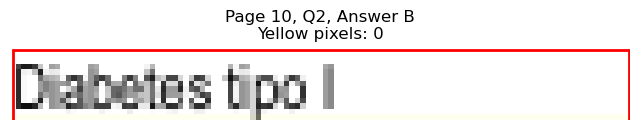

Page 10, Q2 - C: Detected box: x0=82.9, y0=223.9, x1=169.2, y1=236.6
Page 10, Q2, C: Yellow pixels: 1447
Page 10, Q2, C: Total non-white pixels: 1932
Page 10, Q2, C: Yellow percentage: 74.9%


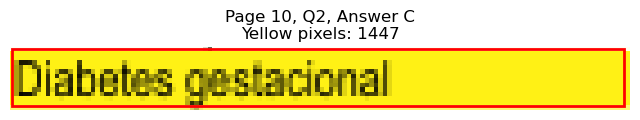

Page 10, Q2 - D: Detected box: x0=334.6, y0=198.6, x1=433.9, y1=211.3
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 521
Page 10, Q2, D: Yellow percentage: 0.0%


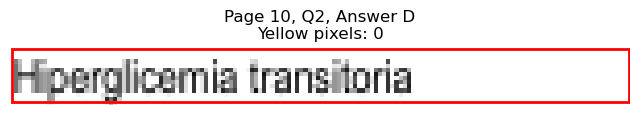

Page 10, Q2 - E: Detected box: x0=334.1, y0=211.3, x1=400.4, y1=224.0
Page 10, Q2, E: Yellow pixels: 0
Page 10, Q2, E: Total non-white pixels: 370
Page 10, Q2, E: Yellow percentage: 0.0%


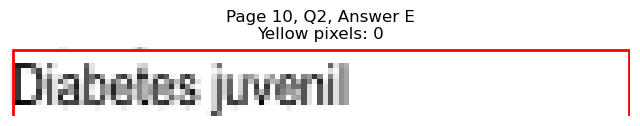


Page 10, Q2 - Selected Answer: C (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=82.5, y0=312.3, x1=125.1, y1=324.9
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 196
Page 10, Q3, A: Yellow percentage: 0.0%


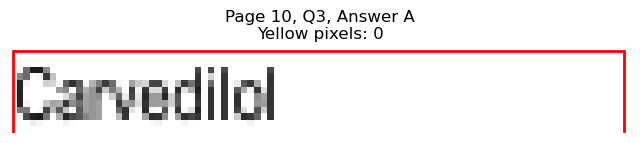

Page 10, Q3 - B: Detected box: x0=82.5, y0=324.9, x1=125.1, y1=337.5
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 217
Page 10, Q3, B: Yellow percentage: 0.0%


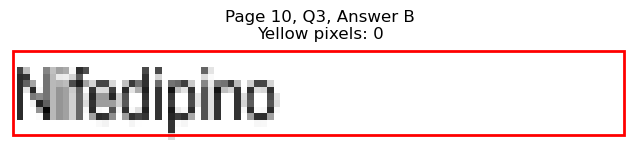

Page 10, Q3 - C: Detected box: x0=82.9, y0=337.5, x1=118.1, y1=350.1
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 175
Page 10, Q3, C: Yellow percentage: 0.0%


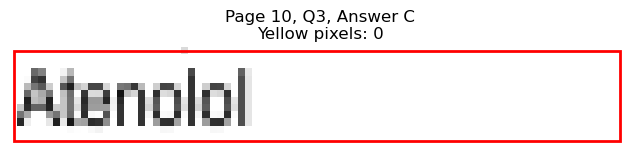

Page 10, Q3 - D: Detected box: x0=334.6, y0=312.3, x1=373.3, y1=324.9
Page 10, Q3, D: Yellow pixels: 1018
Page 10, Q3, D: Total non-white pixels: 1170
Page 10, Q3, D: Yellow percentage: 87.0%


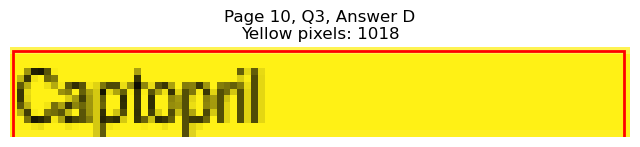

Page 10, Q3 - E: Detected box: x0=334.1, y0=324.9, x1=377.2, y1=337.5
Page 10, Q3, E: Yellow pixels: 91
Page 10, Q3, E: Total non-white pixels: 328
Page 10, Q3, E: Yellow percentage: 27.7%


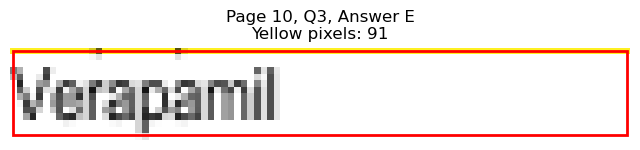


Page 10, Q3 - Selected Answer: D (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=82.5, y0=375.4, x1=231.5, y1=388.1
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 747
Page 10, Q4, A: Yellow percentage: 0.0%


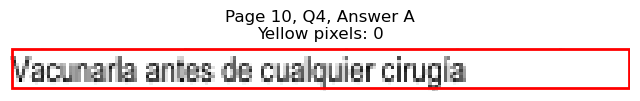

Page 10, Q4 - B: Detected box: x0=82.5, y0=388.0, x1=275.3, y1=400.7
Page 10, Q4, B: Yellow pixels: 49
Page 10, Q4, B: Total non-white pixels: 1007
Page 10, Q4, B: Yellow percentage: 4.9%


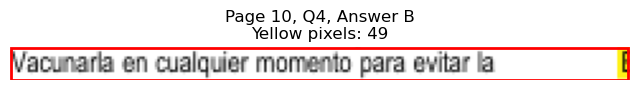

Page 10, Q4 - C: Detected box: x0=82.9, y0=413.3, x1=256.0, y1=426.0
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 829
Page 10, Q4, C: Yellow percentage: 0.0%


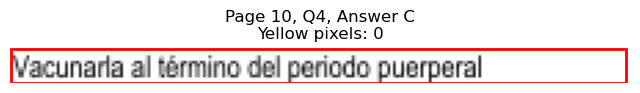

Page 10, Q4 - D: Detected box: x0=334.6, y0=375.4, x1=524.3, y1=388.1
Page 10, Q4, D: Yellow pixels: 192
Page 10, Q4, D: Total non-white pixels: 1117
Page 10, Q4, D: Yellow percentage: 17.2%


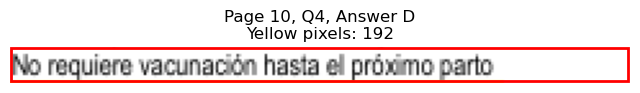

Page 10, Q4 - E: Detected box: x0=334.1, y0=388.0, x1=512.3, y1=400.7
Page 10, Q4, E: Yellow pixels: 1859
Page 10, Q4, E: Total non-white pixels: 2496
Page 10, Q4, E: Yellow percentage: 74.5%


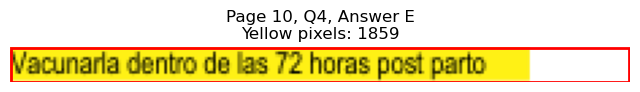


Page 10, Q4 - Selected Answer: E (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=82.5, y0=476.3, x1=181.8, y1=489.0
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 479
Page 10, Q5, A: Yellow percentage: 0.0%


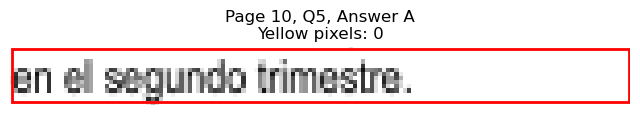

Page 10, Q5 - B: Detected box: x0=82.5, y0=489.1, x1=184.3, y1=501.7
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 466
Page 10, Q5, B: Yellow percentage: 0.0%


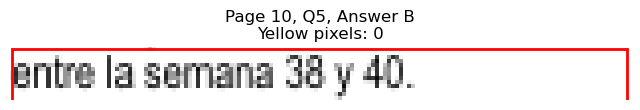

Page 10, Q5 - C: Detected box: x0=82.9, y0=501.7, x1=159.7, y1=514.3
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 367
Page 10, Q5, C: Yellow percentage: 0.0%


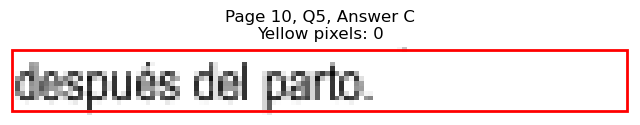

Page 10, Q5 - D: Detected box: x0=334.6, y0=476.3, x1=436.5, y1=489.0
Page 10, Q5, D: Yellow pixels: 1641
Page 10, Q5, D: Total non-white pixels: 2142
Page 10, Q5, D: Yellow percentage: 76.6%


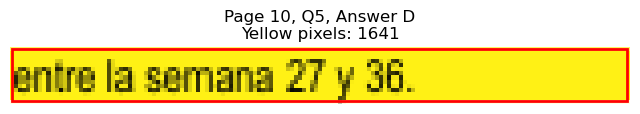

Page 10, Q5 - E: Detected box: x0=334.1, y0=489.1, x1=403.4, y1=501.7
Page 10, Q5, E: Yellow pixels: 0
Page 10, Q5, E: Total non-white pixels: 496
Page 10, Q5, E: Yellow percentage: 0.0%


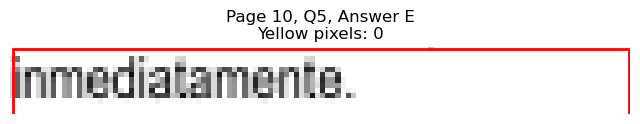


Page 10, Q5 - Selected Answer: D (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=82.5, y0=564.8, x1=175.7, y1=577.4
Page 10, Q6, A: Yellow pixels: 1344
Page 10, Q6, A: Total non-white pixels: 2016
Page 10, Q6, A: Yellow percentage: 66.7%


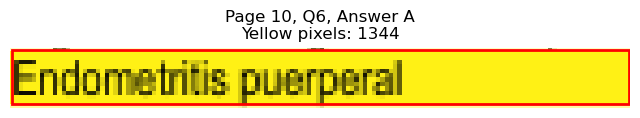

Page 10, Q6 - B: Detected box: x0=82.5, y0=577.4, x1=126.6, y1=590.0
Page 10, Q6, B: Yellow pixels: 2
Page 10, Q6, B: Total non-white pixels: 307
Page 10, Q6, B: Yellow percentage: 0.7%


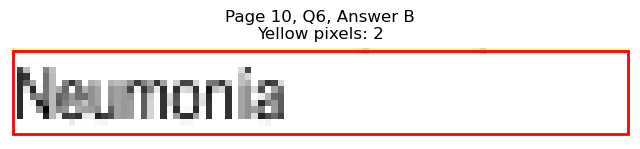

Page 10, Q6 - C: Detected box: x0=82.9, y0=590.0, x1=112.0, y1=602.6
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 153
Page 10, Q6, C: Yellow percentage: 0.0%


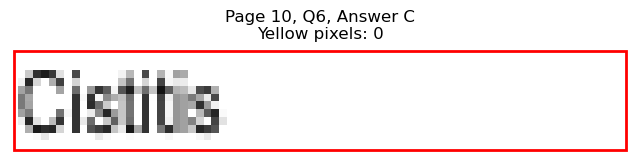

Page 10, Q6 - D: Detected box: x0=334.6, y0=564.8, x1=392.3, y1=577.4
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 312
Page 10, Q6, D: Yellow percentage: 0.0%


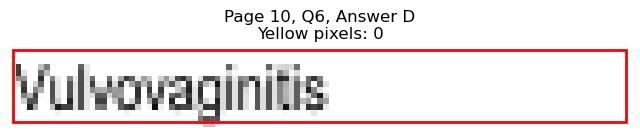

Page 10, Q6 - E: Detected box: x0=334.1, y0=577.4, x1=383.3, y1=590.0
Page 10, Q6, E: Yellow pixels: 0
Page 10, Q6, E: Total non-white pixels: 278
Page 10, Q6, E: Yellow percentage: 0.0%


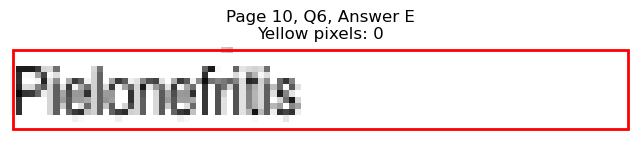


Page 10, Q6 - Selected Answer: A (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=82.5, y0=665.7, x1=248.0, y1=678.4
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 913
Page 10, Q7, A: Yellow percentage: 0.0%


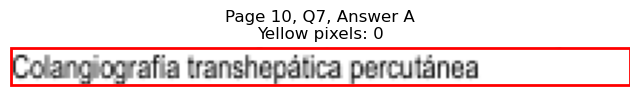

Page 10, Q7 - B: Detected box: x0=82.5, y0=678.3, x1=232.0, y1=691.0
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 753
Page 10, Q7, B: Yellow percentage: 0.0%


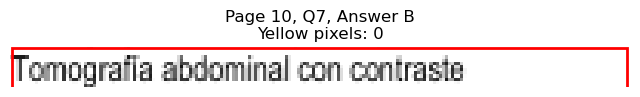

Page 10, Q7 - C: Detected box: x0=82.9, y0=691.1, x1=228.5, y1=703.7
Page 10, Q7, C: Yellow pixels: 1918
Page 10, Q7, C: Total non-white pixels: 2509
Page 10, Q7, C: Yellow percentage: 76.4%


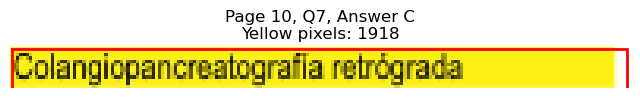

Page 10, Q7 - D: Detected box: x0=334.6, y0=665.7, x1=416.8, y1=678.4
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 439
Page 10, Q7, D: Yellow percentage: 0.0%


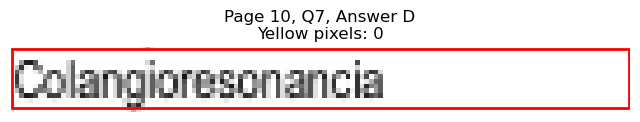

Page 10, Q7 - E: Detected box: x0=334.1, y0=678.3, x1=475.1, y1=691.0
Page 10, Q7, E: Yellow pixels: 0
Page 10, Q7, E: Total non-white pixels: 713
Page 10, Q7, E: Yellow percentage: 0.0%


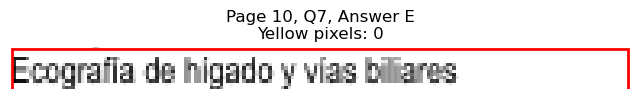


Page 10, Q7 - Selected Answer: C (based on yellow pixel count)





Page 11: Found 8 questions
Page 11, Q1 - A: Detected box: x0=82.5, y0=122.9, x1=95.1, y1=135.6
Page 11, Q1, A: Yellow pixels: 801
Page 11, Q1, A: Total non-white pixels: 896
Page 11, Q1, A: Yellow percentage: 89.4%


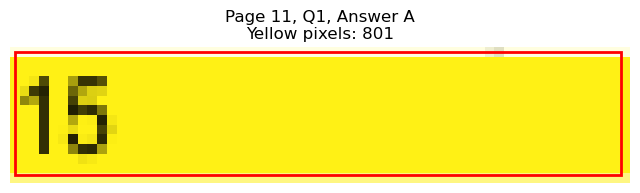

Page 11, Q1 - B: Detected box: x0=82.5, y0=135.5, x1=100.0, y1=148.2
Page 11, Q1, B: Yellow pixels: 68
Page 11, Q1, B: Total non-white pixels: 141
Page 11, Q1, B: Yellow percentage: 48.2%


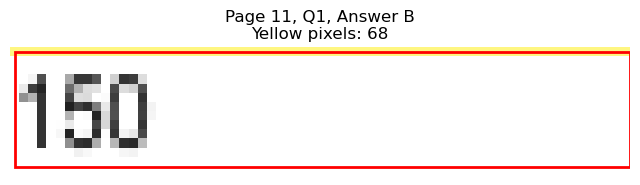

Page 11, Q1 - C: Detected box: x0=82.9, y0=148.2, x1=95.5, y1=160.9
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 71
Page 11, Q1, C: Yellow percentage: 0.0%


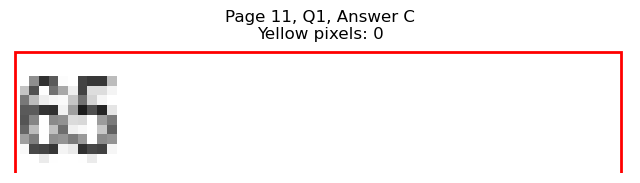

Page 11, Q1 - D: Detected box: x0=334.6, y0=122.9, x1=352.1, y1=135.6
Page 11, Q1, D: Yellow pixels: 0
Page 11, Q1, D: Total non-white pixels: 93
Page 11, Q1, D: Yellow percentage: 0.0%


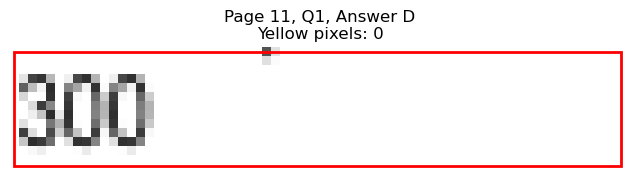

Page 11, Q1 - E: Detected box: x0=334.1, y0=135.5, x1=346.7, y1=148.2
Page 11, Q1, E: Yellow pixels: 0
Page 11, Q1, E: Total non-white pixels: 55
Page 11, Q1, E: Yellow percentage: 0.0%


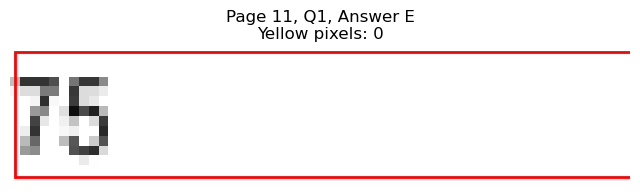


Page 11, Q1 - Selected Answer: A (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=82.5, y0=223.9, x1=140.2, y1=236.6
Page 11, Q2, A: Yellow pixels: 0
Page 11, Q2, A: Total non-white pixels: 299
Page 11, Q2, A: Yellow percentage: 0.0%


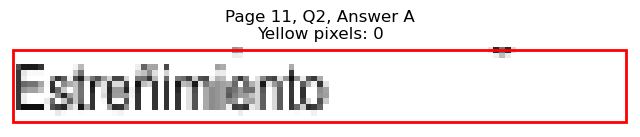

Page 11, Q2 - B: Detected box: x0=82.5, y0=236.5, x1=156.3, y1=249.2
Page 11, Q2, B: Yellow pixels: 0
Page 11, Q2, B: Total non-white pixels: 375
Page 11, Q2, B: Yellow percentage: 0.0%


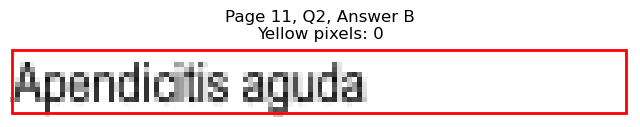

Page 11, Q2 - C: Detected box: x0=82.9, y0=249.1, x1=169.2, y1=261.8
Page 11, Q2, C: Yellow pixels: 0
Page 11, Q2, C: Total non-white pixels: 459
Page 11, Q2, C: Yellow percentage: 0.0%


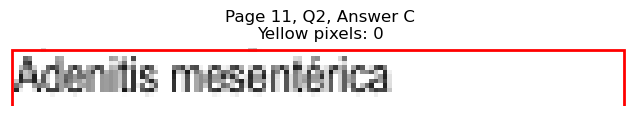

Page 11, Q2 - D: Detected box: x0=334.6, y0=223.9, x1=419.8, y1=236.6
Page 11, Q2, D: Yellow pixels: 136
Page 11, Q2, D: Total non-white pixels: 576
Page 11, Q2, D: Yellow percentage: 23.6%


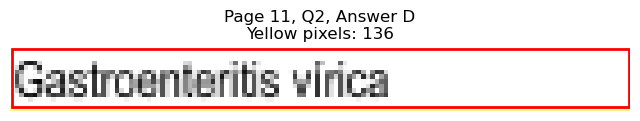

Page 11, Q2 - E: Detected box: x0=334.1, y0=236.5, x1=441.4, y1=249.2
Page 11, Q2, E: Yellow pixels: 1670
Page 11, Q2, E: Total non-white pixels: 2212
Page 11, Q2, E: Yellow percentage: 75.5%


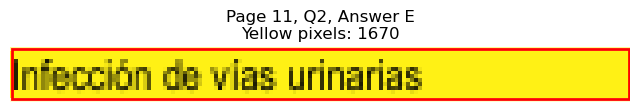


Page 11, Q2 - Selected Answer: E (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=82.5, y0=312.3, x1=162.7, y1=324.9
Page 11, Q3, A: Yellow pixels: 0
Page 11, Q3, A: Total non-white pixels: 423
Page 11, Q3, A: Yellow percentage: 0.0%


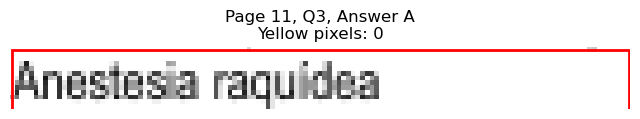

Page 11, Q3 - B: Detected box: x0=82.5, y0=324.9, x1=189.7, y1=337.5
Page 11, Q3, B: Yellow pixels: 0
Page 11, Q3, B: Total non-white pixels: 528
Page 11, Q3, B: Yellow percentage: 0.0%


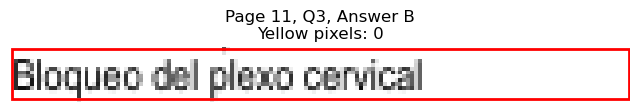

Page 11, Q3 - C: Detected box: x0=82.9, y0=337.5, x1=157.7, y1=350.1
Page 11, Q3, C: Yellow pixels: 0
Page 11, Q3, C: Total non-white pixels: 394
Page 11, Q3, C: Yellow percentage: 0.0%


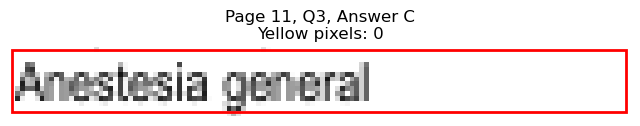

Page 11, Q3 - D: Detected box: x0=334.6, y0=312.3, x1=411.4, y1=324.9
Page 11, Q3, D: Yellow pixels: 0
Page 11, Q3, D: Total non-white pixels: 521
Page 11, Q3, D: Yellow percentage: 0.0%


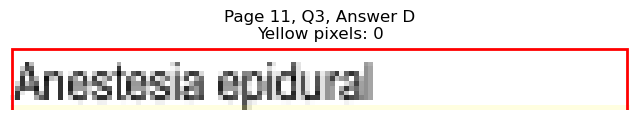

Page 11, Q3 - E: Detected box: x0=334.1, y0=324.9, x1=443.0, y1=337.5
Page 11, Q3, E: Yellow pixels: 1652
Page 11, Q3, E: Total non-white pixels: 2226
Page 11, Q3, E: Yellow percentage: 74.2%


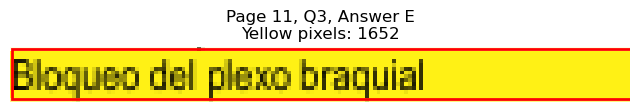


Page 11, Q3 - Selected Answer: E (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=82.5, y0=375.4, x1=149.2, y1=388.1
Page 11, Q4, A: Yellow pixels: 0
Page 11, Q4, A: Total non-white pixels: 334
Page 11, Q4, A: Yellow percentage: 0.0%


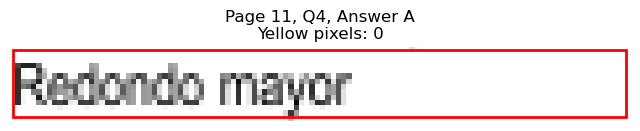

Page 11, Q4 - B: Detected box: x0=82.5, y0=388.0, x1=122.5, y1=400.7
Page 11, Q4, B: Yellow pixels: 0
Page 11, Q4, B: Total non-white pixels: 213
Page 11, Q4, B: Yellow percentage: 0.0%


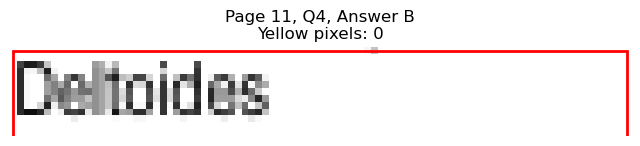

Page 11, Q4 - C: Detected box: x0=82.9, y0=400.6, x1=146.7, y1=413.3
Page 11, Q4, C: Yellow pixels: 0
Page 11, Q4, C: Total non-white pixels: 336
Page 11, Q4, C: Yellow percentage: 0.0%


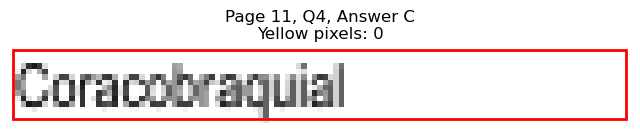

Page 11, Q4 - D: Detected box: x0=334.6, y0=375.4, x1=397.4, y1=388.1
Page 11, Q4, D: Yellow pixels: 1232
Page 11, Q4, D: Total non-white pixels: 1596
Page 11, Q4, D: Yellow percentage: 77.2%


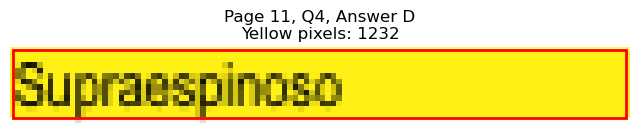

Page 11, Q4 - E: Detected box: x0=334.1, y0=388.0, x1=371.7, y1=400.7
Page 11, Q4, E: Yellow pixels: 0
Page 11, Q4, E: Total non-white pixels: 271
Page 11, Q4, E: Yellow percentage: 0.0%


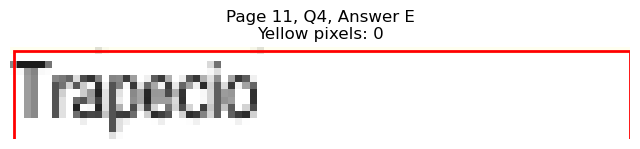


Page 11, Q4 - Selected Answer: D (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=82.5, y0=438.5, x1=113.5, y1=451.2
Page 11, Q5, A: Yellow pixels: 0
Page 11, Q5, A: Total non-white pixels: 154
Page 11, Q5, A: Yellow percentage: 0.0%


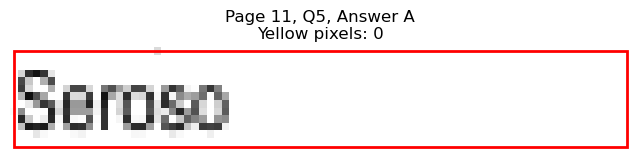

Page 11, Q5 - B: Detected box: x0=82.5, y0=451.1, x1=123.6, y1=463.8
Page 11, Q5, B: Yellow pixels: 0
Page 11, Q5, B: Total non-white pixels: 195
Page 11, Q5, B: Yellow percentage: 0.0%


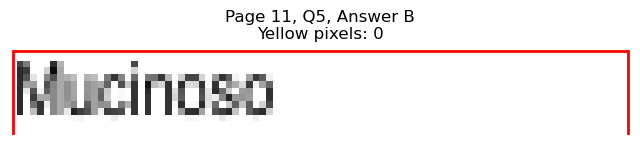

Page 11, Q5 - C: Detected box: x0=82.9, y0=463.7, x1=127.6, y1=476.4
Page 11, Q5, C: Yellow pixels: 0
Page 11, Q5, C: Total non-white pixels: 225
Page 11, Q5, C: Yellow percentage: 0.0%


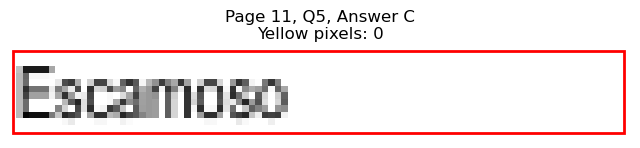

Page 11, Q5 - D: Detected box: x0=334.6, y0=438.5, x1=405.8, y1=451.2
Page 11, Q5, D: Yellow pixels: 122
Page 11, Q5, D: Total non-white pixels: 481
Page 11, Q5, D: Yellow percentage: 25.4%


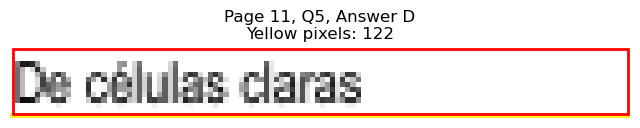

Page 11, Q5 - E: Detected box: x0=334.1, y0=451.1, x1=404.3, y1=463.8
Page 11, Q5, E: Yellow pixels: 1294
Page 11, Q5, E: Total non-white pixels: 1573
Page 11, Q5, E: Yellow percentage: 82.3%


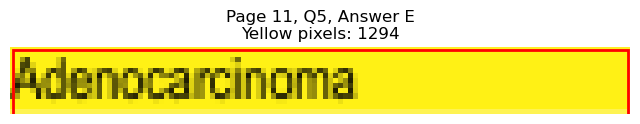


Page 11, Q5 - Selected Answer: E (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=82.5, y0=514.3, x1=119.5, y1=526.9
Page 11, Q6, A: Yellow pixels: 0
Page 11, Q6, A: Total non-white pixels: 196
Page 11, Q6, A: Yellow percentage: 0.0%


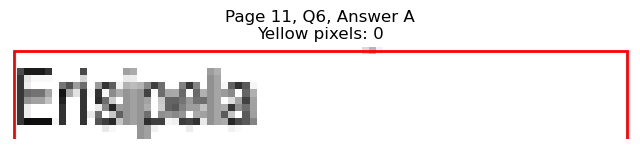

Page 11, Q6 - B: Detected box: x0=82.5, y0=526.9, x1=145.1, y1=539.5
Page 11, Q6, B: Yellow pixels: 114
Page 11, Q6, B: Total non-white pixels: 447
Page 11, Q6, B: Yellow percentage: 25.5%


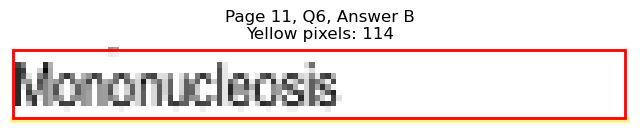

Page 11, Q6 - C: Detected box: x0=82.9, y0=539.5, x1=130.1, y1=552.1
Page 11, Q6, C: Yellow pixels: 1092
Page 11, Q6, C: Total non-white pixels: 1386
Page 11, Q6, C: Yellow percentage: 78.8%


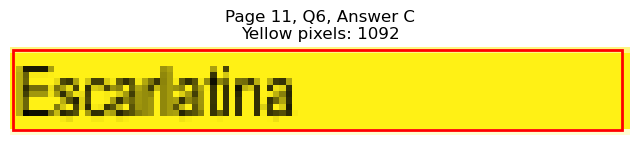

Page 11, Q6 - D: Detected box: x0=334.6, y0=514.3, x1=410.8, y1=526.9
Page 11, Q6, D: Yellow pixels: 0
Page 11, Q6, D: Total non-white pixels: 387
Page 11, Q6, D: Yellow percentage: 0.0%


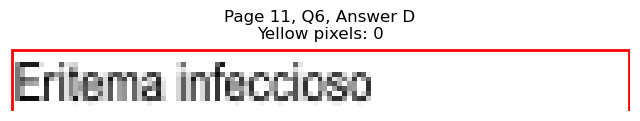

Page 11, Q6 - E: Detected box: x0=334.1, y0=526.9, x1=448.5, y1=539.5
Page 11, Q6, E: Yellow pixels: 0
Page 11, Q6, E: Total non-white pixels: 585
Page 11, Q6, E: Yellow percentage: 0.0%


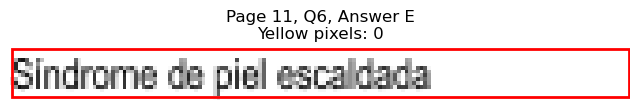


Page 11, Q6 - Selected Answer: C (based on yellow pixel count)




Page 11, Q7 - A: Detected box: x0=82.5, y0=615.2, x1=174.7, y1=627.8
Page 11, Q7, A: Yellow pixels: 0
Page 11, Q7, A: Total non-white pixels: 466
Page 11, Q7, A: Yellow percentage: 0.0%


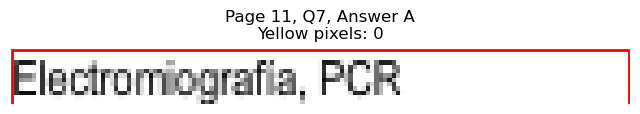

Page 11, Q7 - B: Detected box: x0=82.5, y0=627.9, x1=195.4, y1=640.6
Page 11, Q7, B: Yellow pixels: 1664
Page 11, Q7, B: Total non-white pixels: 2296
Page 11, Q7, B: Yellow percentage: 72.5%


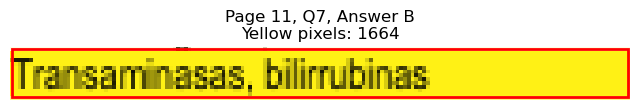

Page 11, Q7 - C: Detected box: x0=82.9, y0=640.5, x1=196.8, y1=653.2
Page 11, Q7, C: Yellow pixels: 165
Page 11, Q7, C: Total non-white pixels: 746
Page 11, Q7, C: Yellow percentage: 22.1%


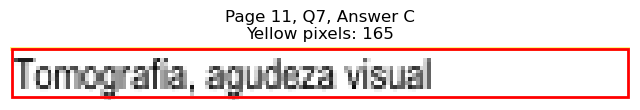

Page 11, Q7 - D: Detected box: x0=334.6, y0=615.2, x1=446.0, y1=627.8
Page 11, Q7, D: Yellow pixels: 0
Page 11, Q7, D: Total non-white pixels: 575
Page 11, Q7, D: Yellow percentage: 0.0%


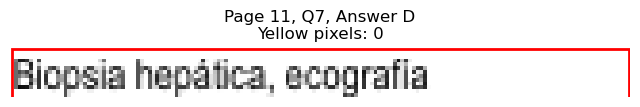

Page 11, Q7 - E: Detected box: x0=334.1, y0=627.9, x1=434.5, y1=640.6
Page 11, Q7, E: Yellow pixels: 0
Page 11, Q7, E: Total non-white pixels: 549
Page 11, Q7, E: Yellow percentage: 0.0%


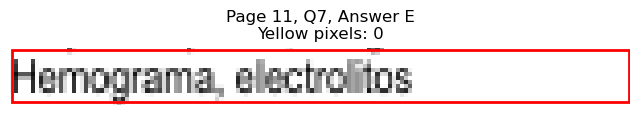


Page 11, Q7 - Selected Answer: B (based on yellow pixel count)




Page 11, Q8 - A: Detected box: x0=82.5, y0=716.3, x1=219.3, y1=728.9
Page 11, Q8, A: Yellow pixels: 0
Page 11, Q8, A: Total non-white pixels: 719
Page 11, Q8, A: Yellow percentage: 0.0%


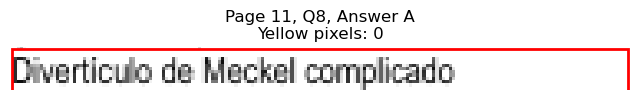

Page 11, Q8 - B: Detected box: x0=82.5, y0=728.9, x1=206.8, y1=741.5
Page 11, Q8, B: Yellow pixels: 0
Page 11, Q8, B: Total non-white pixels: 631
Page 11, Q8, B: Yellow percentage: 0.0%


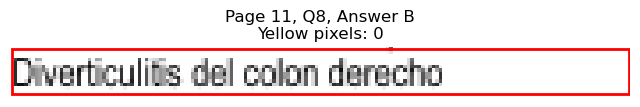

Page 11, Q8 - C: Detected box: x0=82.9, y0=741.4, x1=173.2, y1=754.1
Page 11, Q8, C: Yellow pixels: 0
Page 11, Q8, C: Total non-white pixels: 444
Page 11, Q8, C: Yellow percentage: 0.0%


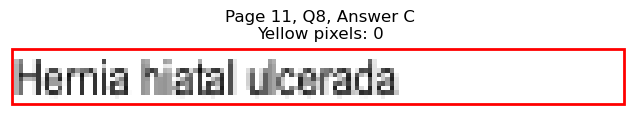

Page 11, Q8 - D: Detected box: x0=334.6, y0=716.3, x1=450.5, y1=728.9
Page 11, Q8, D: Yellow pixels: 0
Page 11, Q8, D: Total non-white pixels: 731
Page 11, Q8, D: Yellow percentage: 0.0%


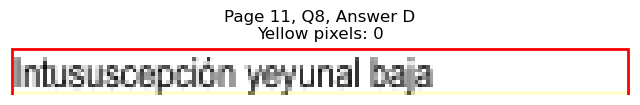

Page 11, Q8 - E: Detected box: x0=334.1, y0=728.9, x1=449.5, y1=741.5
Page 11, Q8, E: Yellow pixels: 1687
Page 11, Q8, E: Total non-white pixels: 2324
Page 11, Q8, E: Yellow percentage: 72.6%


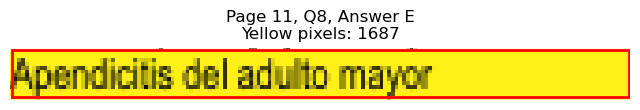


Page 11, Q8 - Selected Answer: E (based on yellow pixel count)





Page 12: Found 2 questions
Page 12, Q1 - A: Detected box: x0=82.5, y0=135.5, x1=137.2, y1=148.2
Page 12, Q1, A: Yellow pixels: 0
Page 12, Q1, A: Total non-white pixels: 279
Page 12, Q1, A: Yellow percentage: 0.0%


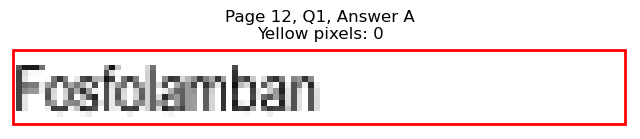

Page 12, Q1 - B: Detected box: x0=82.5, y0=148.2, x1=133.6, y1=160.9
Page 12, Q1, B: Yellow pixels: 1142
Page 12, Q1, B: Total non-white pixels: 1326
Page 12, Q1, B: Yellow percentage: 86.1%


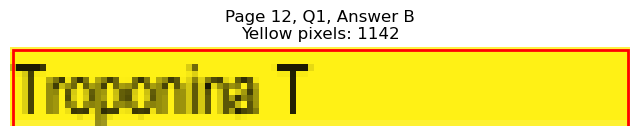

Page 12, Q1 - C: Detected box: x0=82.9, y0=160.8, x1=107.5, y1=173.5
Page 12, Q1, C: Yellow pixels: 74
Page 12, Q1, C: Total non-white pixels: 196
Page 12, Q1, C: Yellow percentage: 37.8%


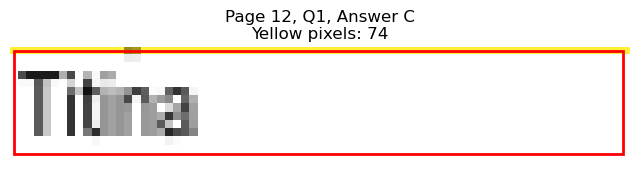

Page 12, Q1 - D: Detected box: x0=334.6, y0=135.5, x1=362.2, y1=148.2
Page 12, Q1, D: Yellow pixels: 0
Page 12, Q1, D: Total non-white pixels: 135
Page 12, Q1, D: Yellow percentage: 0.0%


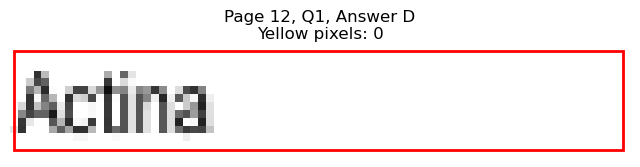

Page 12, Q1 - E: Detected box: x0=334.1, y0=148.2, x1=396.3, y1=160.9
Page 12, Q1, E: Yellow pixels: 0
Page 12, Q1, E: Total non-white pixels: 325
Page 12, Q1, E: Yellow percentage: 0.0%


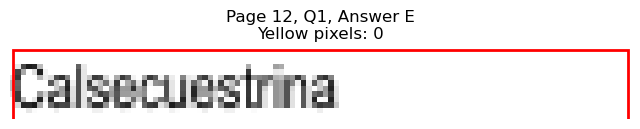


Page 12, Q1 - Selected Answer: B (based on yellow pixel count)




Page 12, Q2 - A: Detected box: x0=82.5, y0=211.3, x1=122.5, y1=224.0
Page 12, Q2, A: Yellow pixels: 0
Page 12, Q2, A: Total non-white pixels: 161
Page 12, Q2, A: Yellow percentage: 0.0%


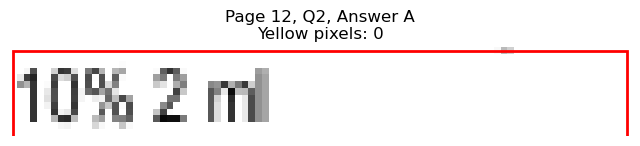

Page 12, Q2 - B: Detected box: x0=82.5, y0=223.9, x1=122.5, y1=236.6
Page 12, Q2, B: Yellow pixels: 91
Page 12, Q2, B: Total non-white pixels: 264
Page 12, Q2, B: Yellow percentage: 34.5%


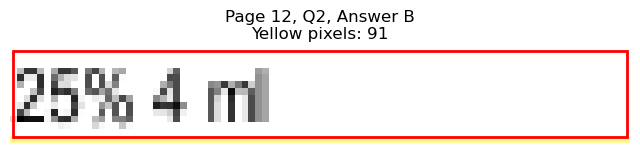

Page 12, Q2 - C: Detected box: x0=82.9, y0=236.5, x1=123.0, y1=249.2
Page 12, Q2, C: Yellow pixels: 1050
Page 12, Q2, C: Total non-white pixels: 1288
Page 12, Q2, C: Yellow percentage: 81.5%


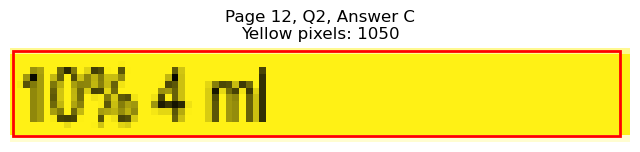

Page 12, Q2 - D: Detected box: x0=334.6, y0=211.3, x1=369.8, y1=224.0
Page 12, Q2, D: Yellow pixels: 0
Page 12, Q2, D: Total non-white pixels: 152
Page 12, Q2, D: Yellow percentage: 0.0%


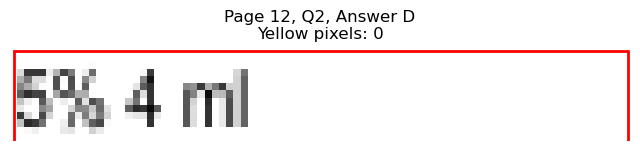

Page 12, Q2 - E: Detected box: x0=334.1, y0=223.9, x1=369.3, y1=236.6
Page 12, Q2, E: Yellow pixels: 0
Page 12, Q2, E: Total non-white pixels: 158
Page 12, Q2, E: Yellow percentage: 0.0%


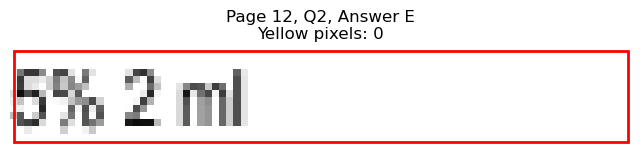


Page 12, Q2 - Selected Answer: C (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Varón de 40 años, consulta por fiebre de 38 °C...
1   Mujer de 25 años, acude por malestar general, ...
2   Usted es el responsable de Epidemiología en un...
3   Varón de 60 años, con cierta dificultad de mov...
4   ¿En qué capa de la piel los melanocitos y comp...
..                                                ...
85  Niño de 7 años, presenta fiebre, odinofagia y ...
86  Mujer de 30 años con sudoración nocturna, aste...
87  Varón de 80 años, consulta por dolor abdominal...
88  Varón de 56 años, llega a emergencia por dolor...
89  Recién nacida de 38 semanas producto de cesáre...

[90 rows x 1 columns]

In [8]:
answers_df

option_A                          option_B  \
0            Neumonitis intersticial                   Derrame pleural   
1                     Chancro blando                Granuloma inguinal   
2                  Casos y controles                Cuasi experimental   
3          Encefalopatía de Wernicke           Enfermedad de Alzheimer   
4                           Espinosa                         Granulosa   
..                               ...                               ...   
85                         Erisipela                     Mononucleosis   
86             Electromiografía, PCR       Transaminasas, bilirrubinas   
87  Divertículo de Meckel complicado  Diverticulitis del colon derecho   
88                       Fosfolamban                       Troponina T   
89                          10% 2 ml                          25% 4 ml   

                              option_C                        option_D  \
0   Neumonía adquirida en la comunidad           Tuberculosis pulmonar   
1                              Sífilis              Molusco contagioso   
2                Cohortes concurrentes                       Ecológico   
3              Enfermedad de Parkinson  Esclerosis lateral amiotrófica   
4                                Basal                          Dermis   
..                                 ...                             ...   
85                         Escarlatina              Eritema infeccioso   
86          Tomografía, agudeza visual     Biopsia hepática, ecografía   
87              Hernia hiatal ulcerada     Intususcepción yeyunal baja   
88                              Titina                          Actina   
89                            10% 4 ml                         5% 4 ml   

                        option_E  
0          Aspergilosis pulmonar  
1                 Herpes genital  
2                 Serie de casos  
3               Miastenia gravis  
4                         Córnea  
..                           ...  
85    Síndrome de piel escaldada  
86       Hemograma, electrolitos  
87  Apendicitis del adulto mayor  
88                Calsecuestrina  
89                       5% 2 ml  

[90 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               C
1               E
2               A
3               C
4               C
..            ...
85              C
86              B
87              E
88              B
89              C

[90 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   Varón de 40 años, consulta por fiebre de 38 °C...   
1   Mujer de 25 años, acude por malestar general, ...   
2   Usted es el responsable de Epidemiología en un...   
3   Varón de 60 años, con cierta dificultad de mov...   
4   ¿En qué capa de la piel los melanocitos y comp...   
..                                                ...   
85  Niño de 7 años, presenta fiebre, odinofagia y ...   
86  Mujer de 30 años con sudoración nocturna, aste...   
87  Varón de 80 años, consulta por dolor abdominal...   
88  Varón de 56 años, llega a emergencia por dolor...   
89  Recién nacida de 38 semanas producto de cesáre...   

                            option_A                          option_B  \
0            Neumonitis intersticial                   Derrame pleural   
1                     Chancro blando                Granuloma inguinal   
2                  Casos y controles                Cuasi experimental   
3          Encefalopatía de Wernicke           Enfermedad de Alzheimer   
4                           Espinosa                         Granulosa   
..                               ...                               ...   
85                         Erisipela                     Mononucleosis   
86             Electromiografía, PCR       Transaminasas, bilirrubinas   
87  Divertículo de Meckel complicado  Diverticulitis del colon derecho   
88                       Fosfolamban                       Troponina T   
89                          10% 2 ml                          25% 4 ml   

                              option_C                        option_D  \
0   Neumonía adquirida en la comunidad           Tuberculosis pulmonar   
1                              Sífilis              Molusco contagioso   
2                Cohortes concurrentes                       Ecológico   
3              Enfermedad de Parkinson  Esclerosis lateral amiotrófica   
4                                Basal                          Dermis   
..                                 ...                             ...   
85                         Escarlatina              Eritema infeccioso   
86          Tomografía, agudeza visual     Biopsia hepática, ecografía   
87              Hernia hiatal ulcerada     Intususcepción yeyunal baja   
88                              Titina                          Actina   
89                            10% 4 ml                         5% 4 ml   

                        option_E correct_answer  
0          Aspergilosis pulmonar              C  
1                 Herpes genital              E  
2                 Serie de casos              A  
3               Miastenia gravis              C  
4                         Córnea              C  
..                           ...            ...  
85    Síndrome de piel escaldada              C  
86       Hemograma, electrolitos              B  
87  Apendicitis del adulto mayor              E  
88                Calsecuestrina              B  
89                       5% 2 ml              C  

[90 rows x 7 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2020/PRUEBA A.csv
